In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

exec('from __future__ import division')

import numpy as np
import os, glob, json 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
spec_colors = {"data": "xkcd:blue",
               "GW_rec": "xkcd:red",
               "GW_inj": "xkcd:purple",
               "glitch_rec": "xkcd:green",
               "glitch_inj": "xkcd:olive"}

import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import enterprise_extensions

import corner
#from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
#import my_ptmcmc

import pickle
import emcee

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

from IPython.core.debugger import set_trace

import BayesHopperBurst

from pylab import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Setup

In [2]:
parfiles = sorted(glob.glob('../12p5yr-like_data/real_4/*.par'))
timfiles = sorted(glob.glob('../12p5yr-like_data/real_4/*.tim'))

print(parfiles)
print(timfiles)

psrlist = [ll.split("/")[-1][:-4] for ll in parfiles]
print(psrlist)
print(len(psrlist))

['../12p5yr-like_data/real_4/B1855+09.par', '../12p5yr-like_data/real_4/B1937+21.par', '../12p5yr-like_data/real_4/B1953+29.par', '../12p5yr-like_data/real_4/J0023+0923.par', '../12p5yr-like_data/real_4/J0030+0451.par', '../12p5yr-like_data/real_4/J0340+4130.par', '../12p5yr-like_data/real_4/J0613-0200.par', '../12p5yr-like_data/real_4/J0636+5128.par', '../12p5yr-like_data/real_4/J0645+5158.par', '../12p5yr-like_data/real_4/J0740+6620.par', '../12p5yr-like_data/real_4/J0931-1902.par', '../12p5yr-like_data/real_4/J1012+5307.par', '../12p5yr-like_data/real_4/J1024-0719.par', '../12p5yr-like_data/real_4/J1125+7819.par', '../12p5yr-like_data/real_4/J1453+1902.par', '../12p5yr-like_data/real_4/J1455-3330.par', '../12p5yr-like_data/real_4/J1600-3053.par', '../12p5yr-like_data/real_4/J1614-2230.par', '../12p5yr-like_data/real_4/J1640+2224.par', '../12p5yr-like_data/real_4/J1643-1224.par', '../12p5yr-like_data/real_4/J1713+0747.par', '../12p5yr-like_data/real_4/J1738+0333.par', '../12p5yr-like

In [3]:
%%time

tmin = 53216.1516728
stop_time = 57781.7766728 #for 12.5yr slice

psrs = []
for i, (p, t) in enumerate(zip(parfiles[::], timfiles[::])):
    print(p)
    psr = Pulsar(p, t, ephem='DE436', clk=None)
    psr.filter_data(start_time = 0.0, end_time = stop_time)
    if (psr.toas.size == 0) or (enterprise_extensions.model_utils.get_tspan([psr]) < 3*365.25*24*3600):
        print("Meh")
        continue
    else:
        print("yeah")
        psrs.append(psr)

#Test whether the time-span for the new dataset is really 12.5-yr
tspan = enterprise_extensions.model_utils.get_tspan(psrs)
print(tspan / (365.25 * 24 * 3600))
print(len(psrs))

../12p5yr-like_data/real_4/B1855+09.par


[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
yeah
../12p5yr-like_data/real_4/B1937+21.par


[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
yeah
../12p5yr-like_data/real_4/B1953+29.par


yeah
../12p5yr-like_data/real_4/J0023+0923.par


yeah
../12p5yr-like_data/real_4/J0030+0451.par
yeah
../12p5yr-like_data/real_4/J0340+4130.par


yeah
../12p5yr-like_data/real_4/J0613-0200.par
yeah
../12p5yr-like_data/real_4/J0636+5128.par


yeah
../12p5yr-like_data/real_4/J0645+5158.par


yeah
../12p5yr-like_data/real_4/J0740+6620.par


yeah
../12p5yr-like_data/real_4/J0931-1902.par


yeah
../12p5yr-like_data/real_4/J1012+5307.par
yeah
../12p5yr-like_data/real_4/J1024-0719.par
yeah
../12p5yr-like_data/real_4/J1125+7819.par


yeah
../12p5yr-like_data/real_4/J1453+1902.par


yeah
../12p5yr-like_data/real_4/J1455-3330.par
yeah
../12p5yr-like_data/real_4/J1600-3053.par
yeah
../12p5yr-like_data/real_4/J1614-2230.par


yeah
../12p5yr-like_data/real_4/J1640+2224.par
yeah
../12p5yr-like_data/real_4/J1643-1224.par
yeah
../12p5yr-like_data/real_4/J1713+0747.par
yeah
../12p5yr-like_data/real_4/J1738+0333.par


yeah
../12p5yr-like_data/real_4/J1741+1351.par


yeah
../12p5yr-like_data/real_4/J1744-1134.par
yeah
../12p5yr-like_data/real_4/J1747-4036.par


yeah
../12p5yr-like_data/real_4/J1832-0836.par


yeah
../12p5yr-like_data/real_4/J1853+1303.par


yeah
../12p5yr-like_data/real_4/J1903+0327.par


yeah
../12p5yr-like_data/real_4/J1909-3744.par
yeah
../12p5yr-like_data/real_4/J1910+1256.par
yeah
../12p5yr-like_data/real_4/J1911+1347.par


yeah
../12p5yr-like_data/real_4/J1918-0642.par
yeah
../12p5yr-like_data/real_4/J1923+2515.par


yeah
../12p5yr-like_data/real_4/J1944+0907.par


yeah
../12p5yr-like_data/real_4/J2010-1323.par


yeah
../12p5yr-like_data/real_4/J2017+0603.par


yeah
../12p5yr-like_data/real_4/J2033+1734.par


yeah
../12p5yr-like_data/real_4/J2043+1711.par


yeah
../12p5yr-like_data/real_4/J2145-0750.par
yeah
../12p5yr-like_data/real_4/J2214+3000.par


yeah
../12p5yr-like_data/real_4/J2229+2643.par


yeah
../12p5yr-like_data/real_4/J2234+0611.par


yeah
../12p5yr-like_data/real_4/J2234+0944.par


yeah
../12p5yr-like_data/real_4/J2302+4442.par


yeah
../12p5yr-like_data/real_4/J2317+1439.par
yeah
12.497185184808304
45
CPU times: user 5min 40s, sys: 9.62 s, total: 5min 49s
Wall time: 2min 12s


In [4]:
npzfile = np.load("../SimDataResults/samples_12p5yr-like_real4.npz")

acc_fraction = npzfile['acc_fraction']
swap_record = npzfile['swap_record']
samples = npzfile['samples']#[:,:200000,:]
log_likelihood = npzfile['log_likelihood']
print(acc_fraction)
print(samples.shape)
print(samples[0,0,:])

[[0.20491552 0.21343999 0.21762015]
 [0.18063128 0.19577967 0.19750376]
 [0.20461992 0.22174052 0.23027876]
 [0.03827716 0.04201223 0.04808541]
 [       nan        nan        nan]
 [0.88350311 0.9237616         nan]
 [0.65147276 0.68573065 0.71549426]
 [       nan        nan        nan]]
(3, 499000, 84)
[  1.           1.          -0.32393308   0.79354059   5.08991679
  -7.88993674  -6.34462951  -9.08647357   3.66710855   3.20244334
   2.83834015   4.57240946   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          -8.02607916  -8.73227216   2.88860892
  42.07109718   7.7319873    2.54

# Diagnostic plots

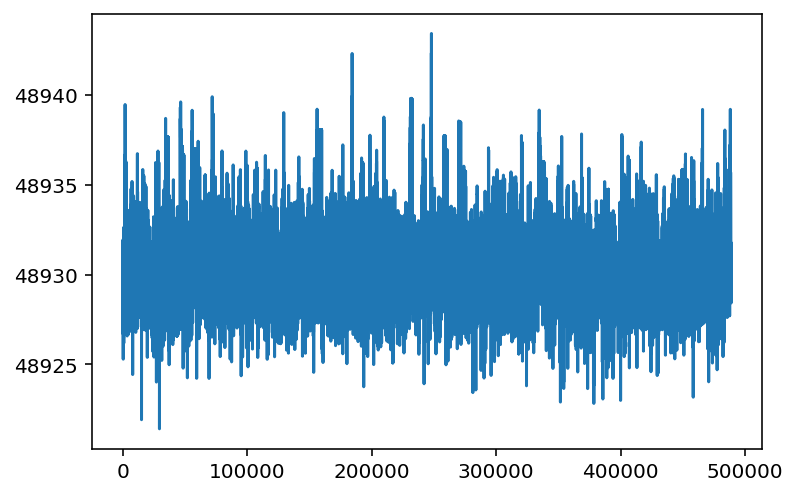

In [8]:
burnin = 10_000
plt.plot(log_likelihood[0,burnin:])

Text(0, 0.5, '# of signal wavelets')

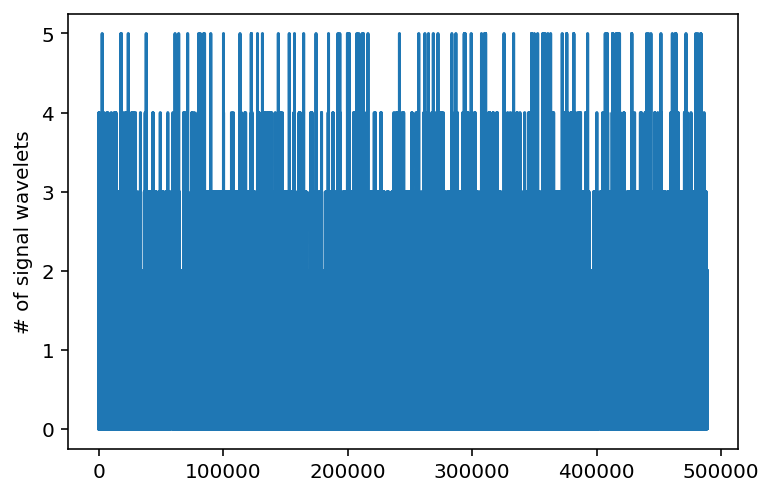

In [19]:
plt.figure()
plt.plot(samples[0,burnin:,0])
plt.ylabel("# of signal wavelets")

Text(0, 0.5, '# of noise transient wavelets')

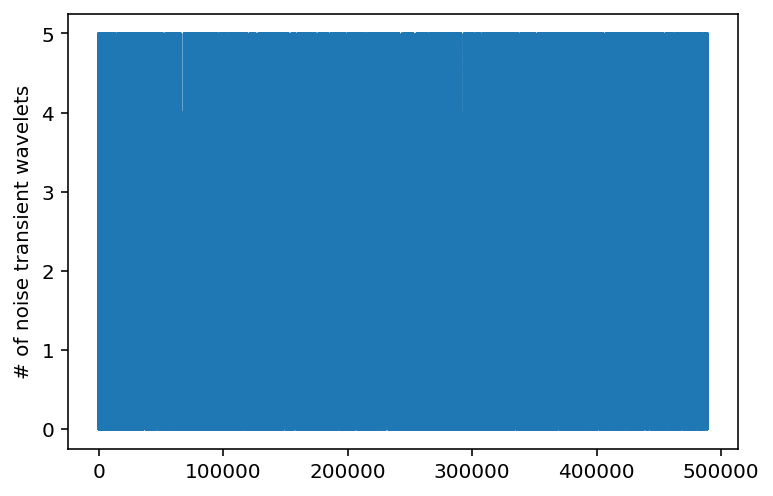

In [20]:
plt.figure()
plt.plot(samples[0,burnin:,1])
plt.ylabel("# of noise transient wavelets")

# SIGNAL WAVELET PARAMETERS

(49900, 84)
5
[6.123233995736766e-17, 1.0, 0.0, -7.522878745280337, -6.0, 0.0, 2.737850787132101, 0.5475701574264202]


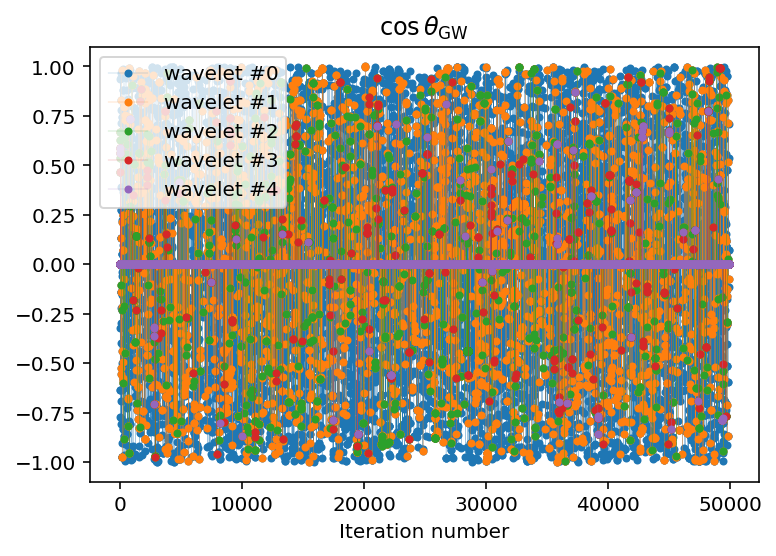

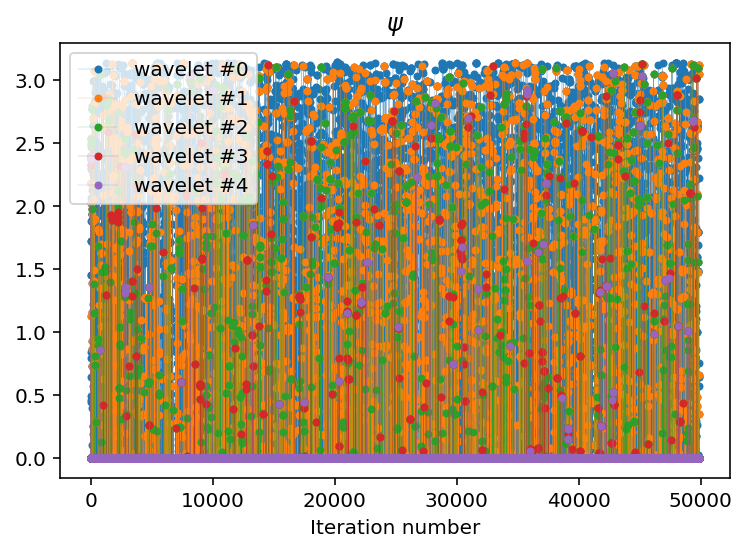

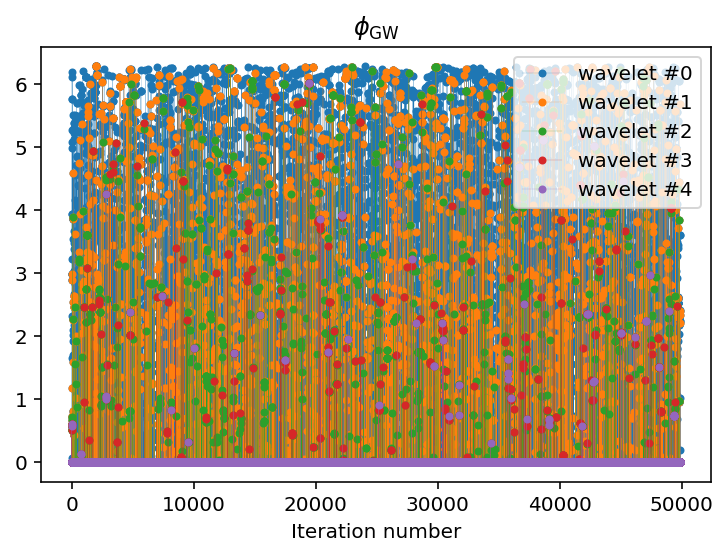

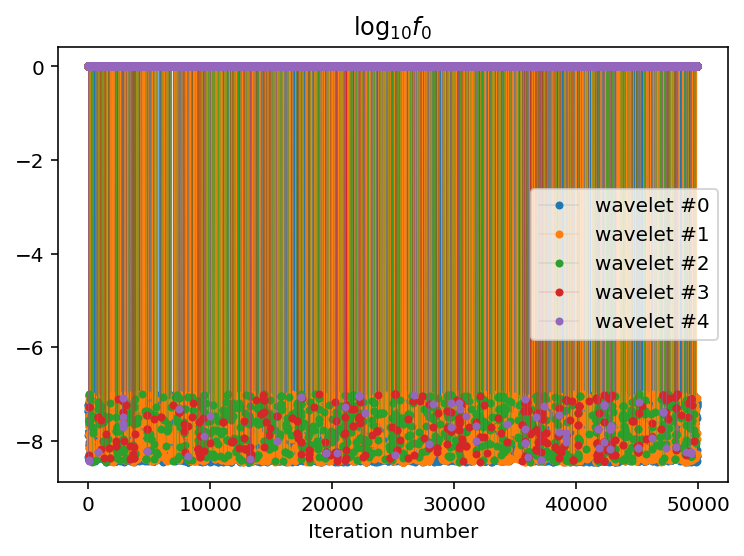

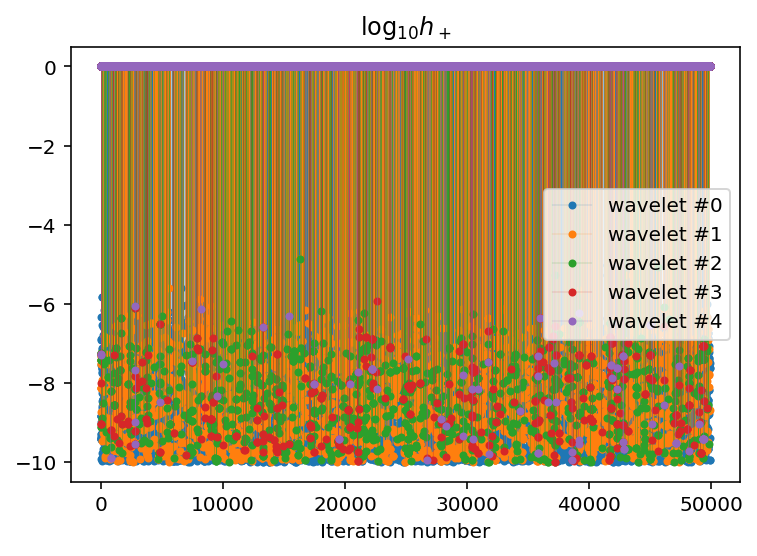

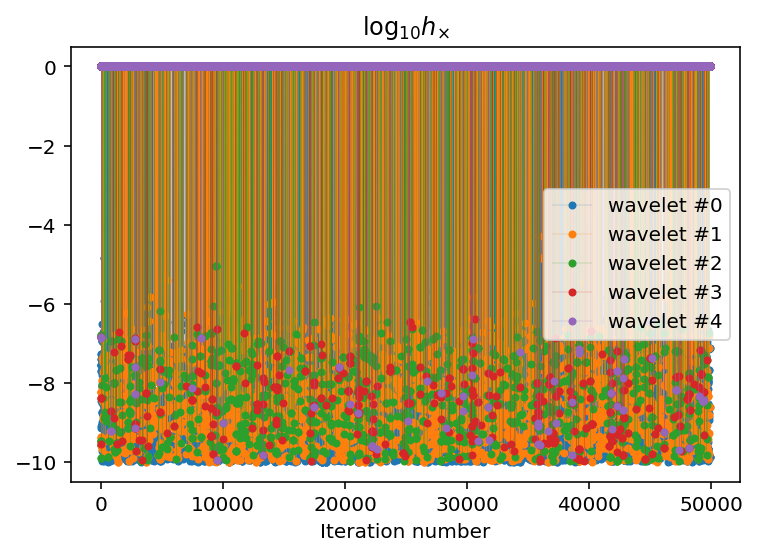

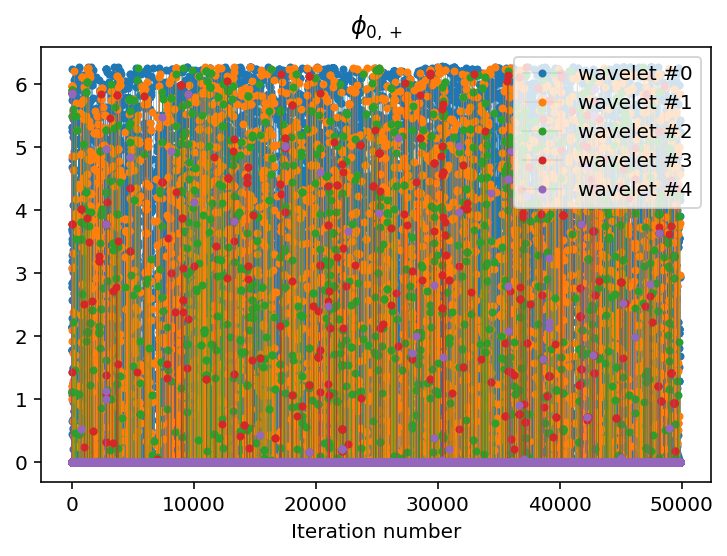

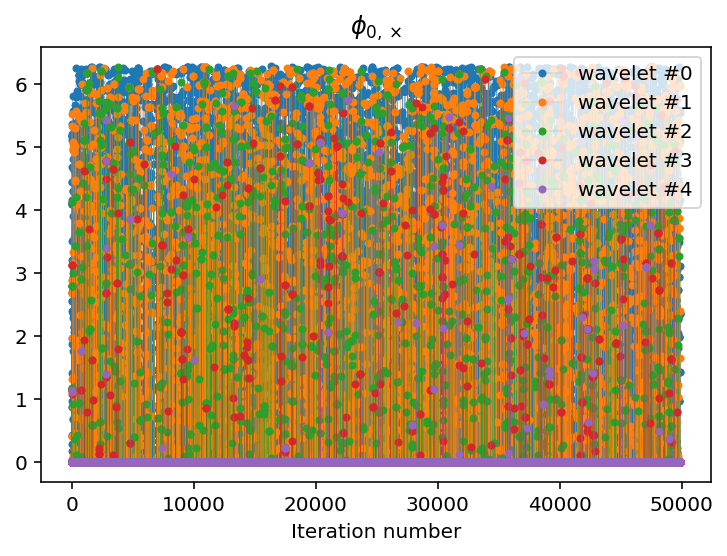

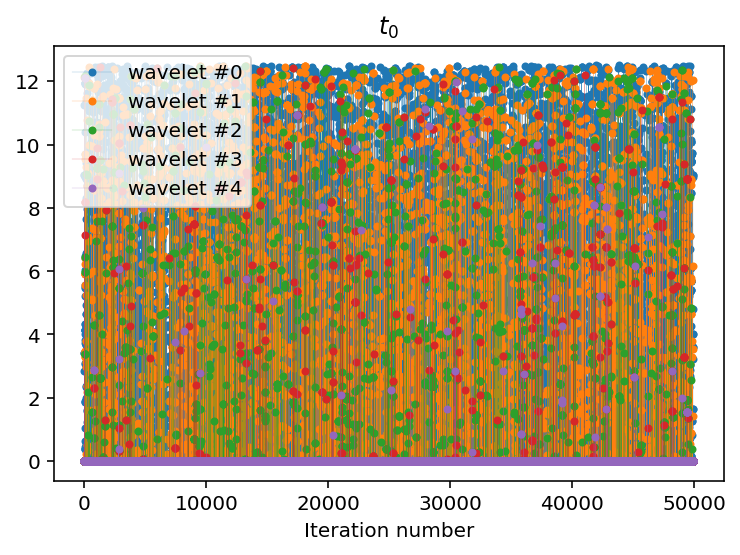

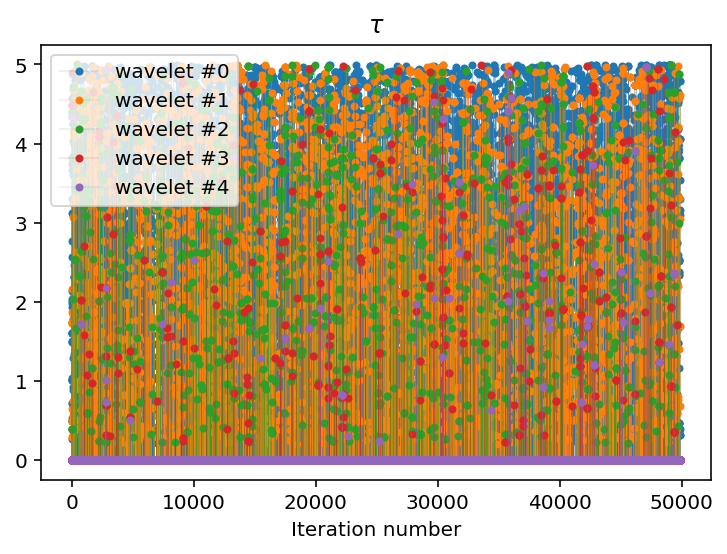

In [24]:
#################################################################
#
# WAVELET PARAMETERS
#
#################################################################

samples_burned = samples[0,::10,:]
#samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)[::]

# Make trace-plot to diagnose sampling
print(samples_burned.shape)
n_wavelet=int(np.nanmax(samples_burned[:,0]))
print(n_wavelet)
labels=[r'$\cos \theta_{\rm GW}$', r'$\psi$', r'$\phi_{\rm GW}$', r'$\log_{10}f_0$', r'$\log_{10}h_+$',
        r'$\log_{10}h_{\times}$', r'$\phi_{0, +}$', r'$\phi_{0, \times}$', r'$t_0$', r'$\tau$']
true_val1 = [x0[key] for key in x0.keys()]
#true_val2 = [x1[key] for key in x1.keys()]
print(true_val1)

for i in range(len(labels)):
    plt.figure(i)
    for j in range(n_wavelet):
        #print(1+n_wavelet*i+j)
        plt.plot(samples_burned[:,2+i+j*10], linestyle = '-', lw=0.1, marker='.', label="wavelet #{0}".format(j))
    plt.title(labels[i])
    plt.xlabel("Iteration number")
    plt.legend()

# GLITCH PARAMETERS

(49900, 84)
5
[  1.           1.          -0.32393308   0.79354059   5.08991679
  -7.88993674  -6.34462951  -9.08647357   3.66710855   3.20244334
   2.83834015   4.57240946   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          -8.02607916  -8.73227216   2.88860892
  42.07109718   7.7319873    2.54658659   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           4.311

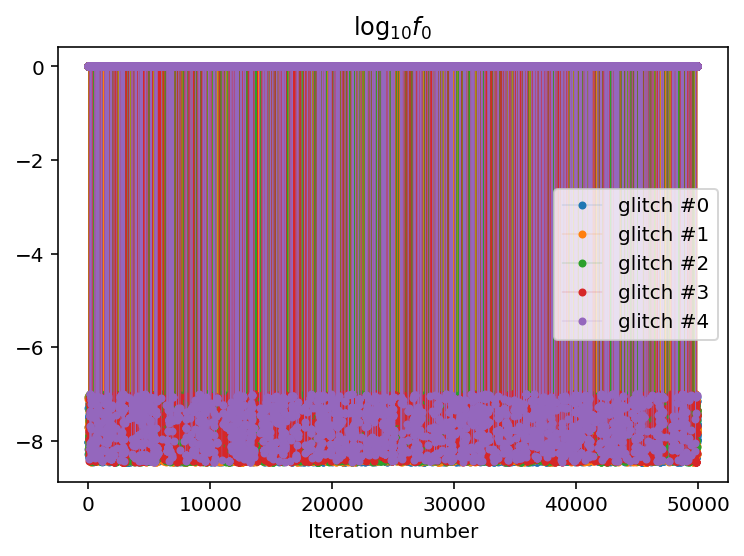

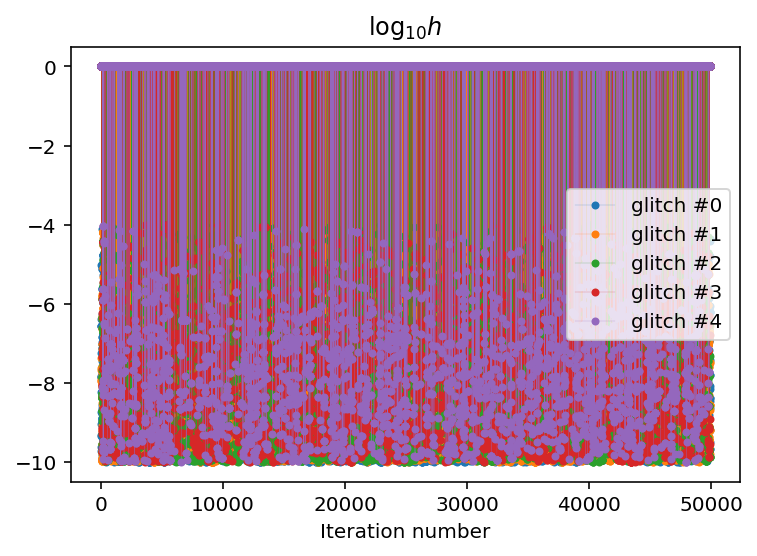

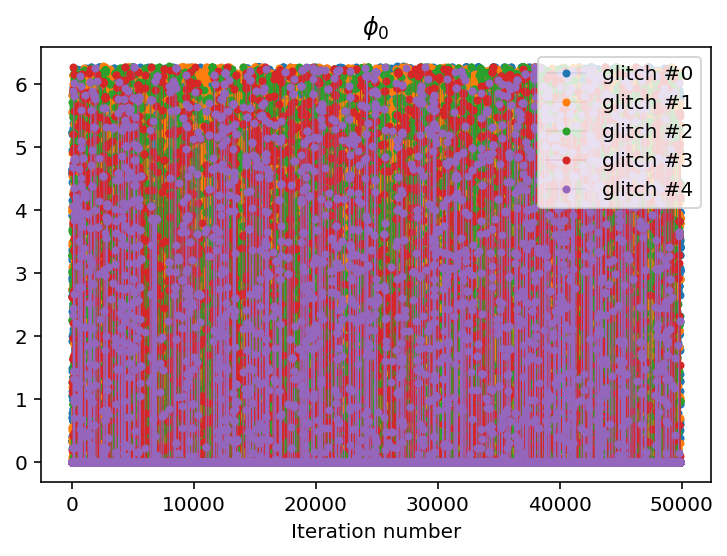

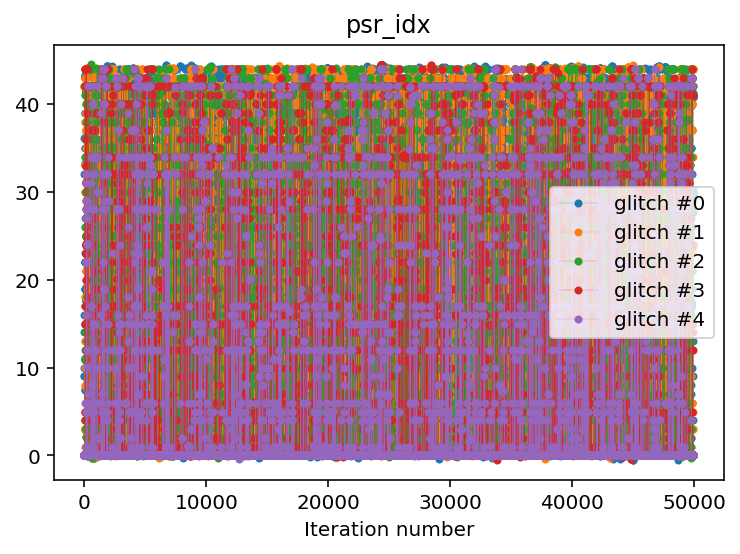

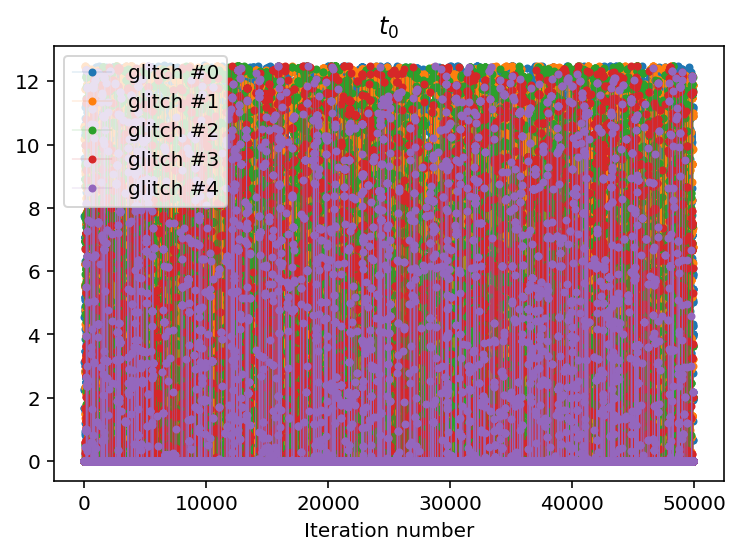

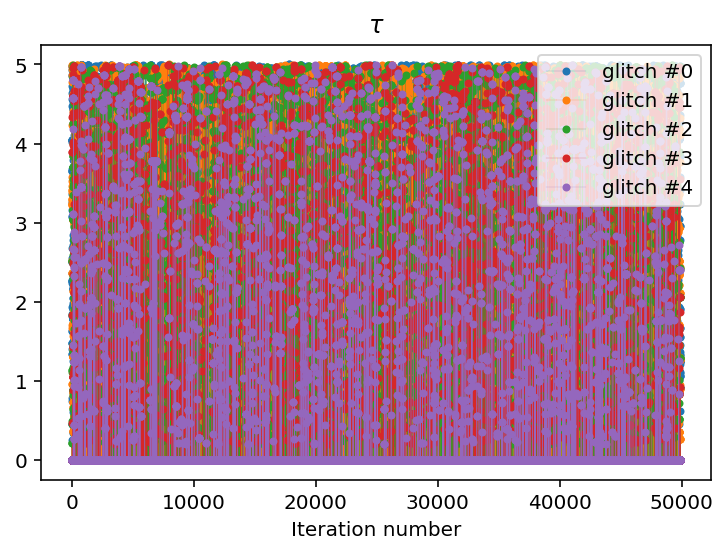

In [27]:
#################################################################
#
# GLITCH PARAMETERS
#
#################################################################

samples_burned = samples[0,::10,:]
#samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)[::]

# Make trace-plot to diagnose sampling

print(samples_burned.shape)
n_glitch=int(np.nanmax(samples_burned[:,1]))
#n_glitch=1
print(n_glitch)
labels=[r'$\log_{10}f_0$', r'$\log_{10}h$', r'$\phi_0$',r'psr_idx', r'$t_0$', r'$\tau$']

max_n_wavelet=5

print(samples_burned[0,:])

for i in range(6):
    plt.figure(i)
    for j in range(n_glitch):
        #print(2+max_n_wavelet*10+6*j+i)
        #print(samples_burned[:,2+max_n_wavelet*8+i+j*6])
        plt.plot(samples_burned[:,2+max_n_wavelet*10+i+j*6], linestyle = '-', lw=0.1, marker='.', label="glitch #{0}".format(j))
    plt.title(labels[i])
    plt.xlabel("Iteration number")
    plt.legend()

# NOISE PARAMETERS

(499000, 84)
45
1.0
[  1.           1.          -0.32393308   0.79354059   5.08991679
  -7.88993674  -6.34462951  -9.08647357   3.66710855   3.20244334
   2.83834015   4.57240946   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          -8.02607916  -8.73227216   2.88860892
  42.07109718   7.7319873    2.54658659   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          

IndexError: index 84 is out of bounds for axis 1 with size 84

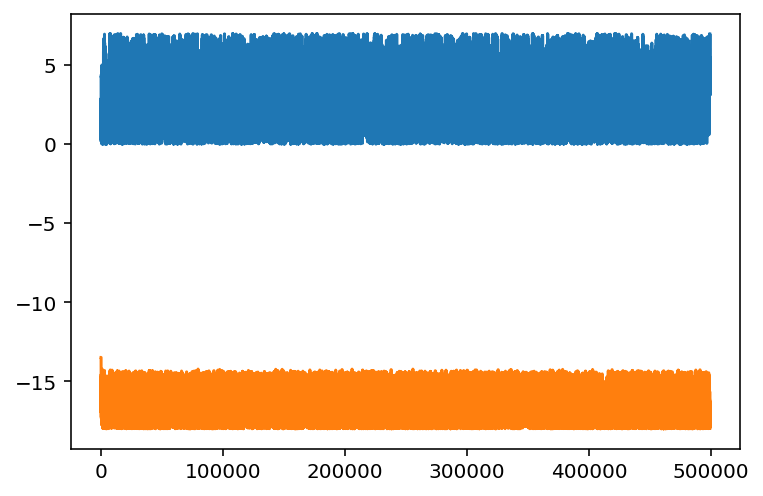

In [28]:
#################################################################
#
# WHITE NOISE PARAMETERS
#
#################################################################

# Make trace-plot to diagnose sampling

samples_burned = samples[0,:,:]
#samples_burned = np.where(samples[1,:,:]!=0.0, samples[0,:,:], np.nan)[::]

print(samples_burned.shape)
n_pulsar=45
max_n_wavelet=5
max_n_glitch=5
print(n_pulsar)

true_val1 = 1.0
prior_upper = 0.01
prior_lower = 10
print(true_val1)

print(samples_burned[0,:])

plt.figure(0)
for j in range(n_pulsar):
    #print(1+max_n_source*7+2*j+i)
    plt.plot(samples_burned[:,2+max_n_wavelet*10+max_n_glitch*6+j], label=str(j))
plt.title('efac')
plt.xlabel("Iteration number")
#plt.gca().axhline(y=prior_upper, linestyle='-', label="Prior boundary")
#plt.gca().axhline(y=prior_lower, linestyle='-')
#plt.gca().axhline(y=true_val1, linestyle='--', label="Injected value")
#plt.gca().axhline(y=true_val2[i], color='r', linestyle='--', label="Injected signal #2")
plt.legend()

(49900, 84)
45
1.0
[  1.           1.          -0.32393308   0.79354059   5.08991679
  -7.88993674  -6.34462951  -9.08647357   3.66710855   3.20244334
   2.83834015   4.57240946   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          -8.02607916  -8.73227216   2.88860892
  42.07109718   7.7319873    2.54658659   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           

IndexError: index 84 is out of bounds for axis 1 with size 84

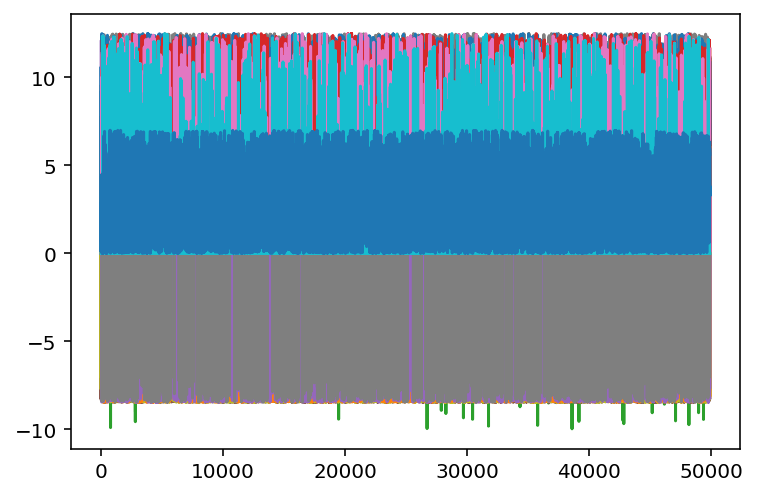

In [29]:
#################################################################
#
# INDIVIDUAL RN PARAMETERS
#
#################################################################

# Make trace-plot to diagnose sampling

samples_burned = samples[0,::10,:]
#samples_burned = np.where(samples[1,:,:]!=0.0, samples[0,:,:], np.nan)[::]

print(samples_burned.shape)
n_pulsar=45
max_n_wavelet=1
max_n_glitch=5
print(n_pulsar)

true_val1 = 1.0
prior_upper = 0.01
prior_lower = 10
print(true_val1)

print(samples_burned[0,:])

plt.figure(0)
for j in range(n_pulsar):
    #print(1+max_n_source*7+2*j+i)
    plt.plot(samples_burned[:,2+max_n_wavelet*10+max_n_glitch*6+2*j], label=str(j))
plt.title('Individual RN gamma')
plt.xlabel("Iteration number")
#plt.gca().axhline(y=prior_upper, linestyle='-', label="Prior boundary")
#plt.gca().axhline(y=prior_lower, linestyle='-')
#plt.gca().axhline(y=true_val1, linestyle='--', label="Injected value")
#plt.gca().axhline(y=true_val2[i], color='r', linestyle='--', label="Injected signal #2")
plt.legend()
#plt.savefig("HyaliteResults/PostProc/2cgw_with_full_sampler/wn_trace_2cgw_with_full_sampler_{0}.pdf".format(i))

plt.figure(1)
for j in range(n_pulsar):
    #print(1+max_n_source*7+2*j+i)
    plt.plot(samples_burned[:,2+max_n_wavelet*10+max_n_glitch*6+1+2*j], label=str(j))
plt.title('Individual RN amplitude')
plt.xlabel("Iteration number")

In [30]:
#################################################################
#
# RED NOISE PARAMETERS
#
#################################################################

samples_burned = samples[0,:,:]
#samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)[::]

true_val1 = [0, -20]
prior_upper = [0, -18]
prior_lower = [7, -17]

num_psrs = 45
max_n_wavelet=1
max_n_glitch=5

plt.figure(1)
plt.plot(samples_burned[:,2+max_n_wavelet*10+max_n_glitch*6+2*num_psrs], label="com_rn_gamma")
#plt.gca().axhline(y=true_val1[0], linestyle='--', label="Injected value")
plt.gca().axhline(y=prior_upper[0], linestyle='--', label="Prior boundary")
plt.gca().axhline(y=prior_lower[0], linestyle='--')
plt.xlabel("Iteration number")
#plt.xlim((0,len(samples_burned[:,0])))
plt.legend()
#plt.savefig("HyaliteResults/PostProc/gwb_only_with_full_sampler/gwb_trace_gwb_only_with_full_sampler.pdf")
#plt.savefig("HyaliteResults/PostProc/2cgw_with_full_sampler/gwb_trace_2cgw_with_full_sampler.pdf")
#plt.savefig("HyaliteResults/PostProc/gwb_plus_2cgw_with_full_sampler/gwb_trace_gwb_plus_2cgw_with_full_sampler.pdf")

plt.figure(2)
plt.plot(10**samples_burned[:,2+max_n_wavelet*10+max_n_glitch*6+2*num_psrs+1], ls='', marker='.', label="com_rn_A")
#plt.gca().axhline(y=10**true_val1[1], linestyle='--', label="Injected value")
plt.gca().axhline(y=10**prior_upper[1], linestyle='--', label="Prior boundary")
plt.gca().axhline(y=10**prior_lower[1], linestyle='--')
plt.xlabel("Iteration number")
#plt.xlim((0,len(samples_burned[:,0])))
#plt.ylim((8e-14,9e-14))
plt.legend()
#plt.savefig("HyaliteResults/PostProc/gwb_only_with_full_sampler/gwb_trace_gwb_only_with_full_sampler.pdf")
#plt.savefig("HyaliteResults/PostProc/2cgw_with_full_sampler/gwb_trace_2cgw_with_full_sampler.pdf")

IndexError: index 132 is out of bounds for axis 1 with size 84

<Figure size 432x288 with 0 Axes>

# NUMBER OF WAVELETS HISTOGRAM

5
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
489000
[69.87361963 20.91042945  6.49856851  1.97811861  0.5799591   0.1593047 ]
[0.00378009 0.00206789 0.0011528  0.00063602 0.00034439 0.00018049]
[5.40989642e-05 9.88926681e-05 1.77393099e-04 3.21528449e-04
 5.93809152e-04 1.13300355e-03]
best prior would have been: n_source_prior=  [ 0.0487783   0.162996    0.52447186  1.72300906  5.87682181 21.39495079]


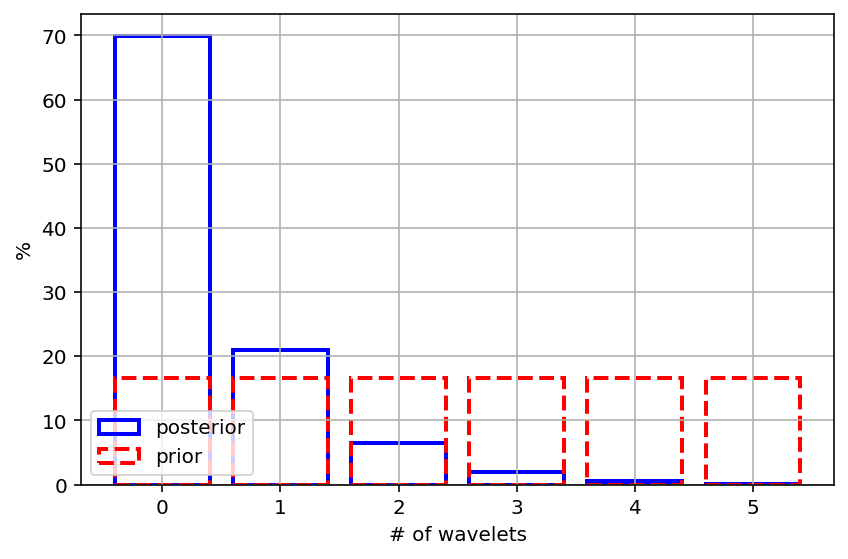

In [31]:
#################################################################
#
# NUMBER OF WAVELETS HISTOGRAM
#
#################################################################

#do not replace 0s with nans in this case
burnin = 10_000
samples_burned = samples[0,burnin:,:]

max_corr_l=0.001

print(int(np.nanmax(samples_burned[:,0])))
#bins = np.arange(-1,int(np.nanmax(samples_burned[:,0]))+1) + 0.5
########################################
min_n = 0
max_n = 5
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5
print(bins)
N = np.shape(samples_burned[:,0])[0]
print(N)
hist, bin_edges = np.histogram(samples_burned[:,0], bins)
print(hist/N*100)
poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100
print(poisson_error)
plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')

bin_edges_signal = bin_edges
hist_signal = hist

########################################
n_source_prior = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior')

plt.legend(loc=3)
#plt.yscale('log', nonposy='clip')
plt.xlabel("# of wavelets")
plt.ylabel("%")

plt.xticks(np.arange(min_n, max_n+1, step=1.0))

bayes_factor = hist[1]/hist[0]*n_source_prior[0]/n_source_prior[1] #compensating for our non-uniform prior

print(poisson_error/(hist/N*100))

bf_error = np.sum(poisson_error/(hist/N*100))*bayes_factor

print("best prior would have been: n_source_prior= ",1/hist*prior_hist*1000)

#plt.text(0.65,60,r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error), fontdict={'size':10})
#plt.title(r'$B_{{\rm CW}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error))

#plt.axhline(y=100.0/np.max(samples_burned[:,0]), color='r')
#plt.ylim((20,30))
#plt.xlim((0.5,3.0))
plt.grid(which='both')
plt.tight_layout()
#plt.savefig("Plots/wavelet_hist_single_low_amp_wavelet_and_very_low_glitch_in_psr0.pdf")
#plt.savefig("Plots/wavelet_hist_single_medium_amp_wavelet_and_low_glitch_in_psr0.pdf")
#plt.savefig("Plots/wavelet_hist_low_amp_wnb.pdf")

# NUMBER OF GLITCHES HISTOGRAM

5
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
489000
[30.35010225 22.01104294 17.75173824 12.30695297 10.75132924  6.82883436]
[0.0024913  0.00212161 0.00190531 0.00158643 0.00148278 0.00118173]
[8.20853192e-05 9.63885084e-05 1.07330988e-04 1.28905159e-04
 1.37915948e-04 1.73050270e-04]
best prior would have been: n_source_prior=  [0.11229999 0.15484574 0.19199902 0.27694234 0.31701348 0.4991066 ]


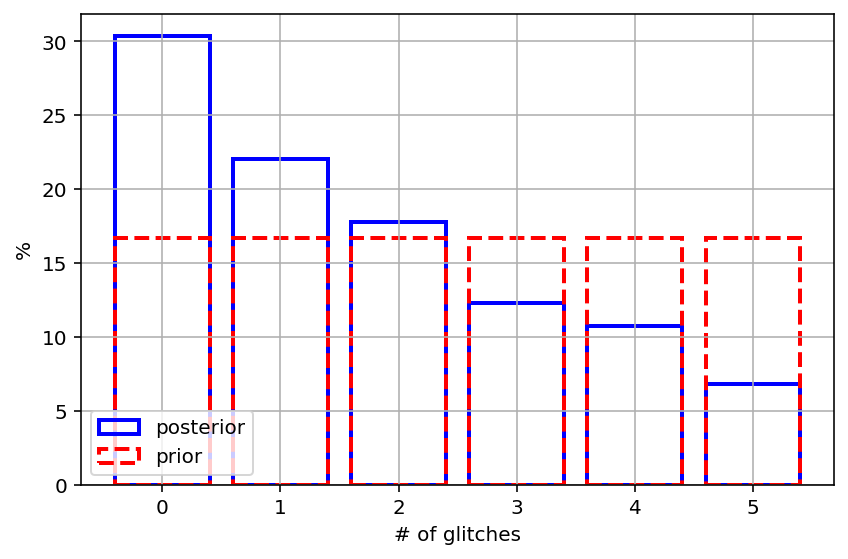

In [32]:
#################################################################
#
# NUMBER OF GLITCHES HISTOGRAM
#
#################################################################

#do not replace 0s with nans in this case
burnin = 10_000
samples_burned = samples[0,burnin:,:]

max_corr_l=0.001

print(int(np.nanmax(samples_burned[:,1])))
#bins = np.arange(-1,int(np.nanmax(samples_burned[:,0]))+1) + 0.5
########################################
min_n = 0
max_n = 5
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5
print(bins)
N = np.shape(samples_burned[:,1])[0]
print(N)
hist, bin_edges = np.histogram(samples_burned[:,1], bins)
print(hist/N*100)
poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100
print(poisson_error)
plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')

bin_edges_glitch = bin_edges
hist_glitch = hist

########################################
n_source_prior = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
#n_source_prior = np.ones(25+1)
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior')

plt.legend(loc=3)
#plt.yscale('log', nonposy='clip')
plt.xlabel("# of glitches")
plt.ylabel("%")

plt.xticks(np.arange(min_n, max_n+1, step=1.0))

bayes_factor = hist[1]/hist[0]*n_source_prior[0]/n_source_prior[1] #compensating for our non-uniform prior

print(poisson_error/(hist/N*100))

bf_error = np.sum(poisson_error/(hist/N*100))*bayes_factor

print("best prior would have been: n_source_prior= ",1/hist*prior_hist*1000)

#plt.text(0.65,60,r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error), fontdict={'size':10})
#plt.title(r'$B_{{\rm CW}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error))

#plt.axhline(y=100.0/np.max(samples_burned[:,0]), color='r')
#plt.ylim((20,30))
#plt.xlim((0.5,3.0))
plt.grid(which='both')
plt.tight_layout()
#plt.savefig("Plots/glitch_hist_single_low_amp_wavelet_and_very_low_glitch_in_psr0.pdf")
#plt.savefig("Plots/glitch_hist_single_medium_amp_wavelet_and_low_glitch_in_psr0.pdf")
#plt.savefig("Plots/glitch_hist_low_amp_wnb.pdf")

# BAYESOGRAMS

(489, 84)
[119, 296, 57, 62, 165, 109, 223, 62, 107, 58, 79, 237, 144, 62, 34, 195, 195, 166, 163, 218, 493, 71, 65, 223, 108, 85, 67, 75, 345, 81, 41, 226, 58, 65, 166, 66, 39, 132, 184, 68, 38, 39, 45, 107, 181]
493
(489, 45, 493)
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-5.478940980241274 5.703319587781957


/tmp/ipykernel_305840/3445135310.py:159: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  injected_data = T2.tempopulsar(parfile = parfiles[idx], timfile = timfiles[idx], maxobs=30000,


0.9833333333333344 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-6.818402905600436 8.349655167706612
0.9833333333333344 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-13.98631653621943 10.048336731525863
0.9833333333333344 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-0.8831334829504777 0.910095758538986
0.983333333333333 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-1.4313950024044164 1.8314774967426315
0.9833333333333316 0.9379629629629629
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-2.5474302461654985 2.72712676772092
0.9833333333333316 0.9379629629629629
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-1.1912721106843078 2.508641946915779
0.9833333333333316 0.9379629629629629
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-2.083646410408449 1.5642657915430283
0.9833333333333316 0.9379629629629629
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-5.02096

/tmp/ipykernel_305840/3445135310.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(num=idx, figsize=(9,6))


-1.6182192475522643 4.168761641799358
0.9833333333333316 0.9379629629629627
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-1.2979525719374214 1.642348085456947
0.9833333333333316 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-0.570245254188538 0.7404743377659607
0.983333333333333 0.9379629629629629
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-5.47404749098191 2.3672750020407562
0.983333333333333 0.937962962962963
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-21.97821549625772 24.56927329585785
0.9833333333333344 0.937962962962963
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-10.672900782200536 4.491506348263511
0.9833333333333344 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-1.7736820346353313 1.755310696907878
0.9833333333333316 0.9379629629629628
Figure(648x432) AxesSubplot(0.125,0.125;0.775x0.755)
-17.42895265213106 14.243021928452416
0.9833333333333344 0.9379629629629628
Figure(648x432) AxesSubplot

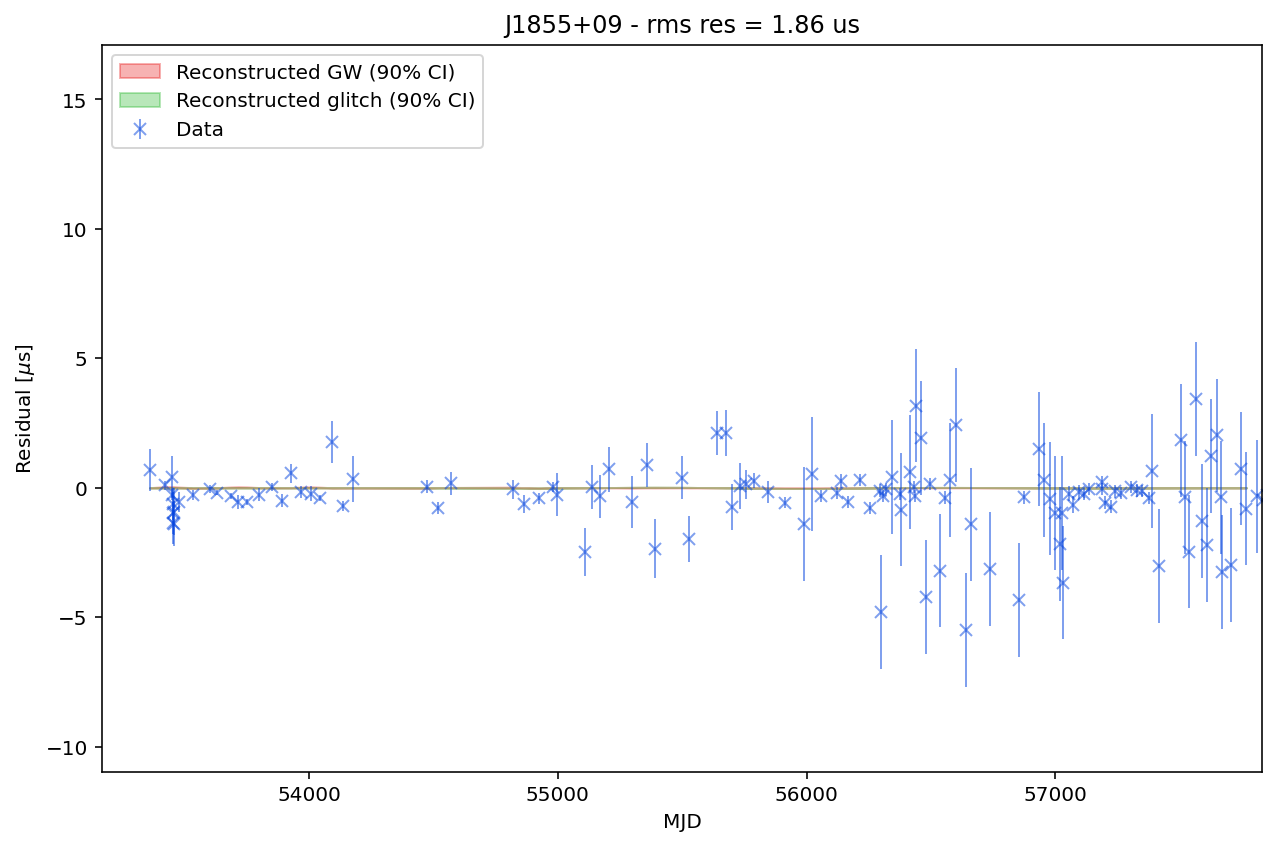

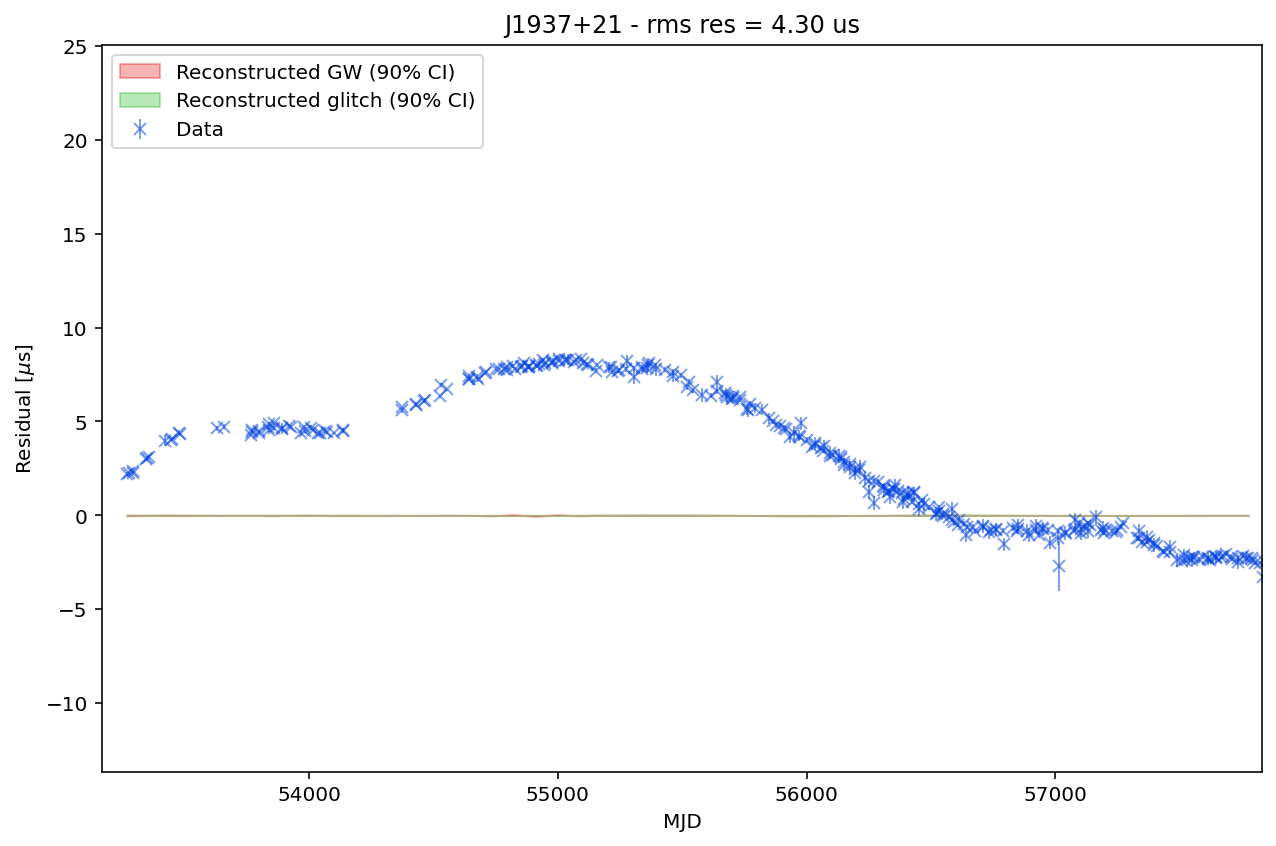

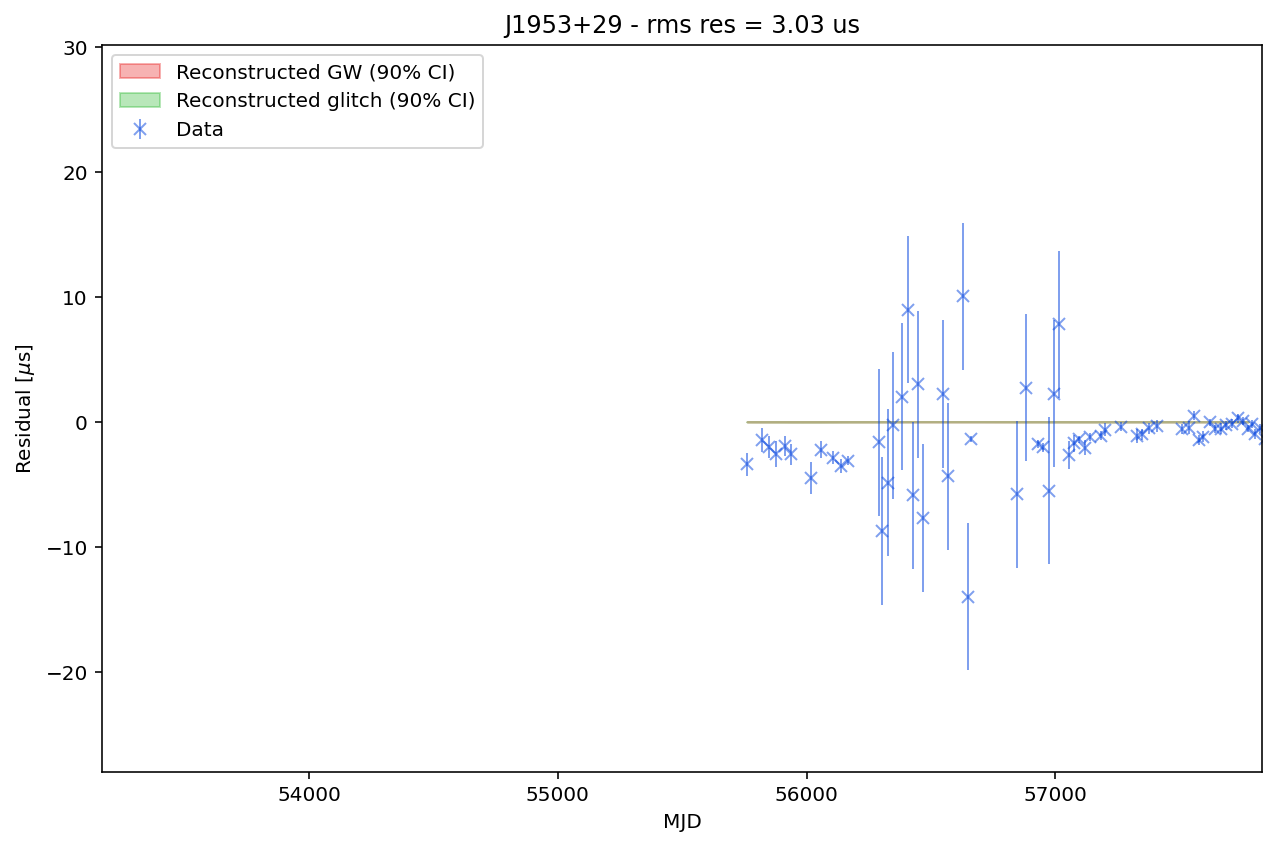

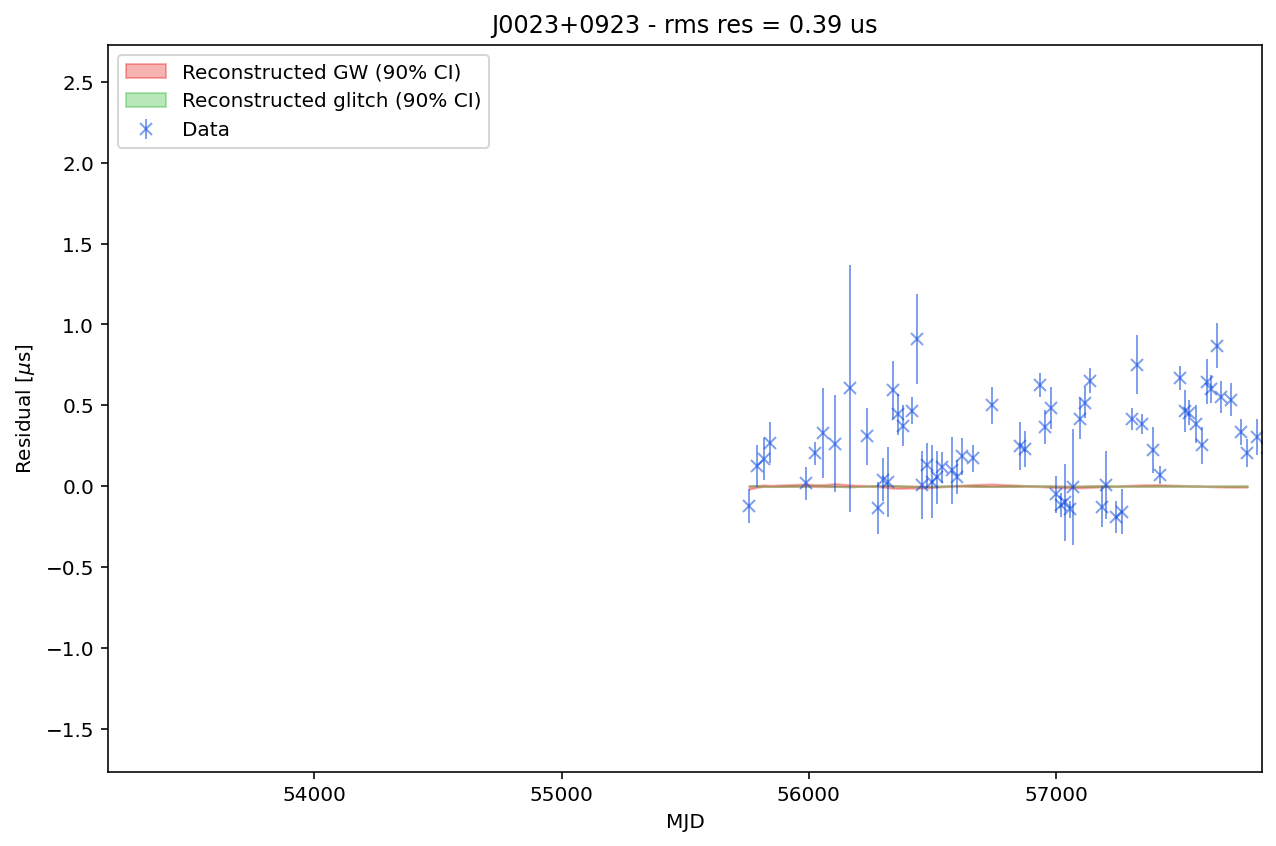

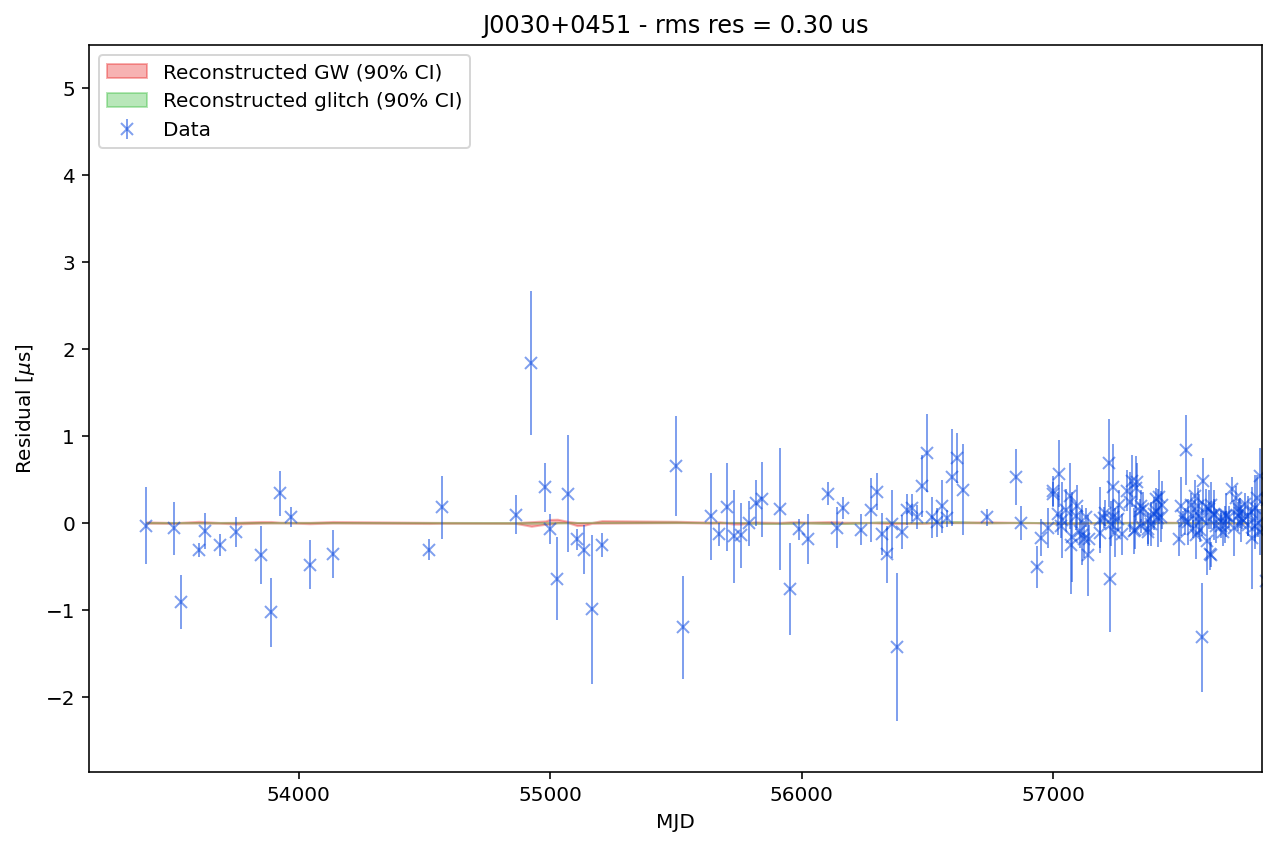

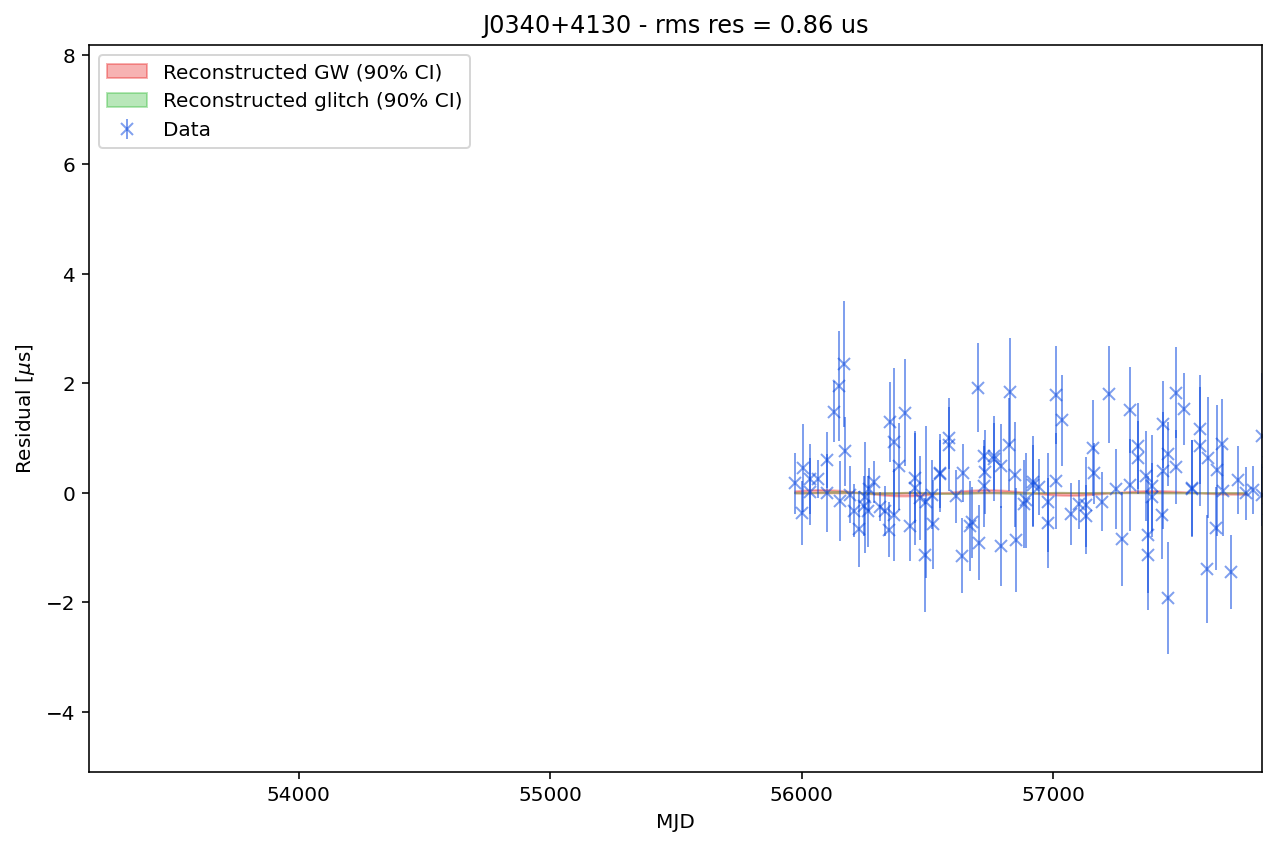

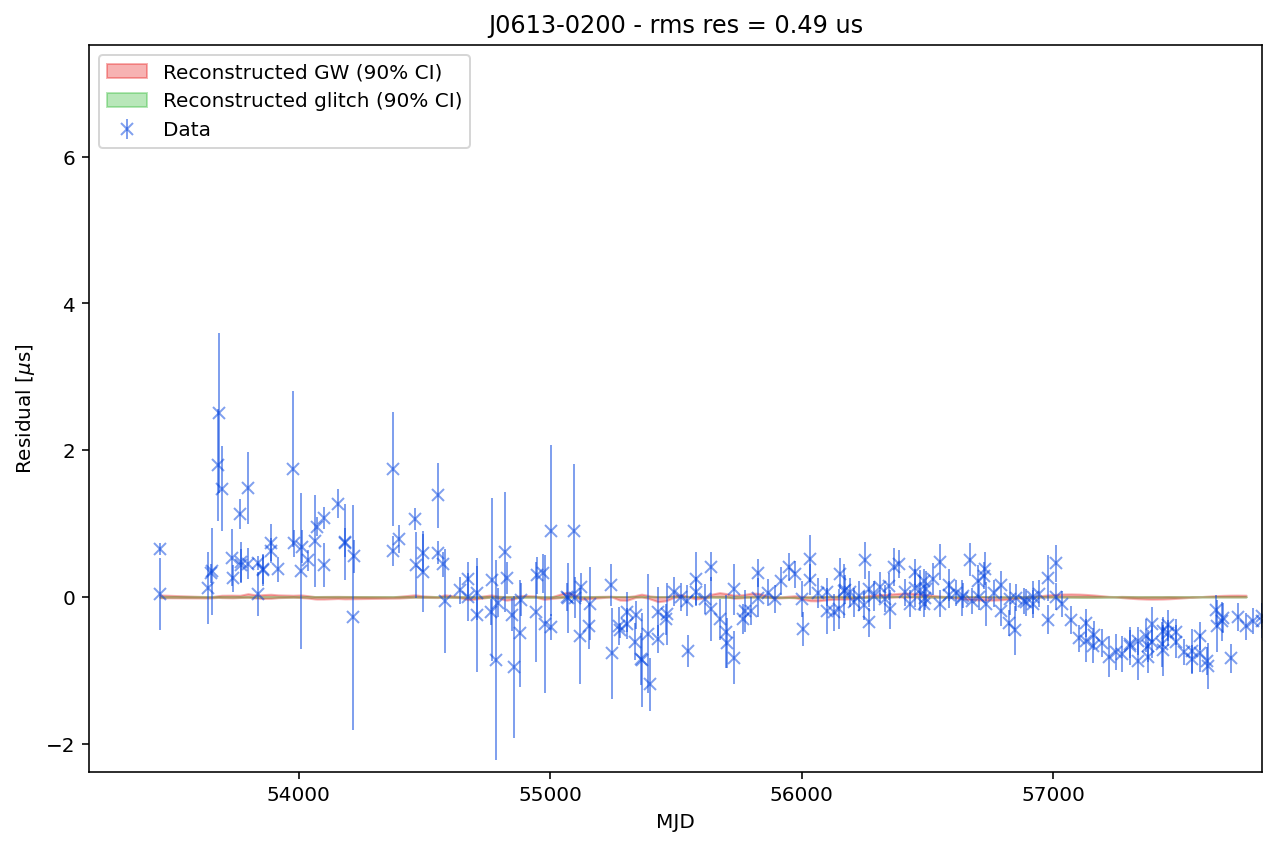

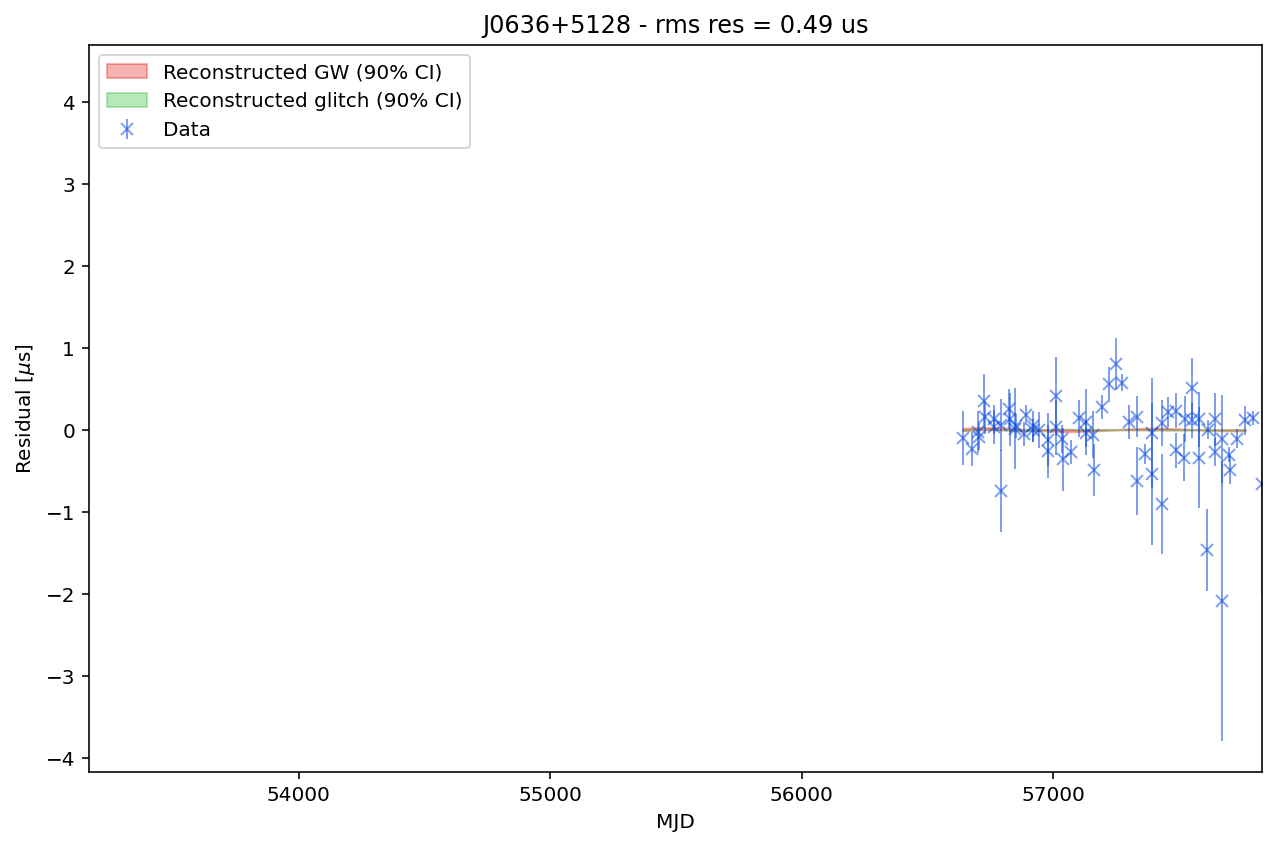

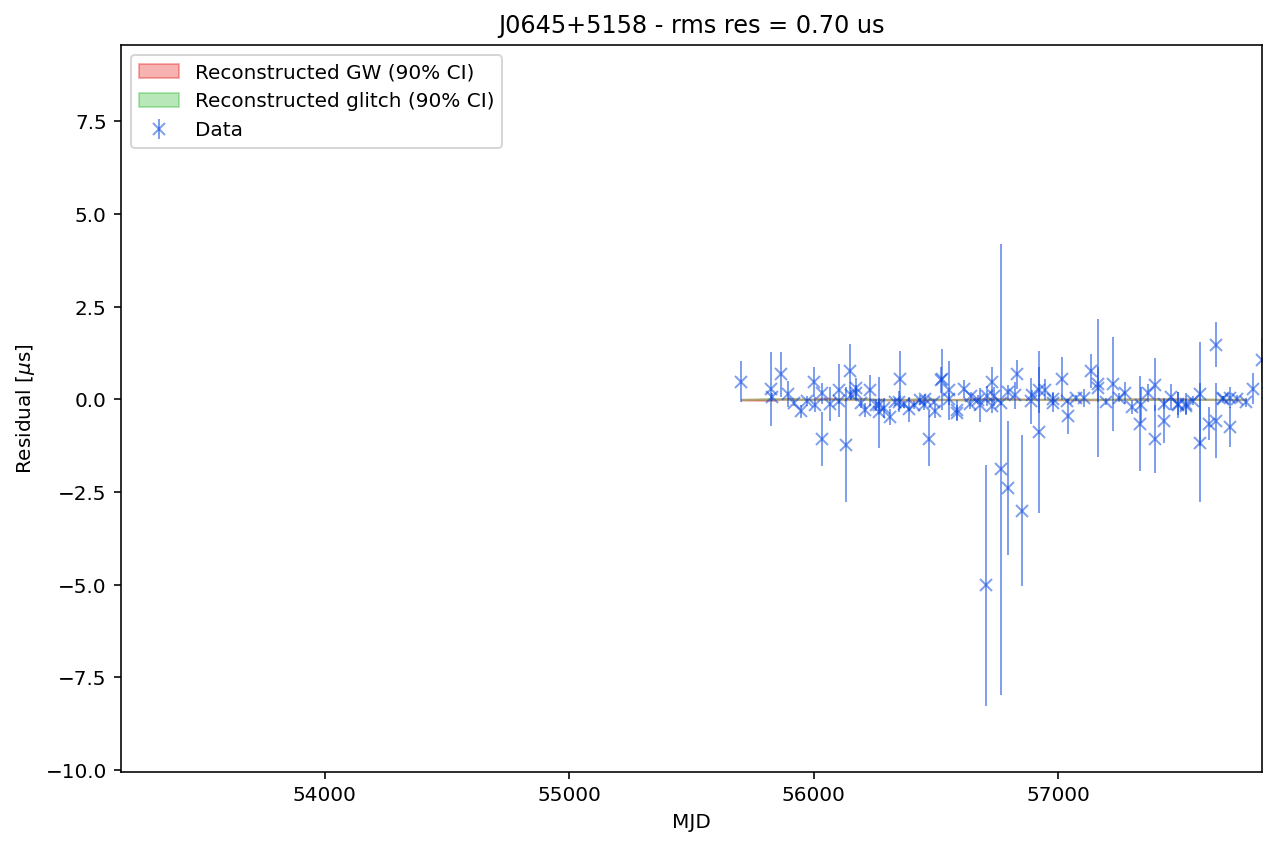

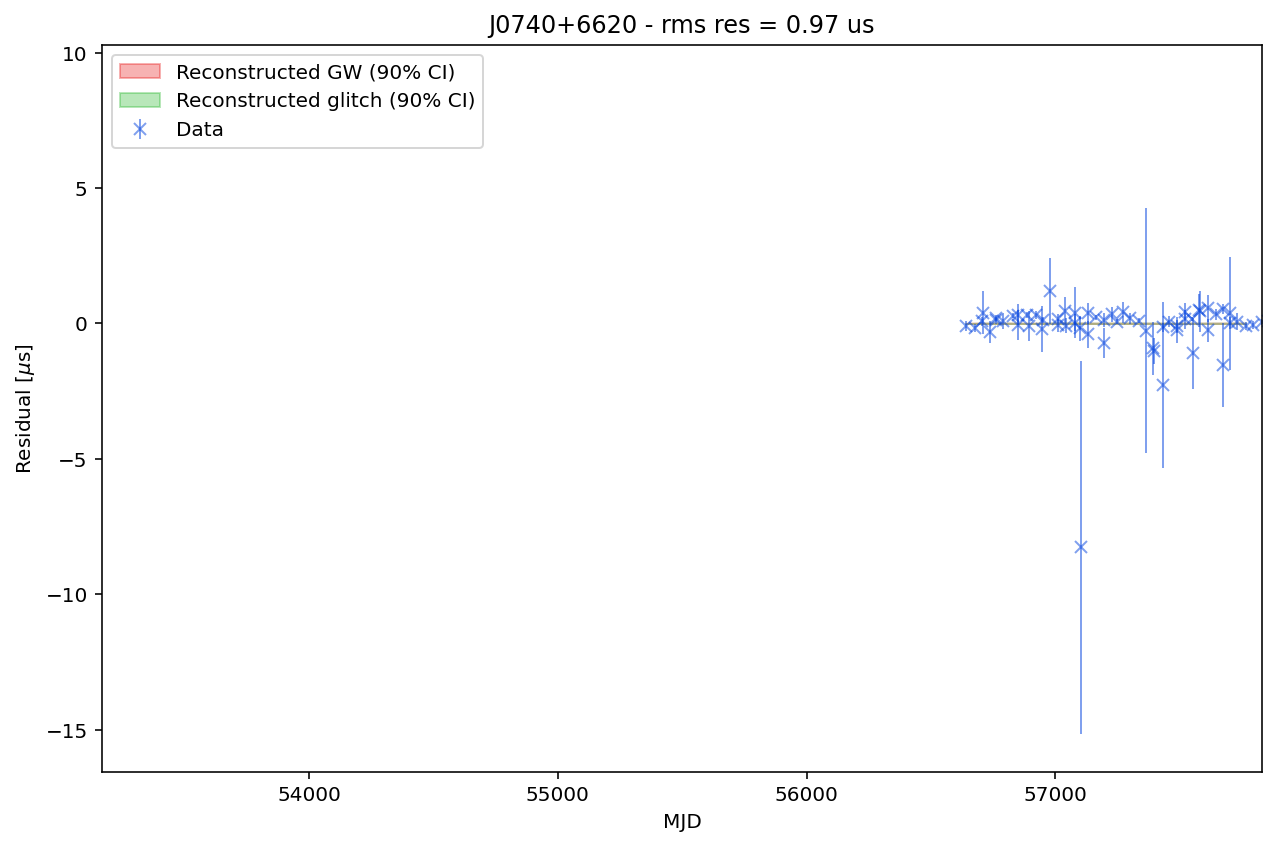

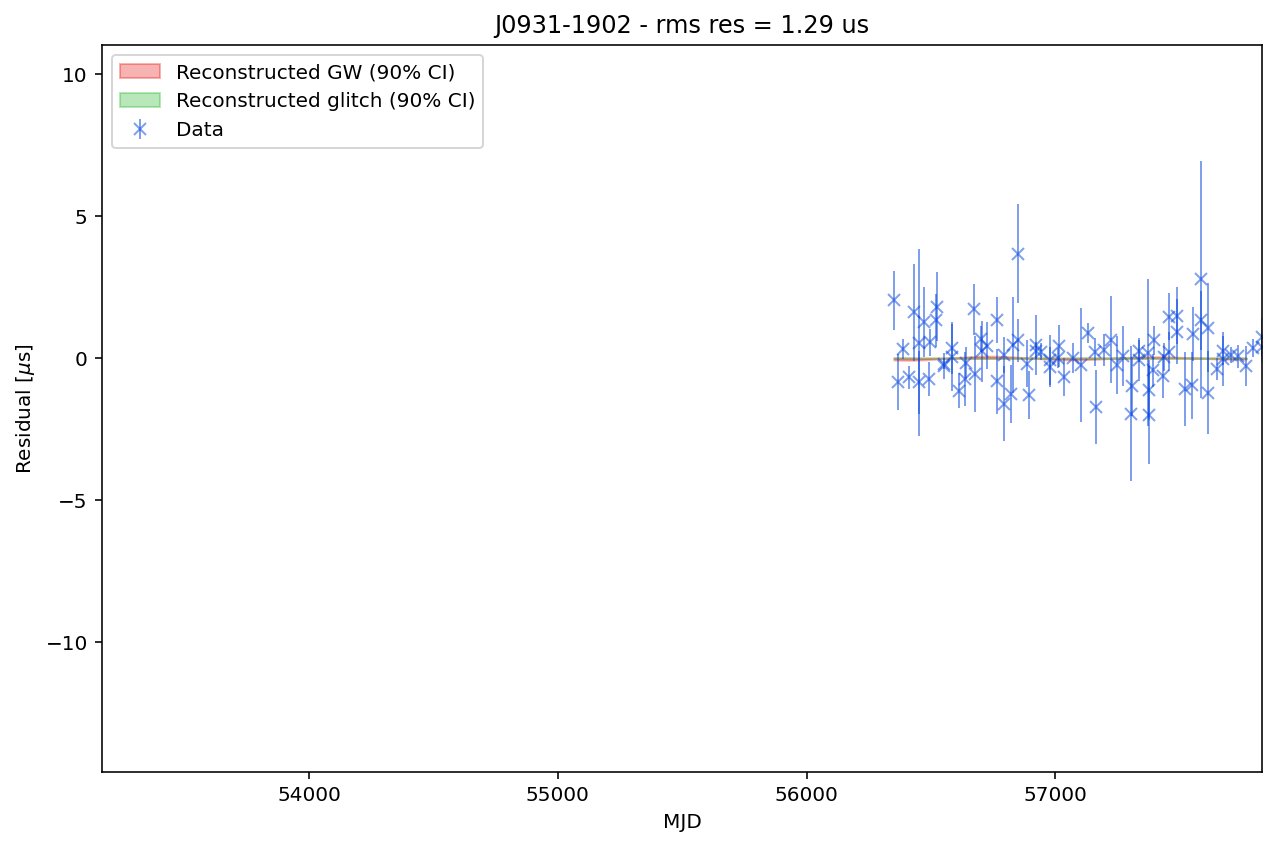

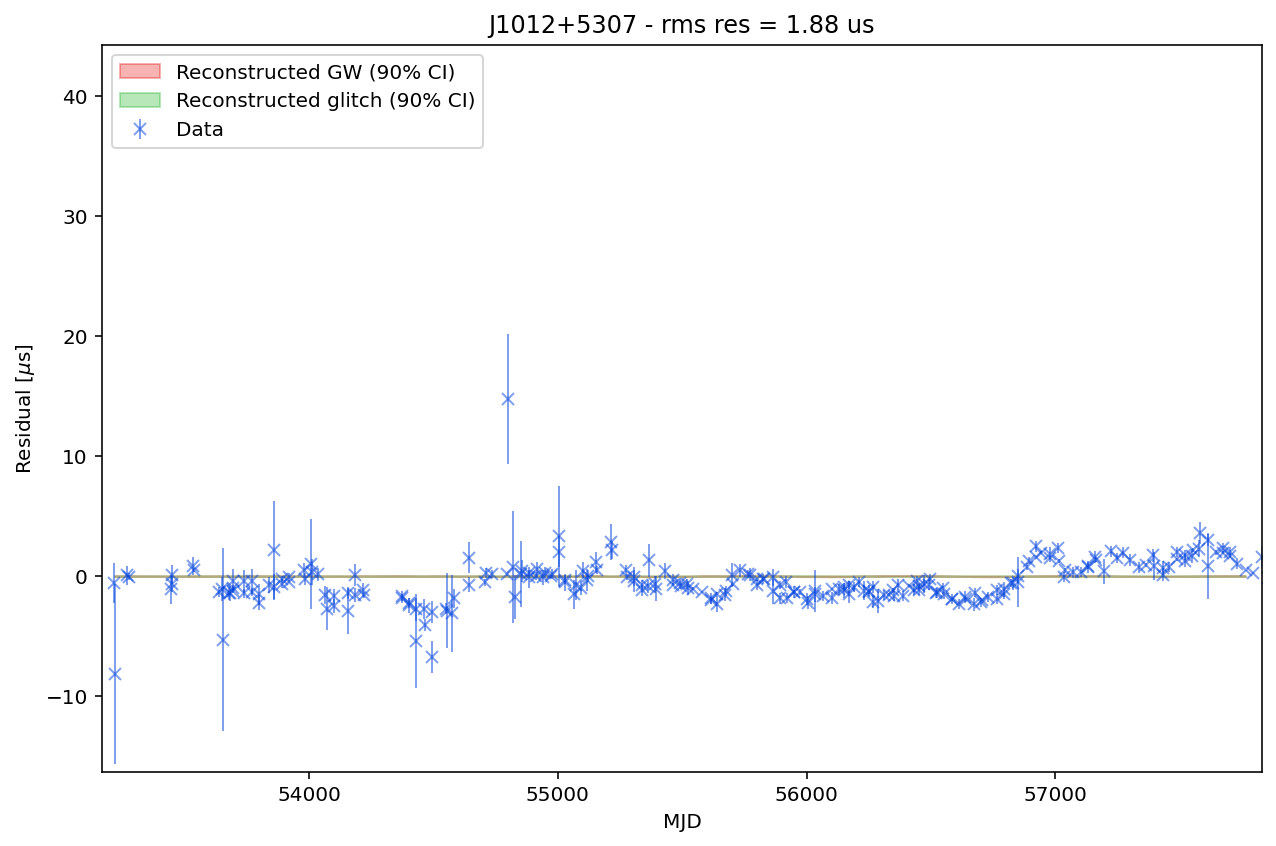

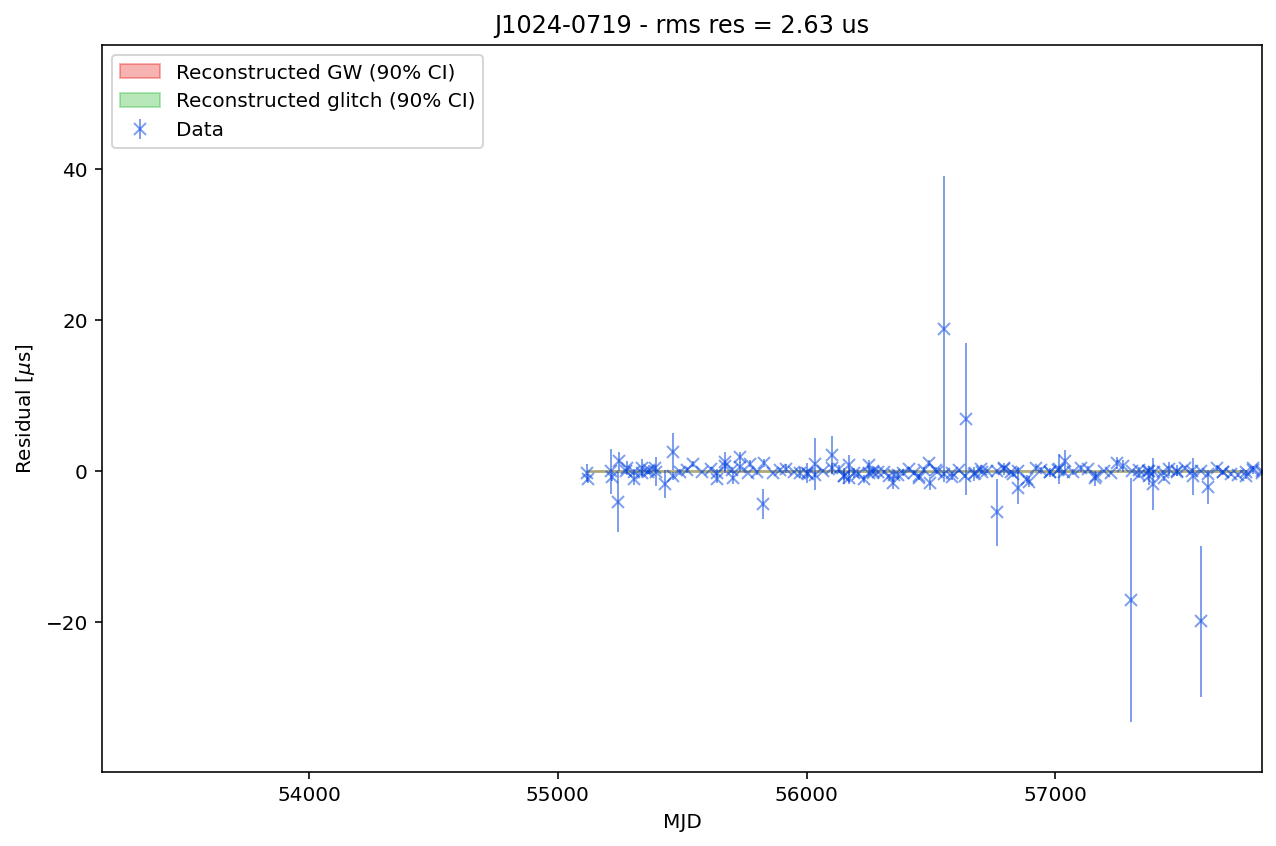

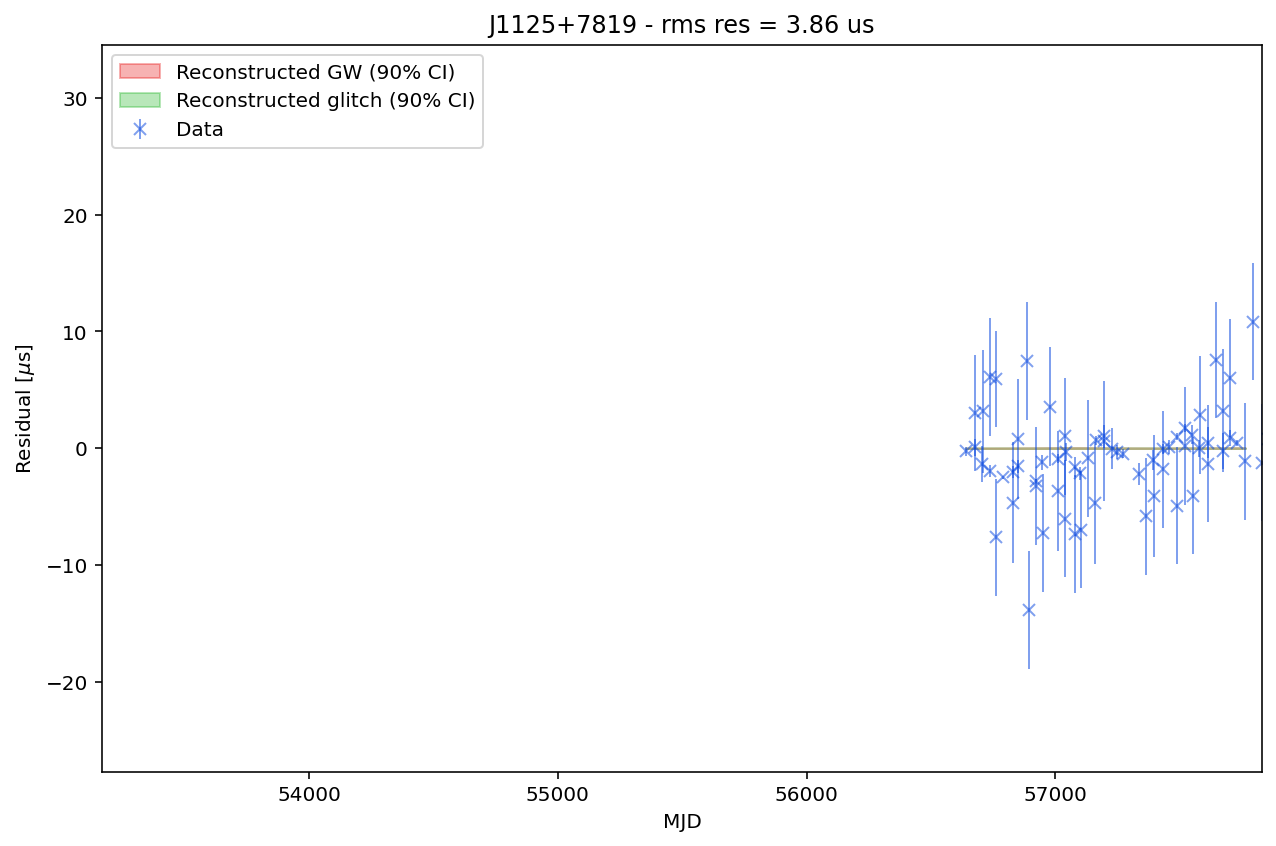

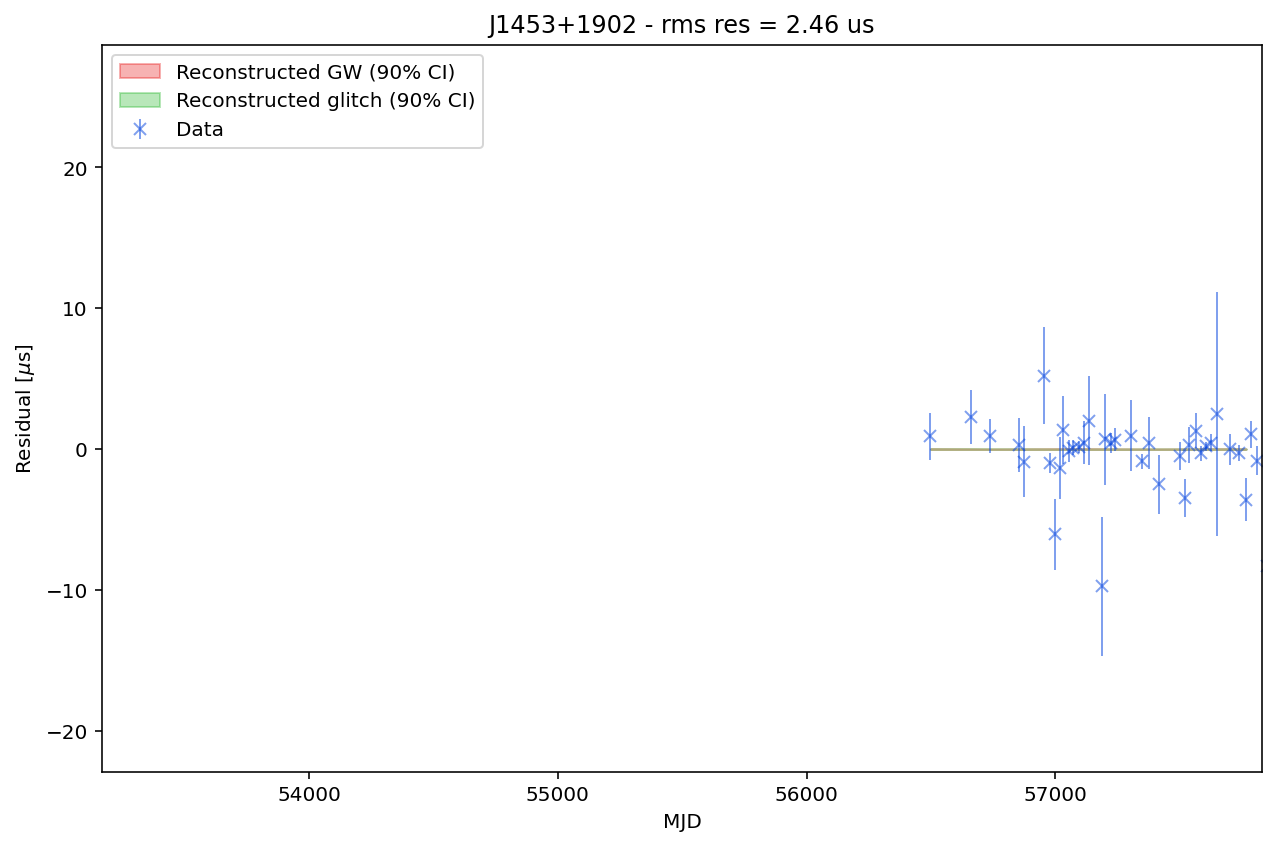

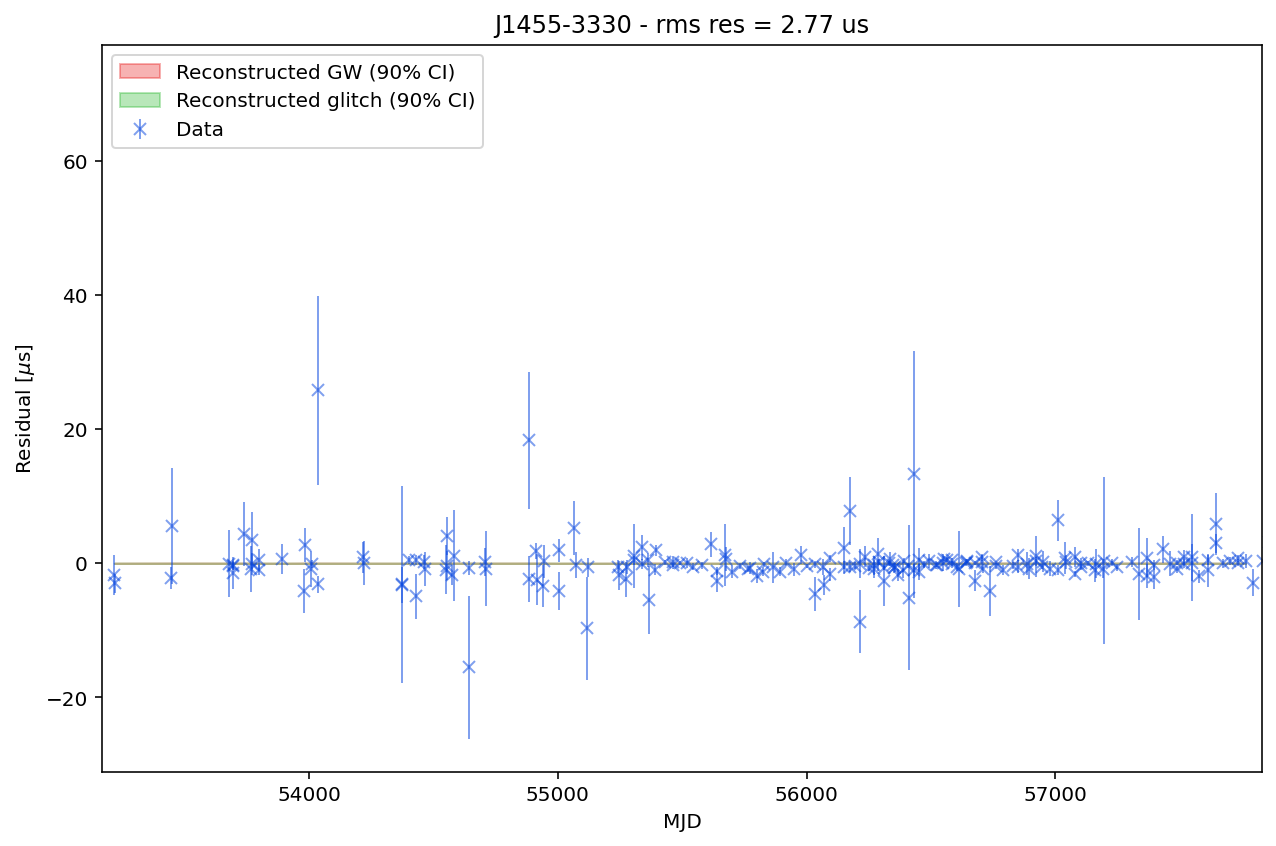

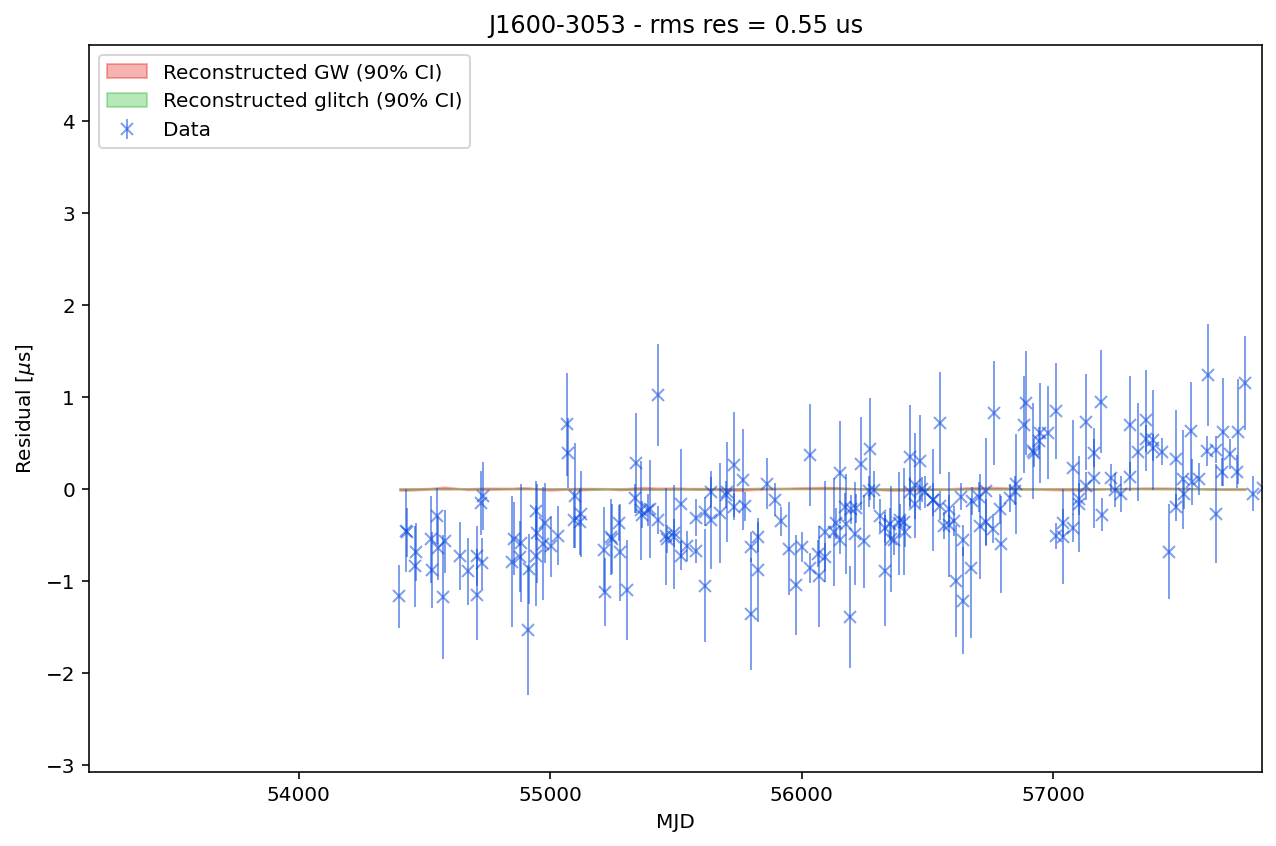

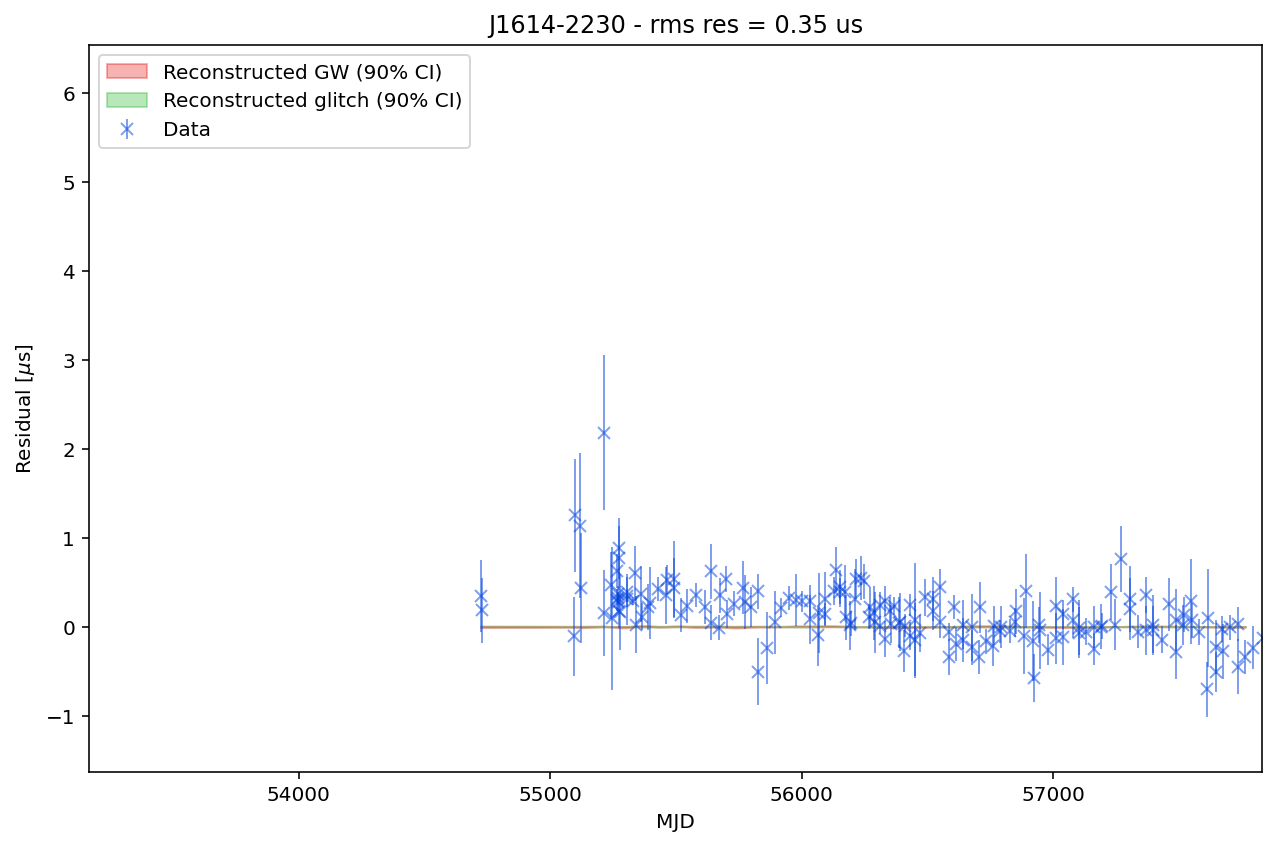

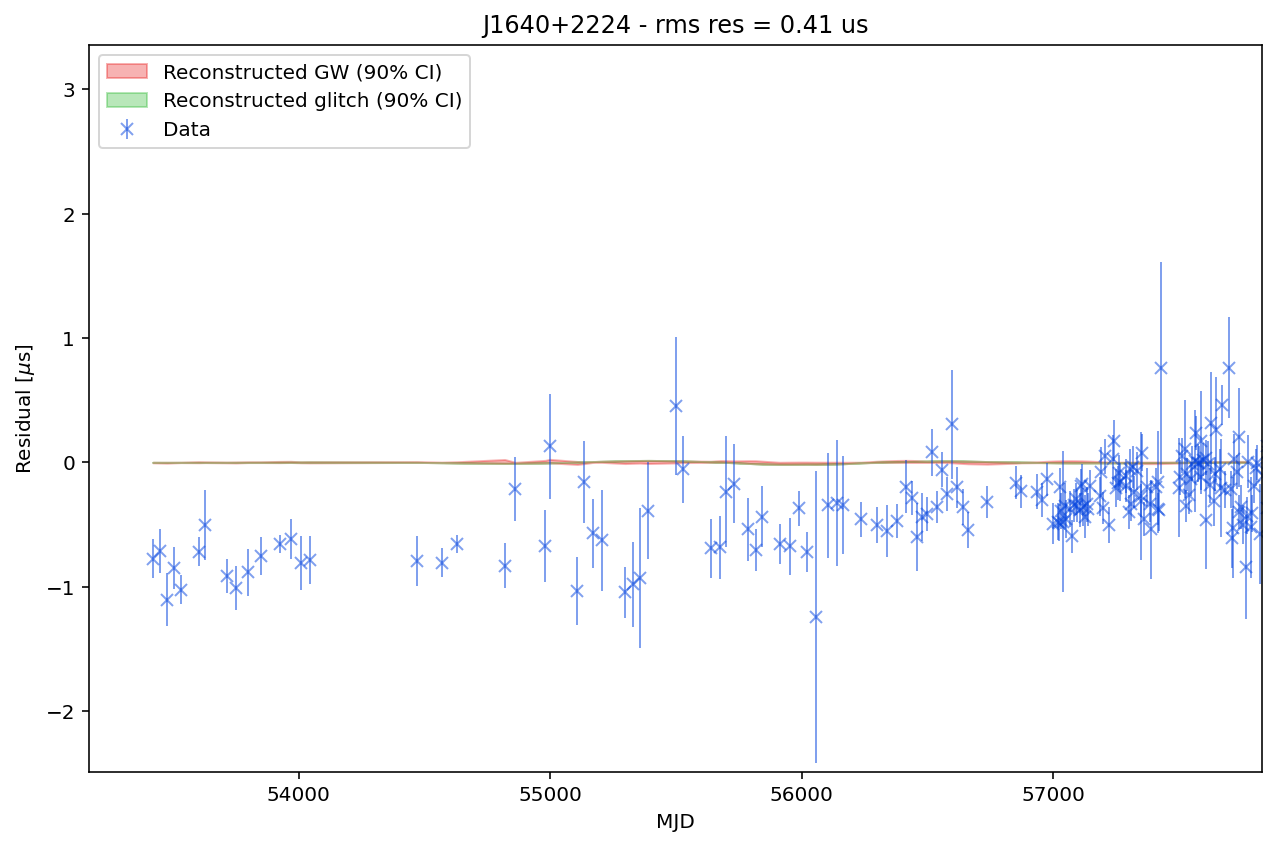

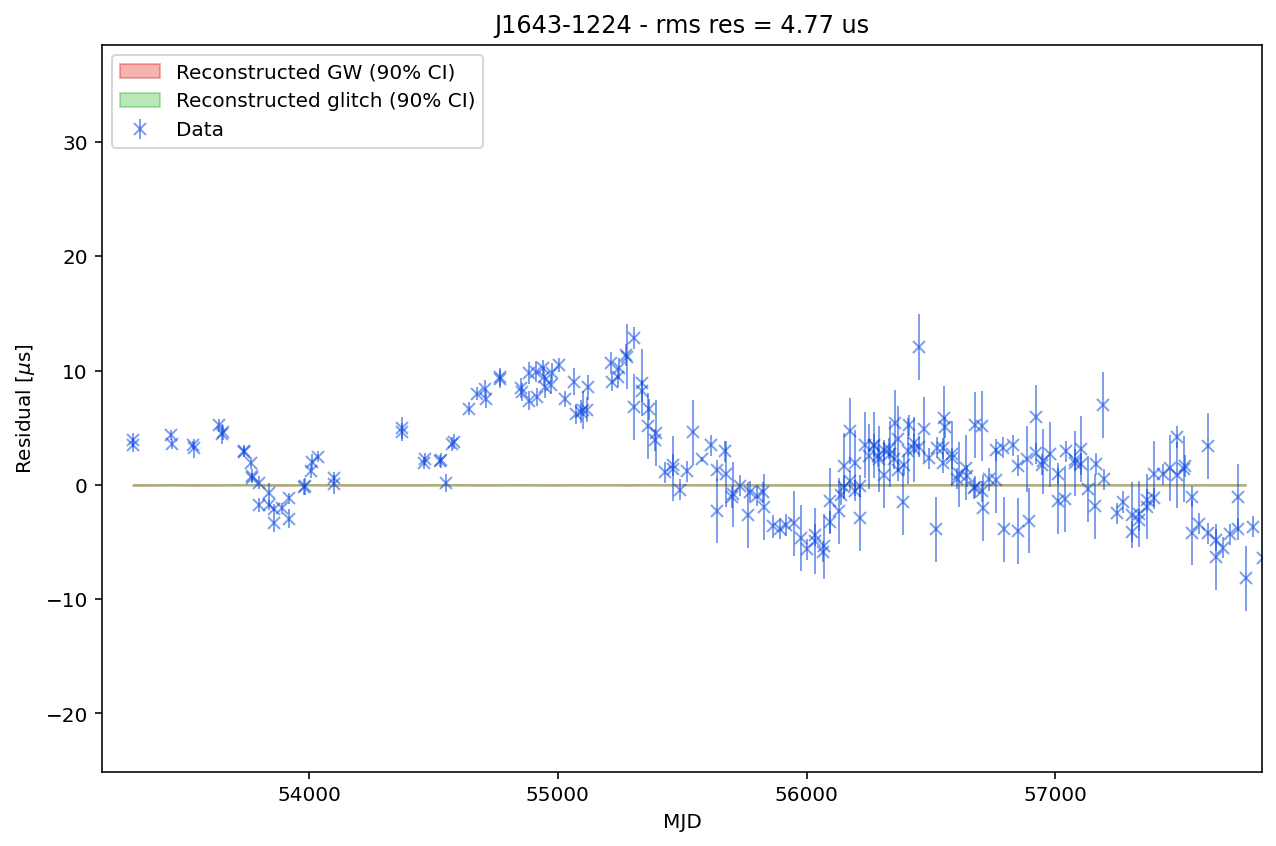

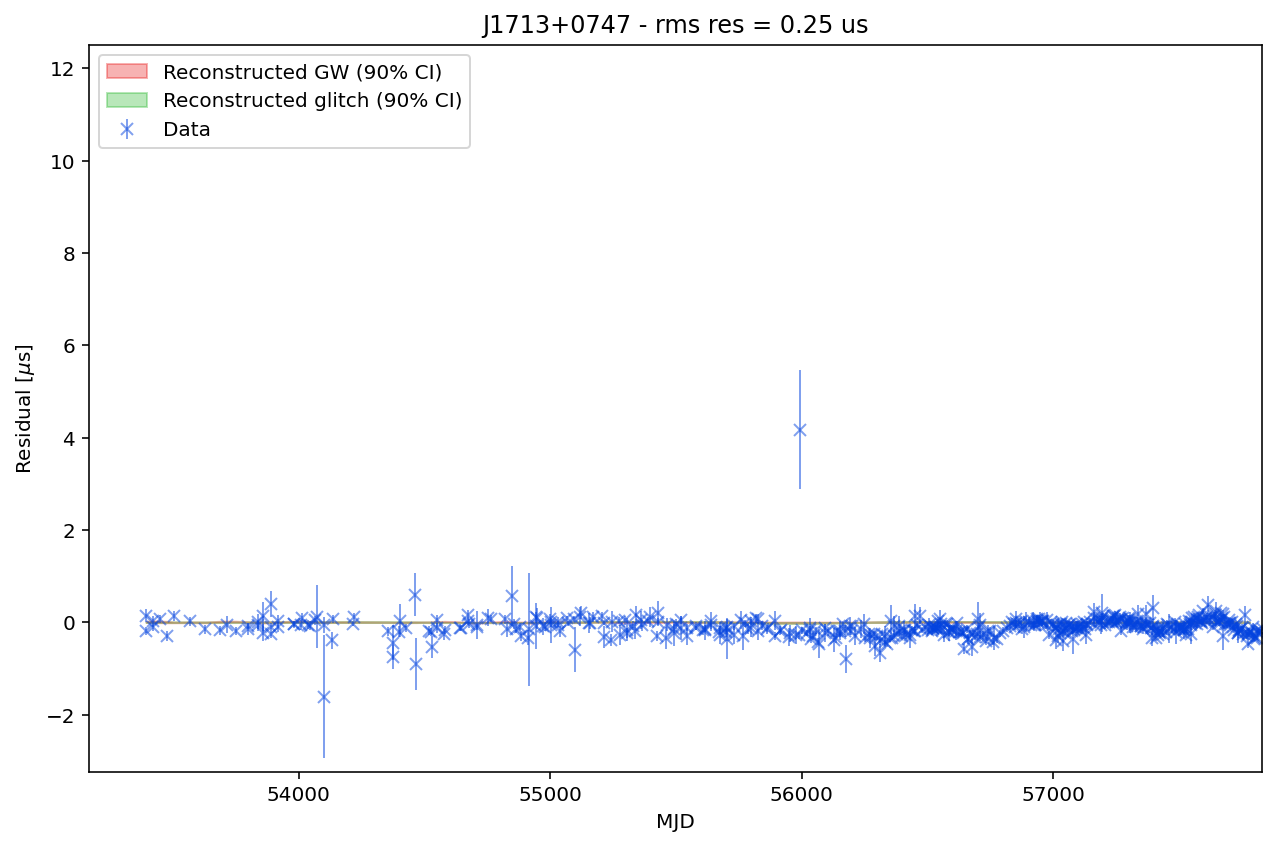

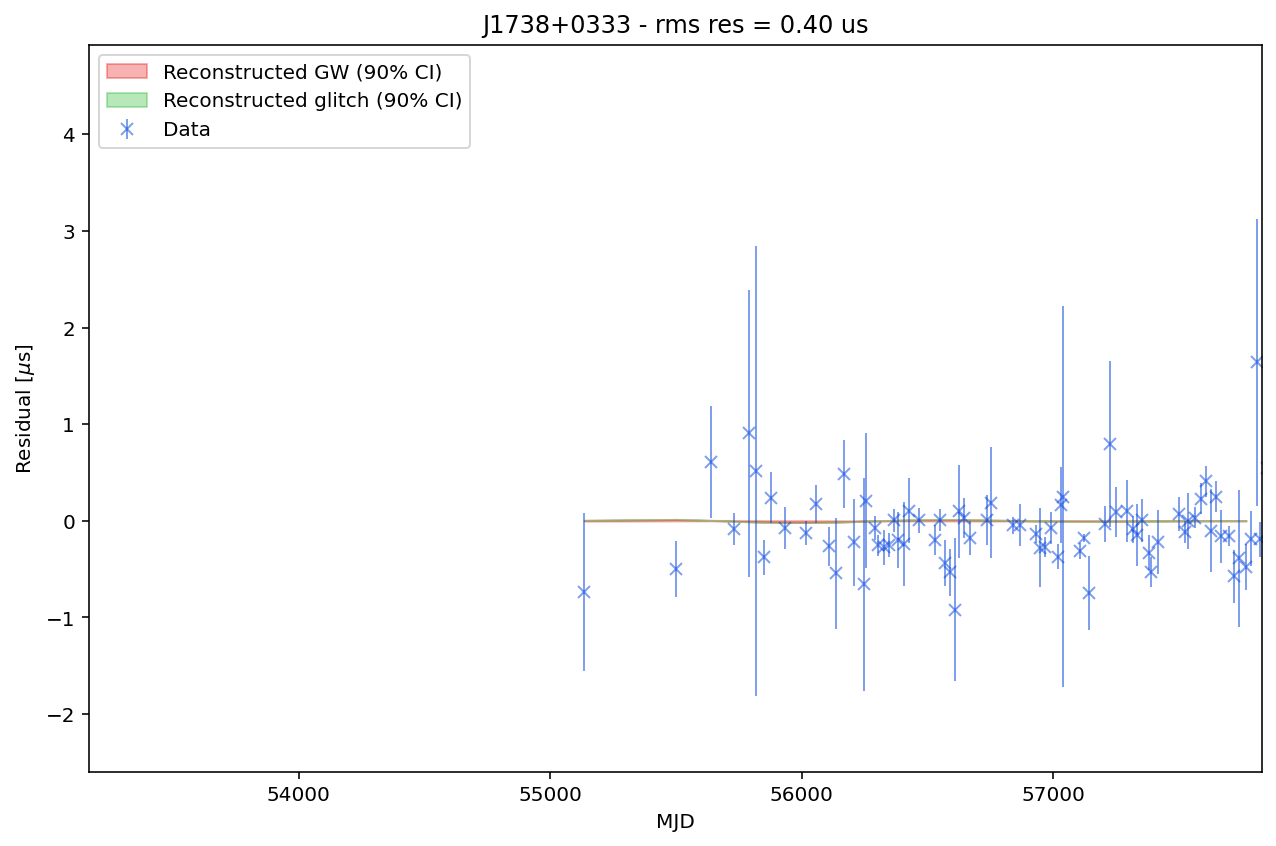

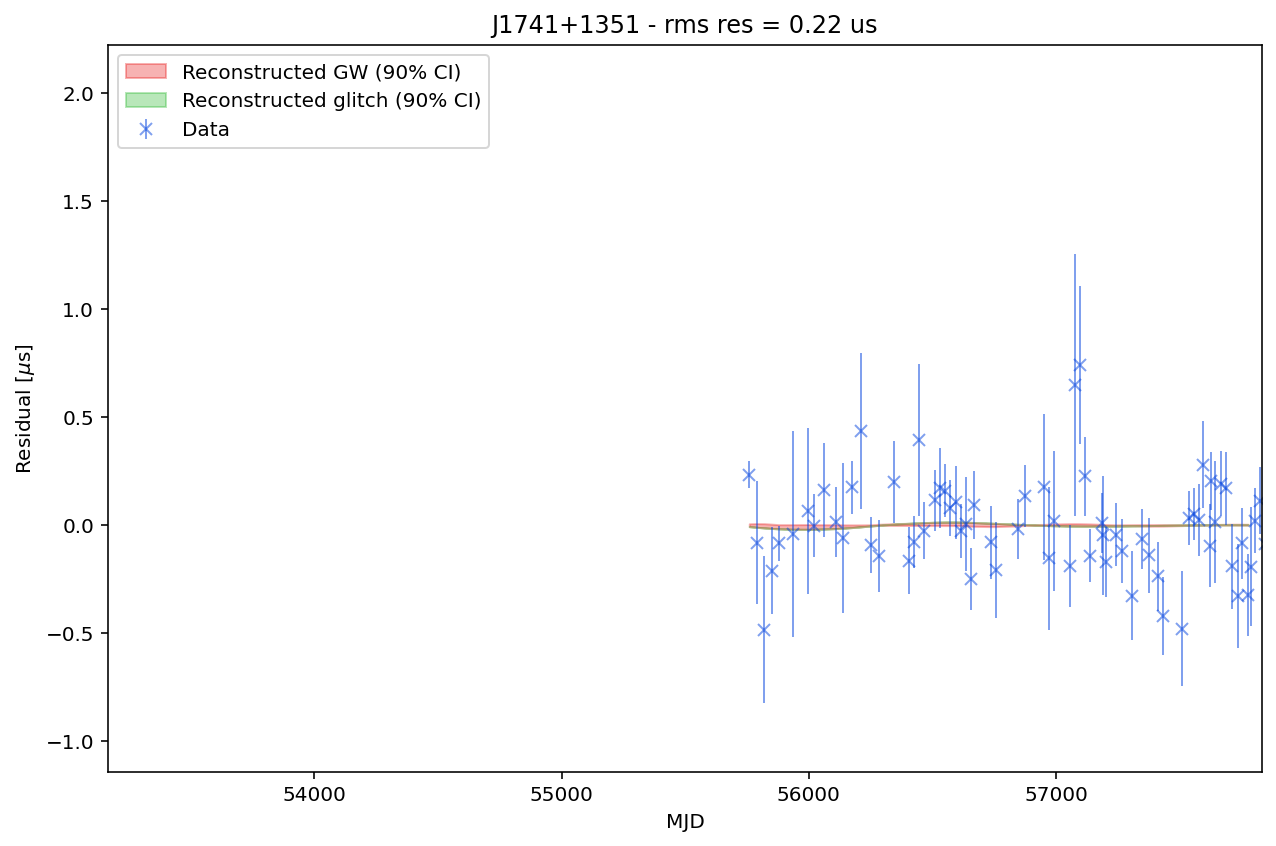

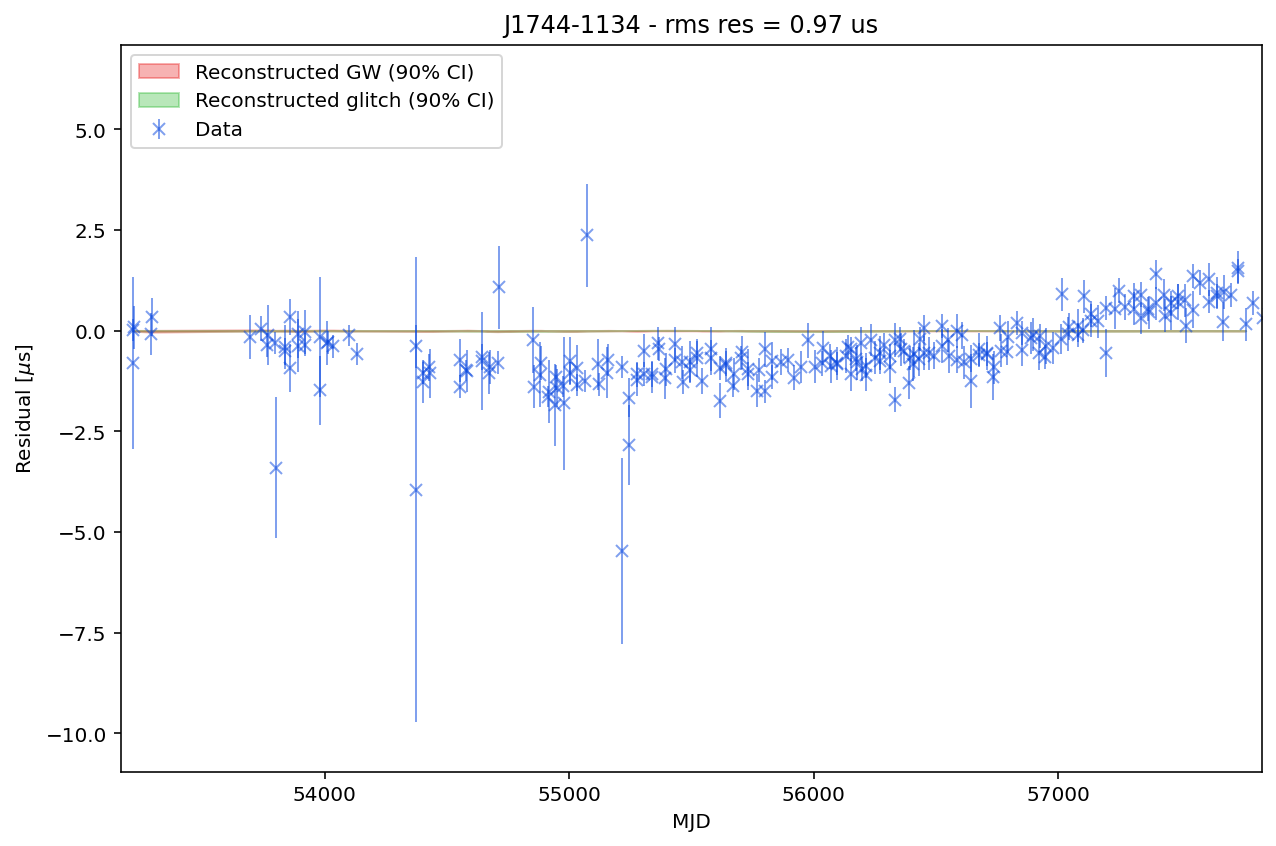

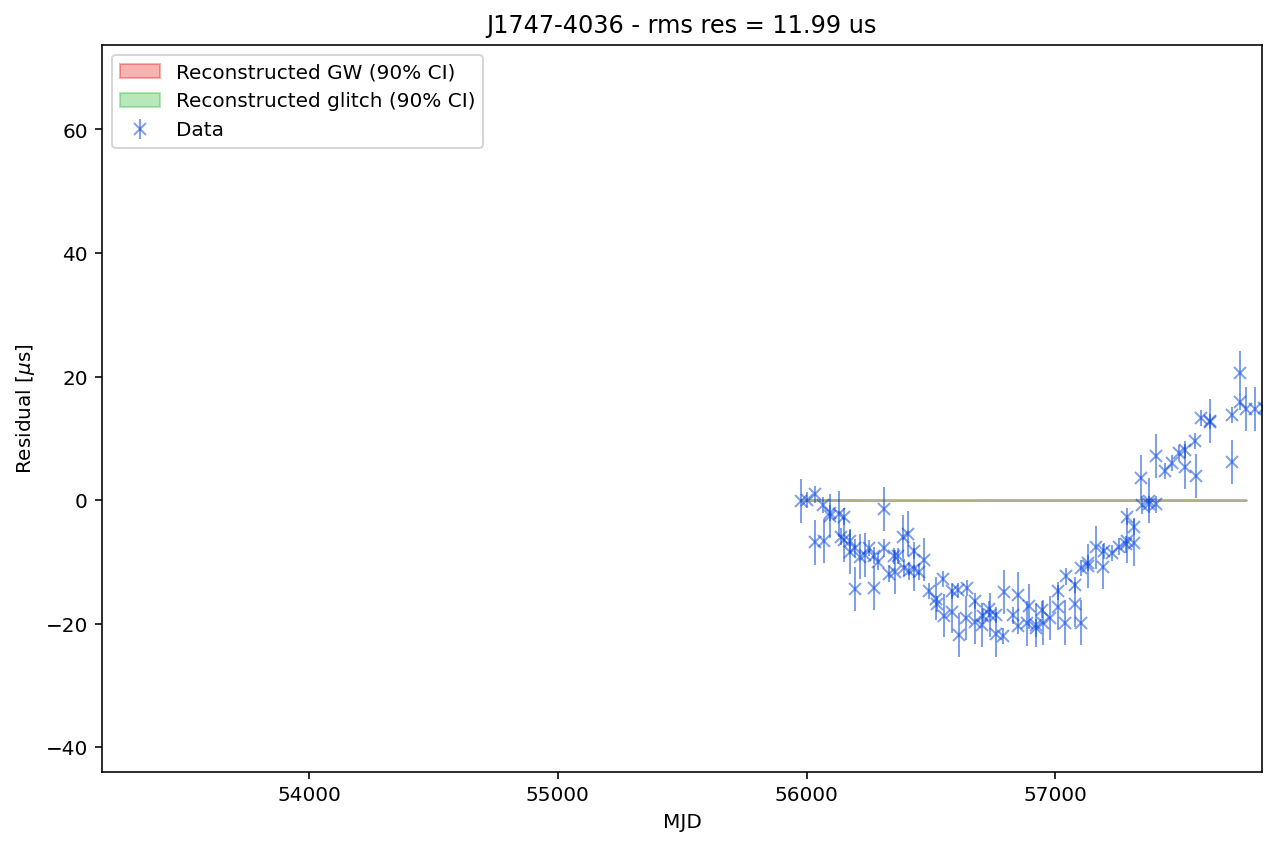

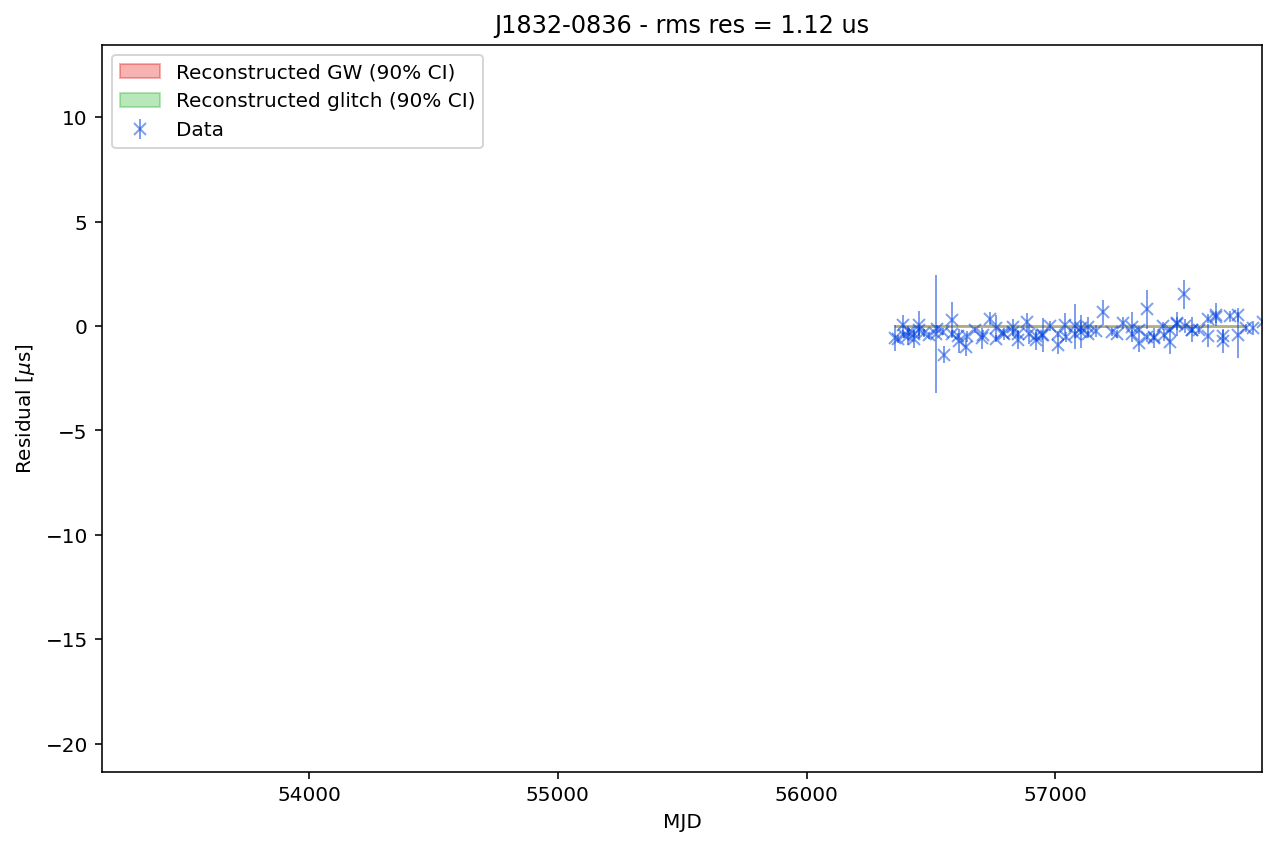

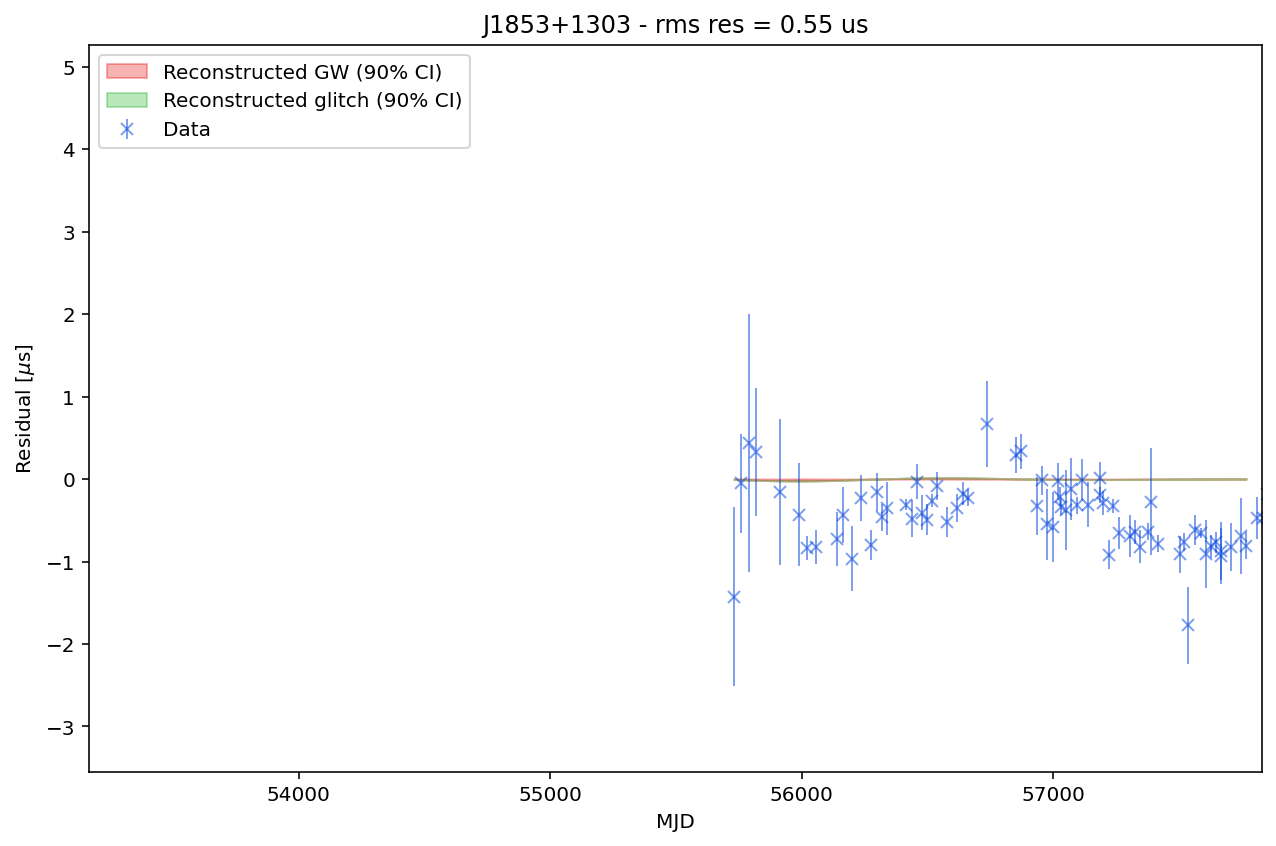

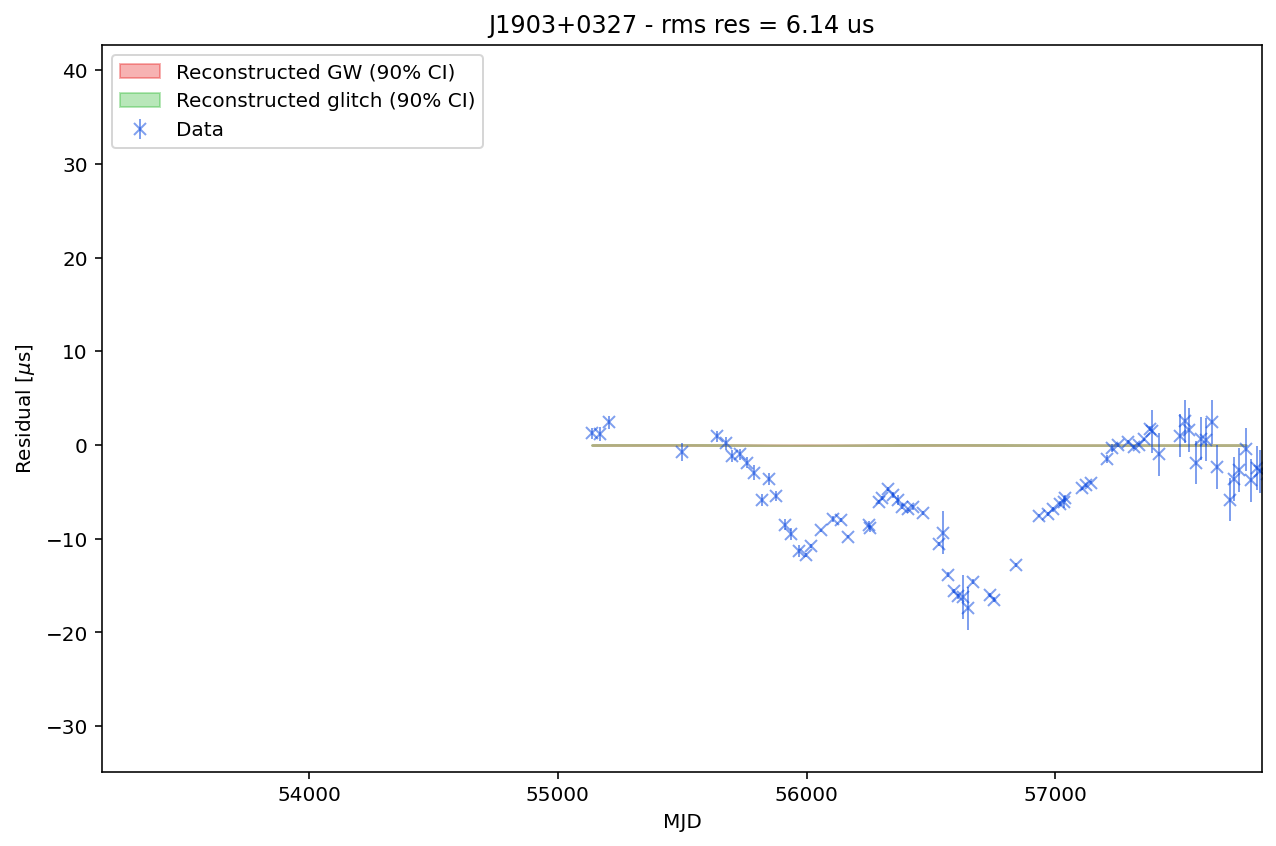

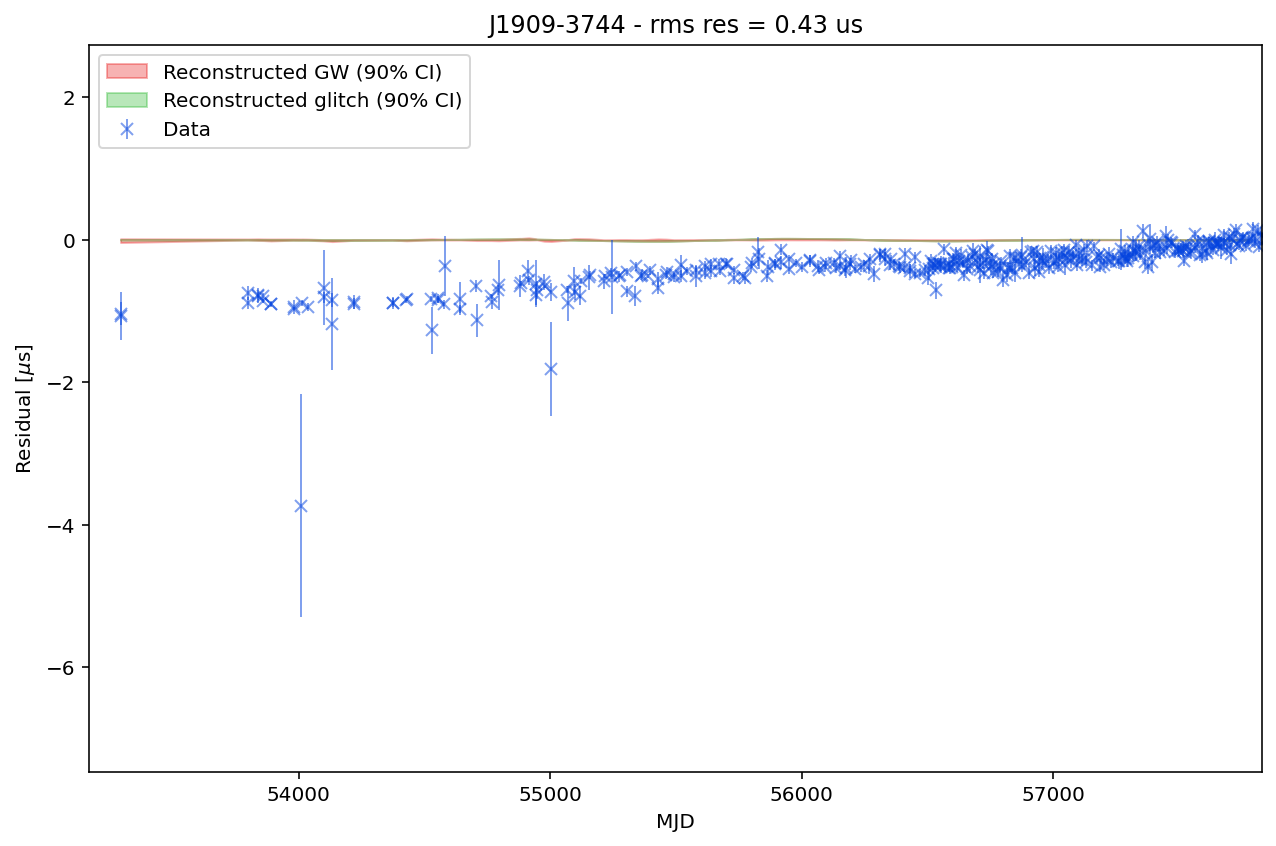

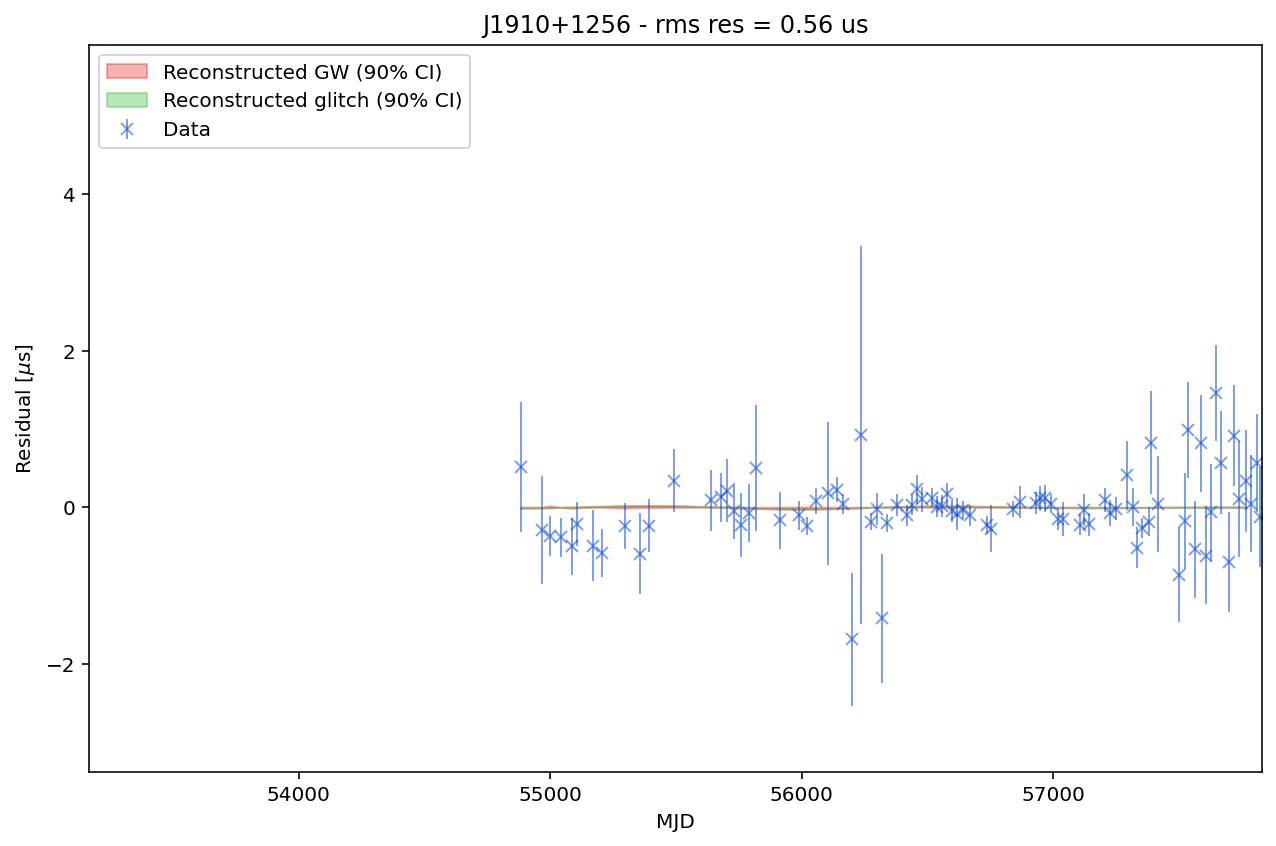

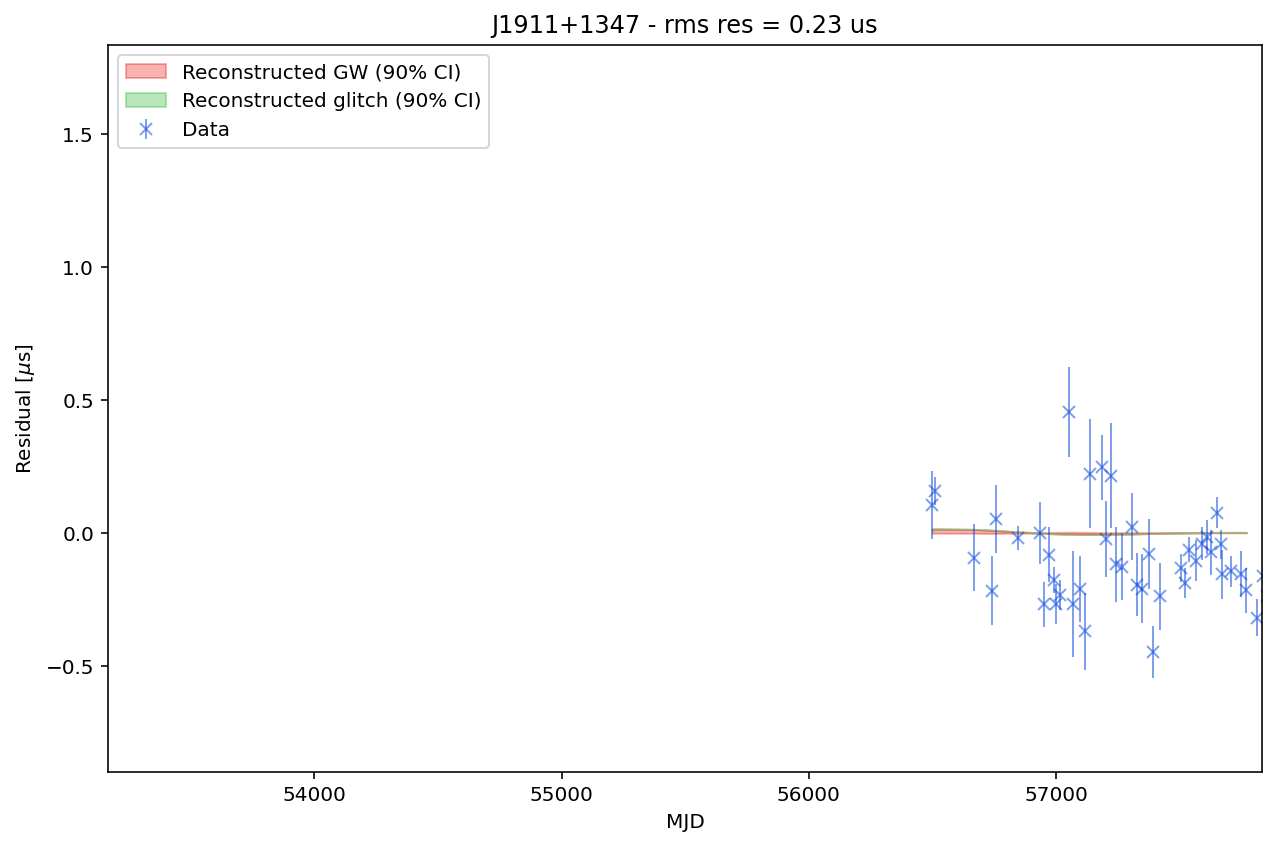

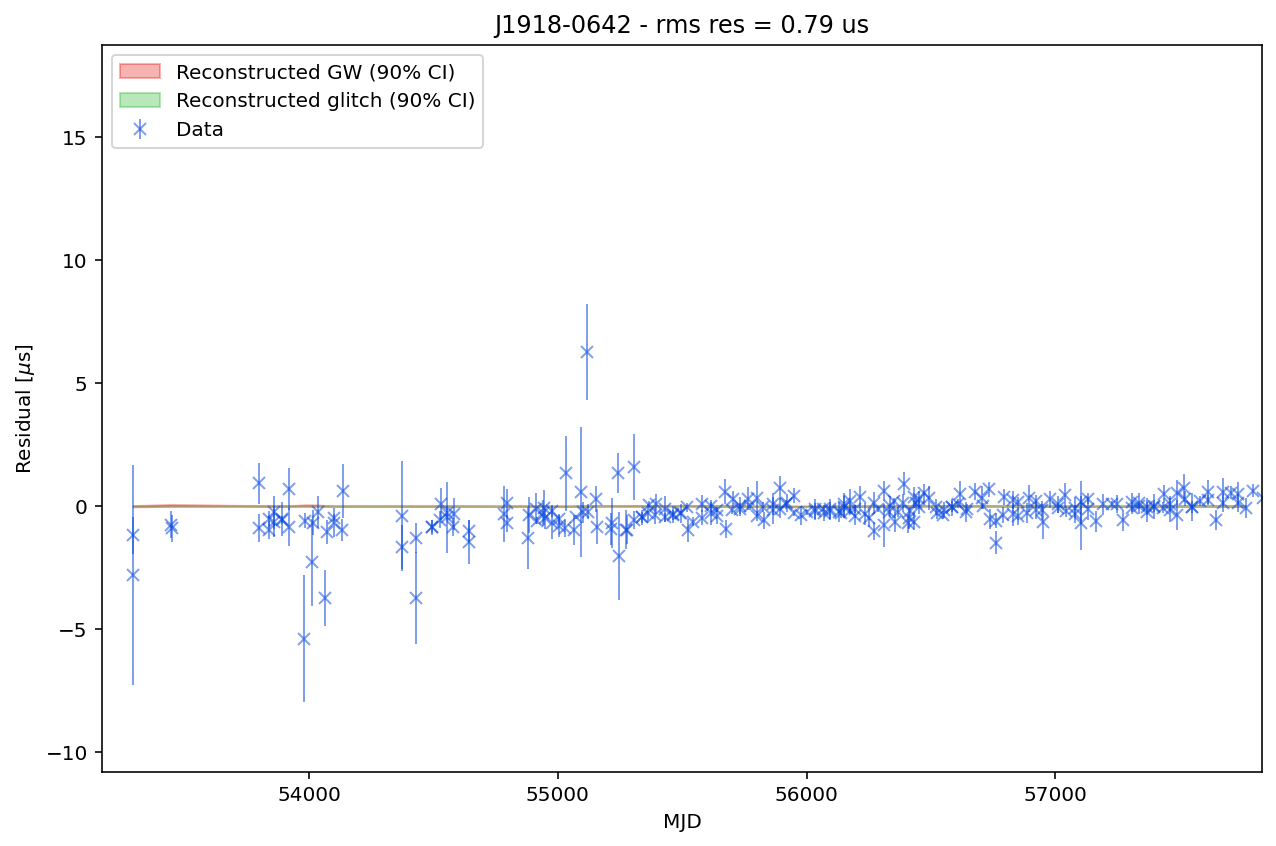

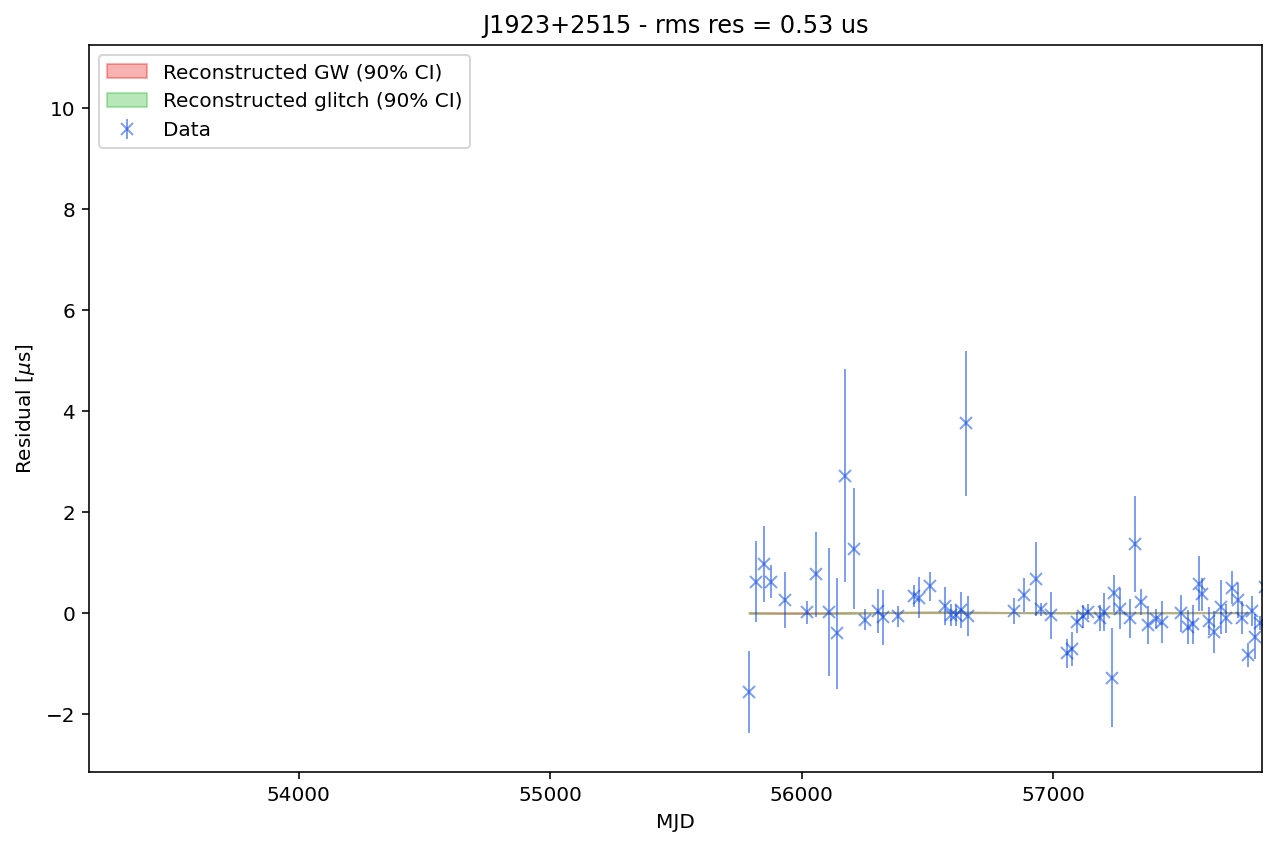

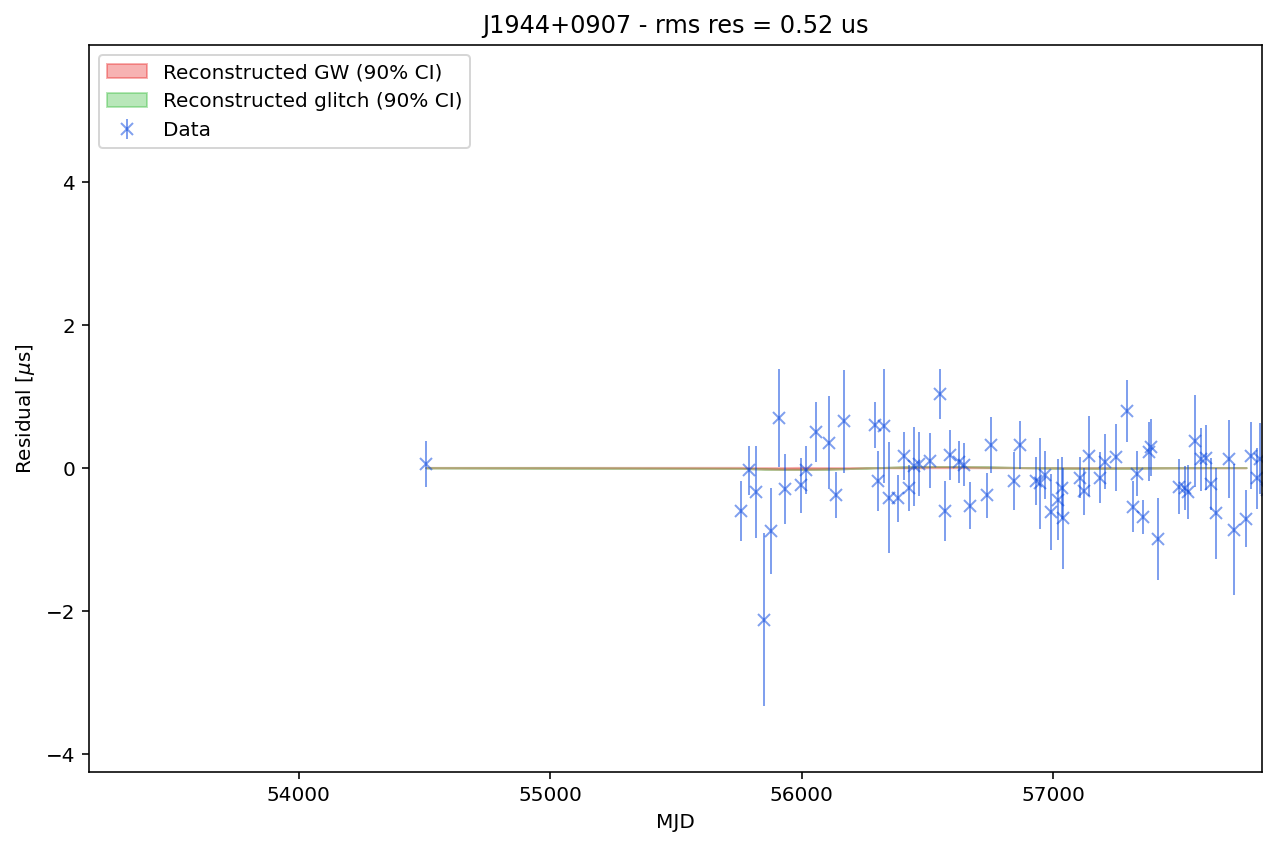

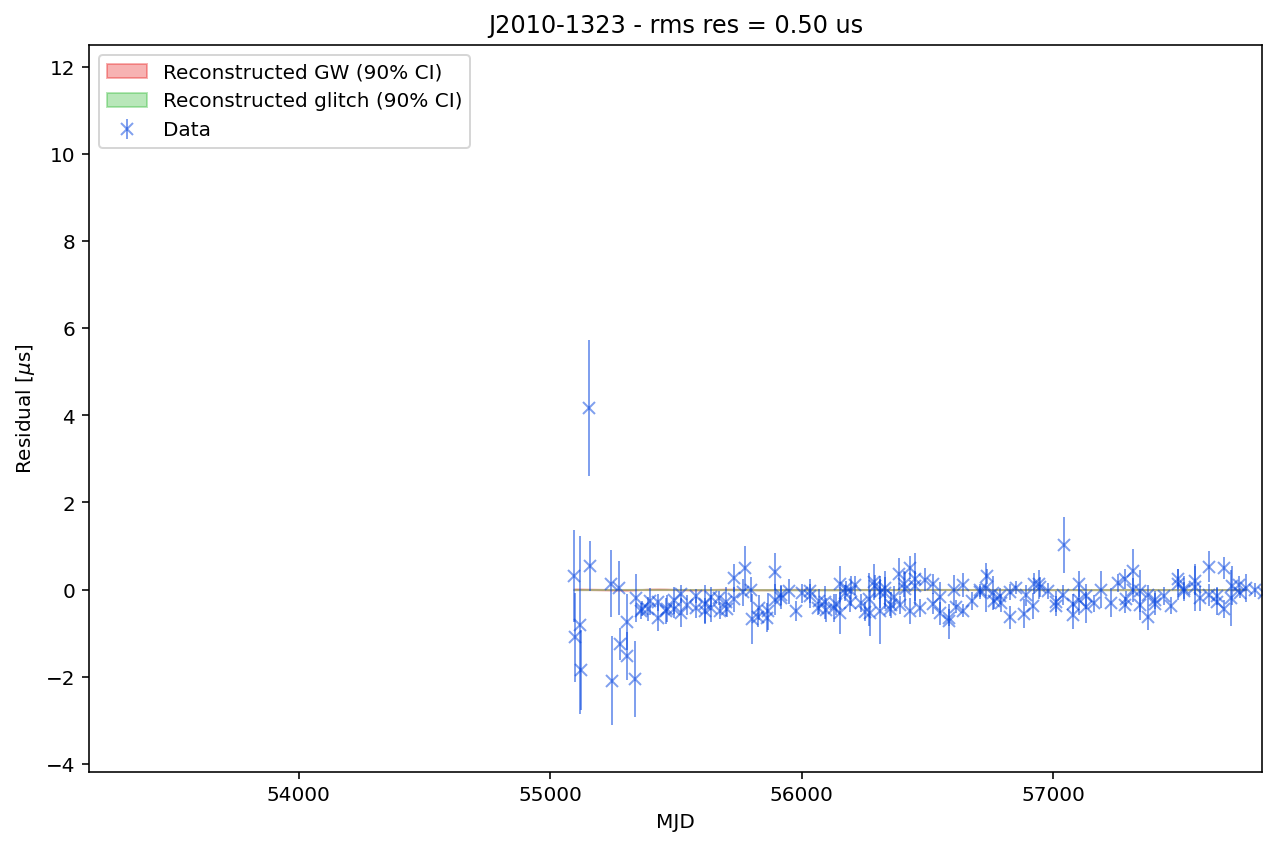

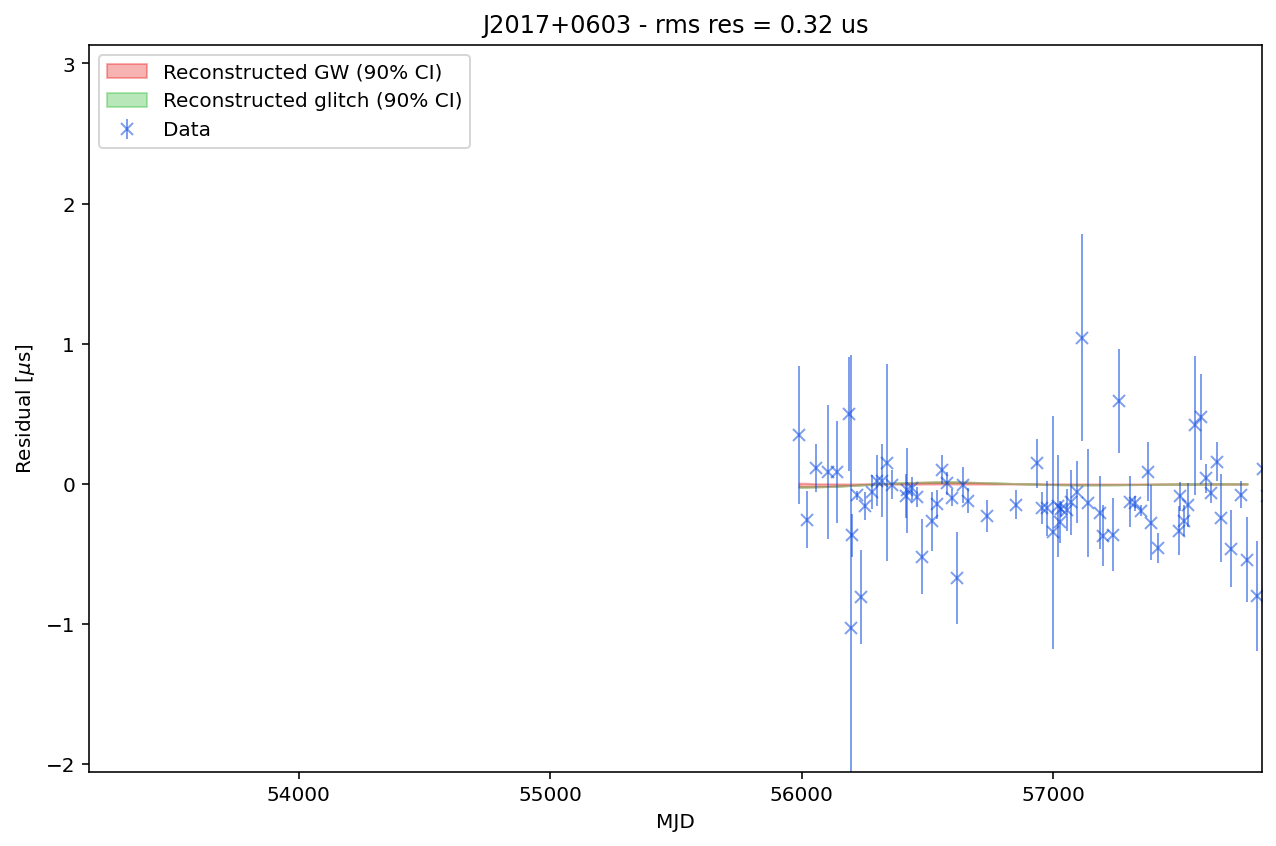

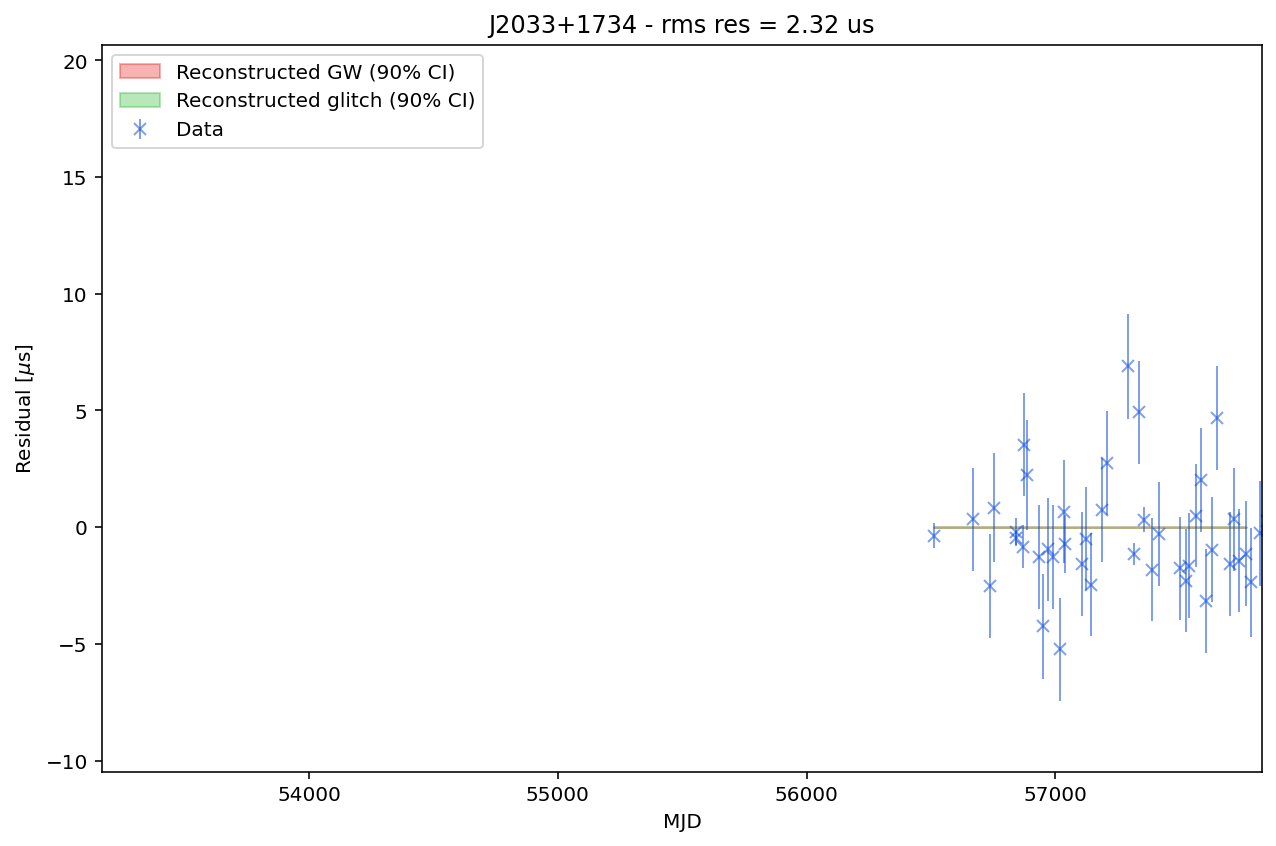

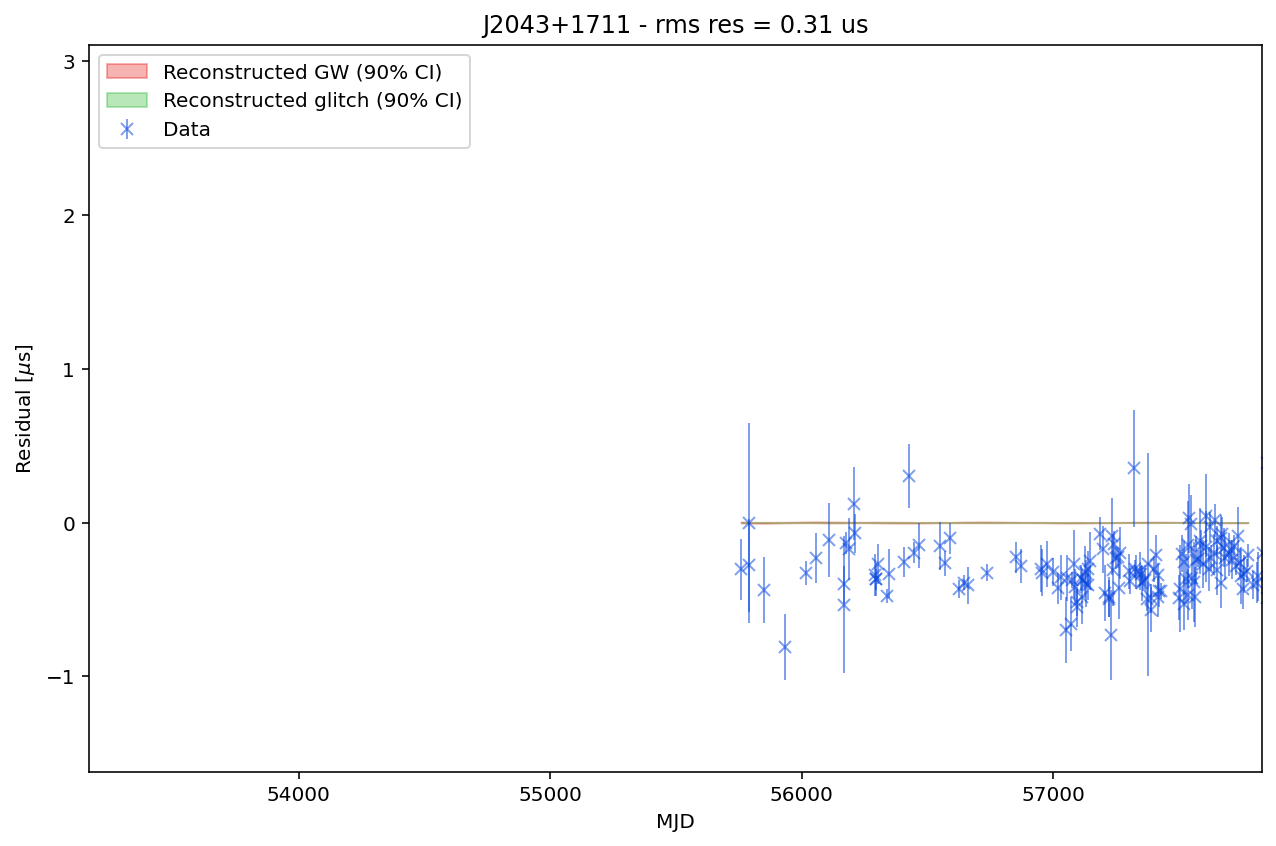

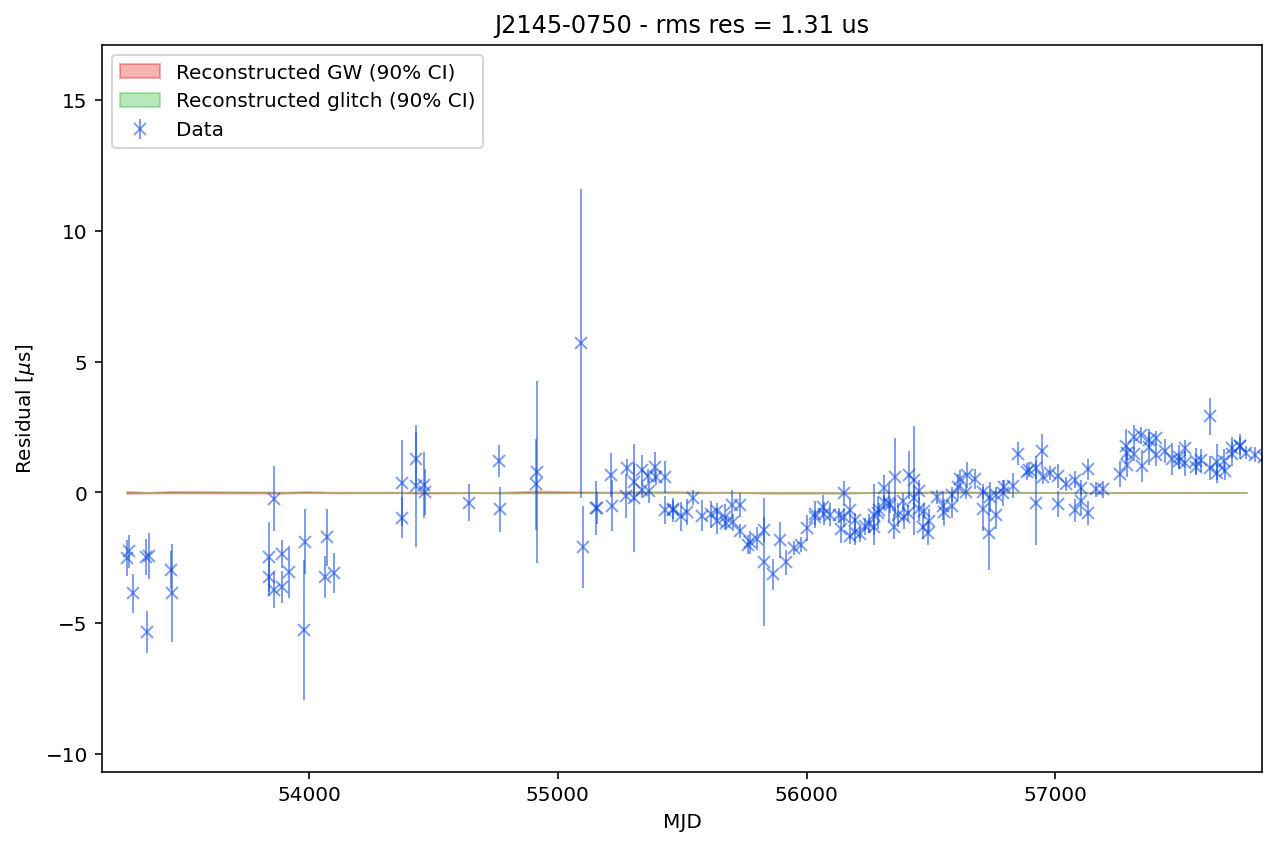

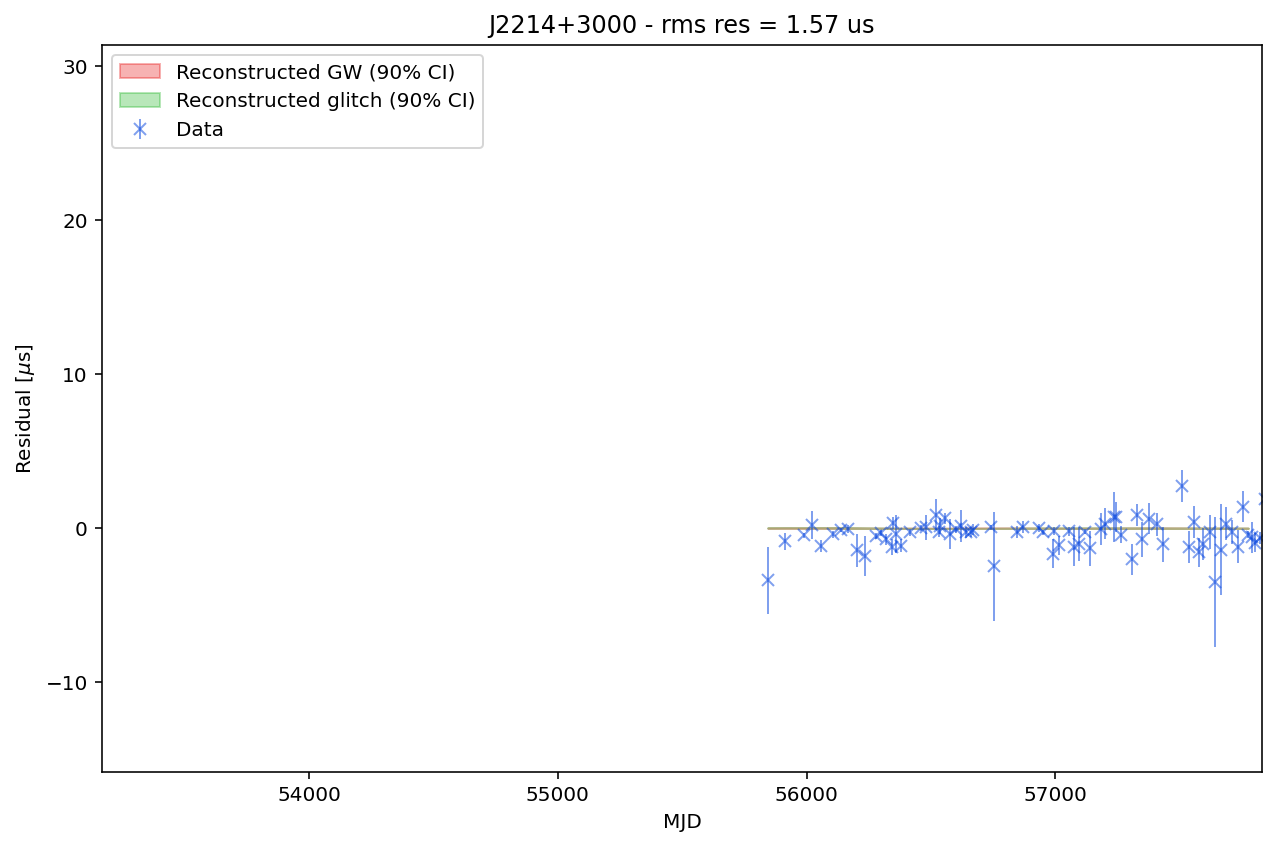

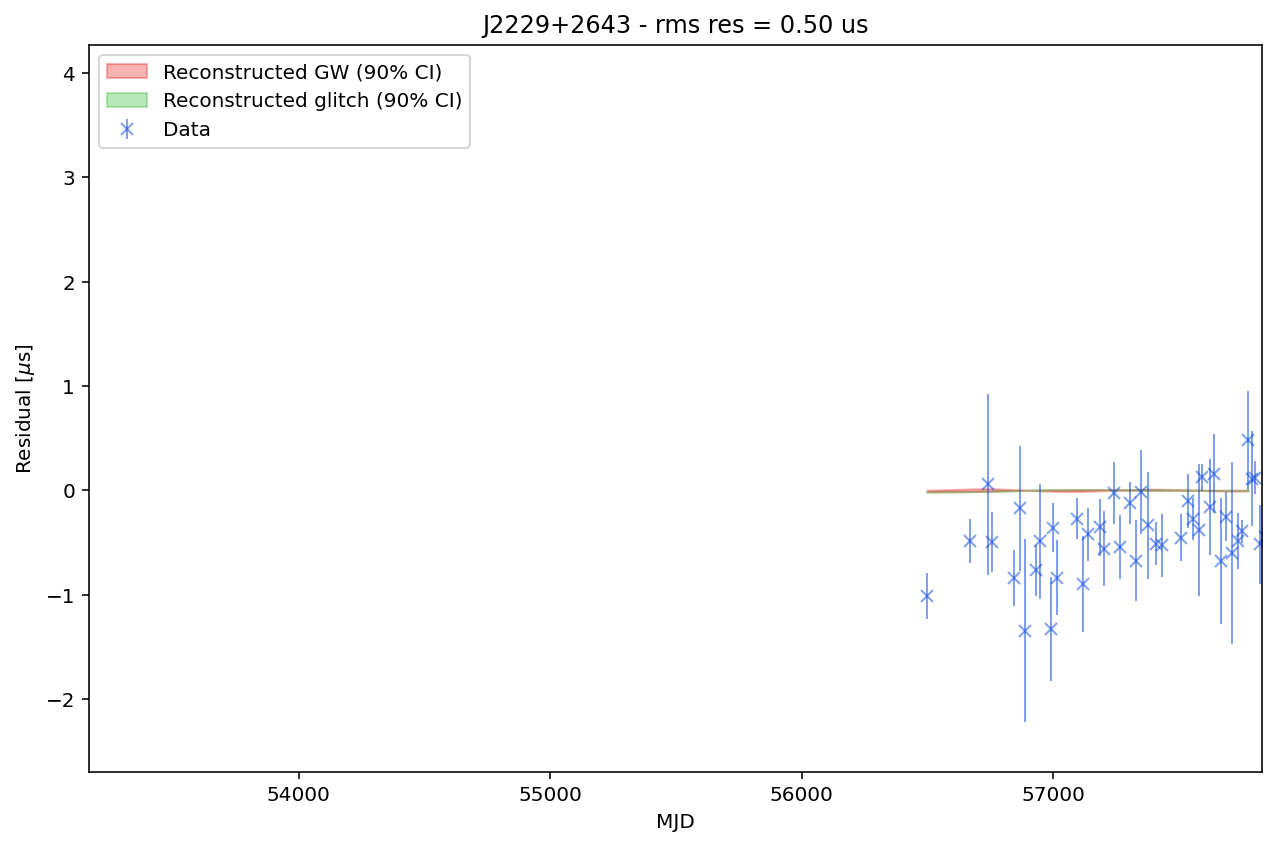

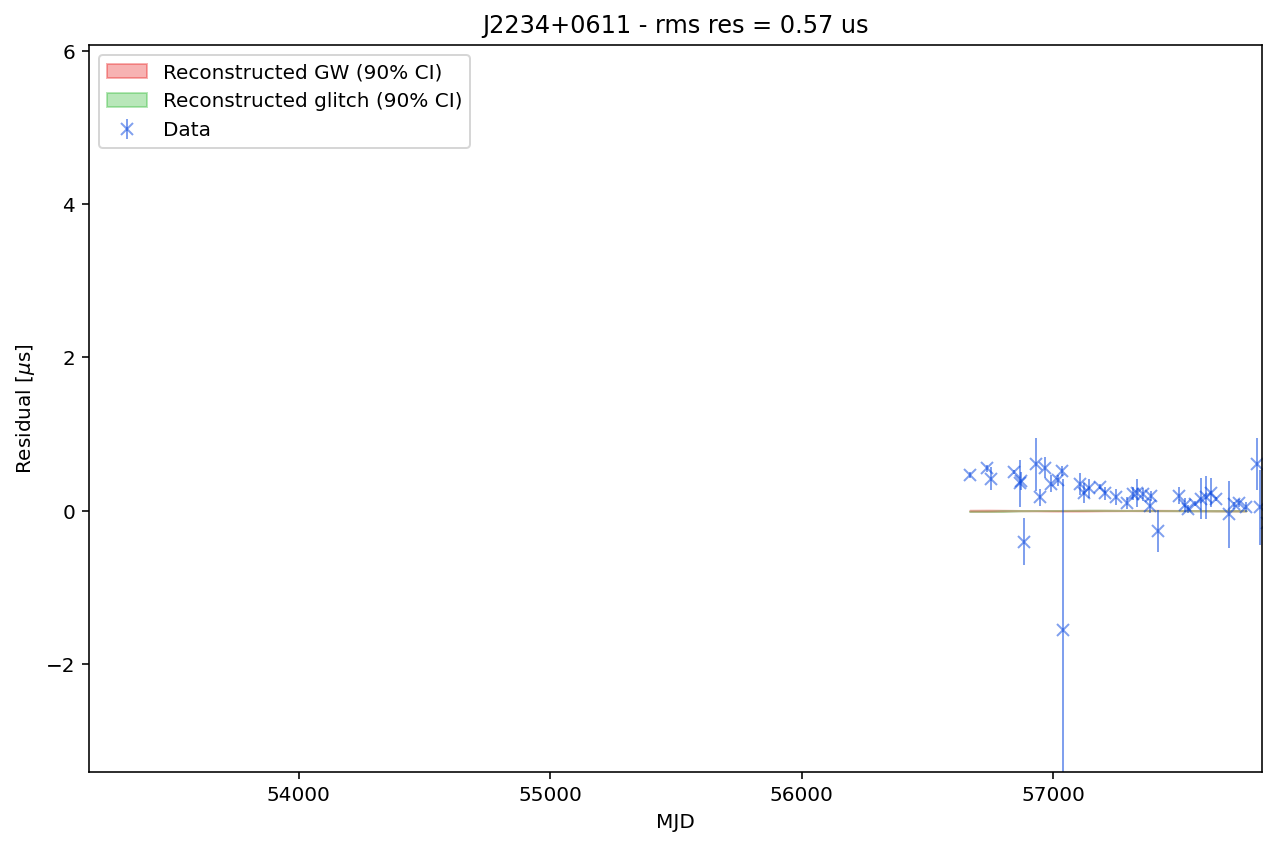

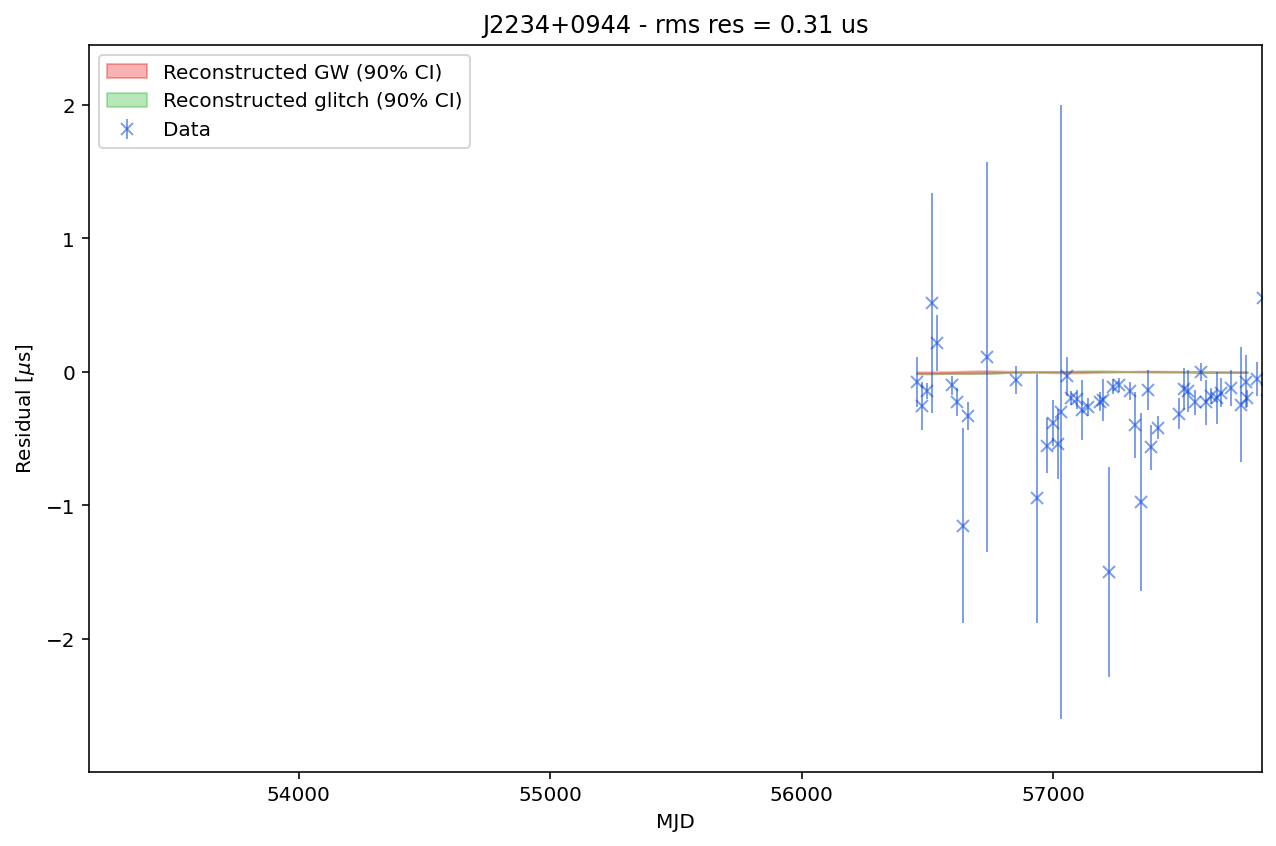

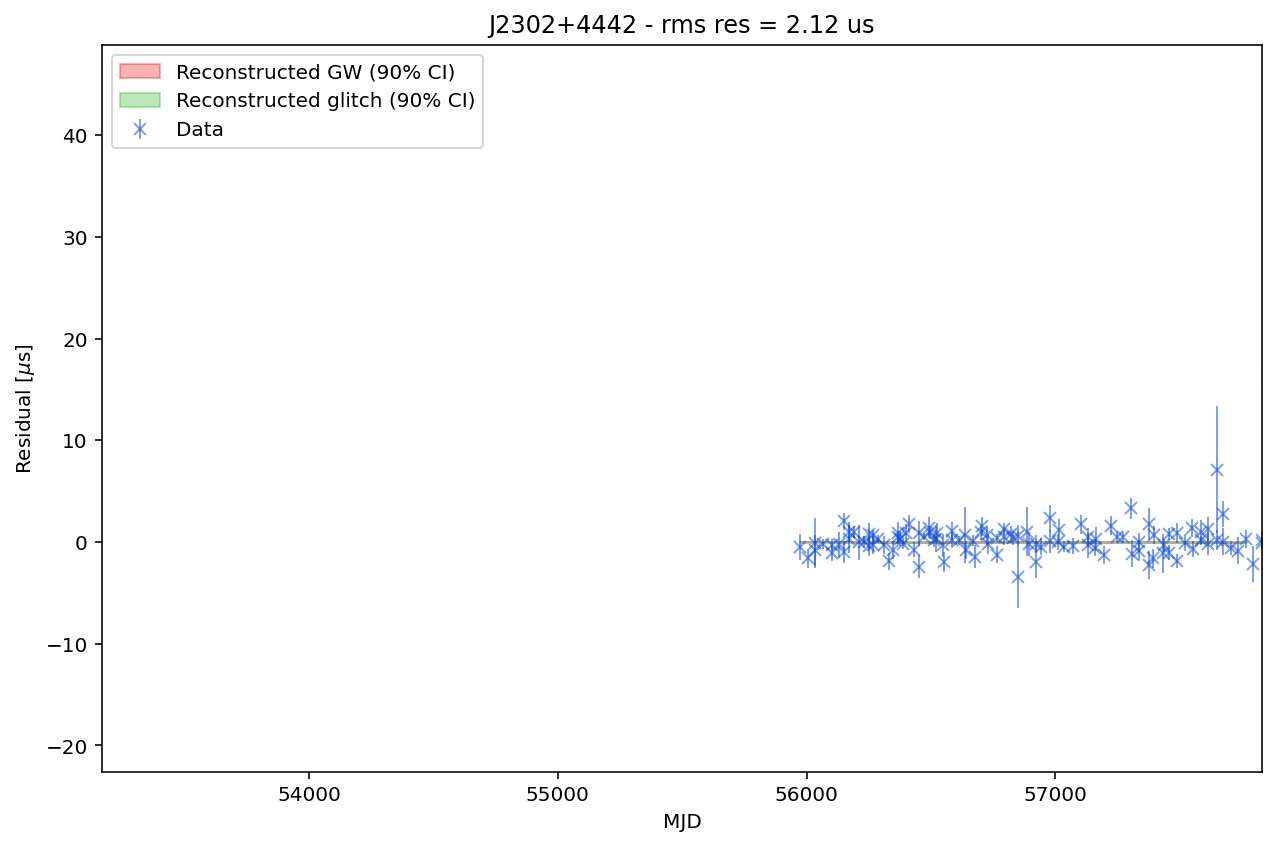

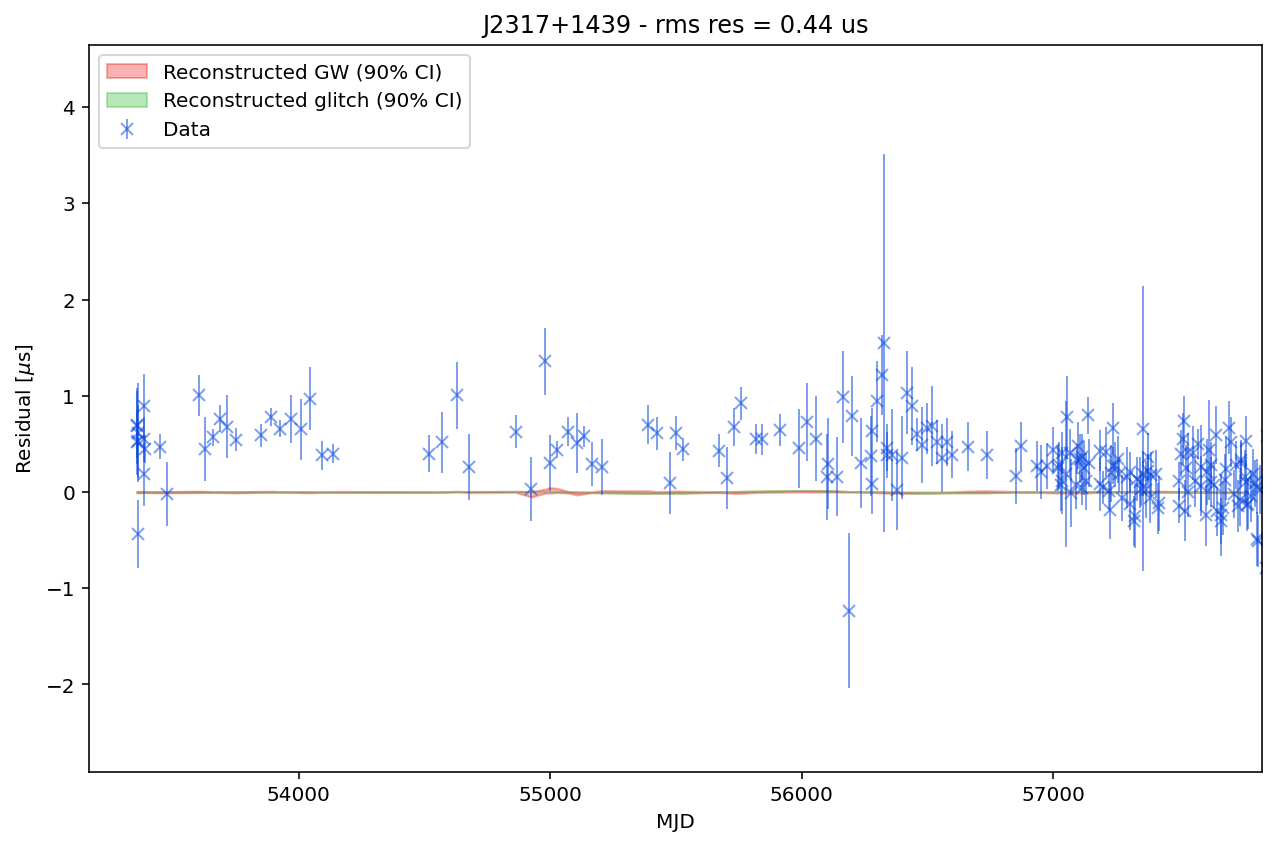

In [35]:
############################################################
#
#BAYESOGRAMS
#
############################################################

tref=53000*86400

max_n_wavelets = 5
max_n_glitches = 0

#burnin = 80000
#burnin = 40000
burnin = 10_000
#burnin = 53000
#burnin = 130000
#burnin= 1000
samples_burned = samples[0,burnin:,:]
thin=1_000
rnd_i = 680#42#56

print(samples_burned[::thin,:].shape)

PTA = BayesHopperBurst.get_ptas(psrs, max_n_wavelet=max_n_wavelets, max_n_glitch=max_n_glitches)[-1][-1][0]
#print(pta.params)

###################
#GW delays
###################

#get max number of observations
print([psrs[i].toas.shape[0] for i in range(45)])
max_obs = np.max([psrs[i].toas.shape[0] for i in range(45)])
print(max_obs)

#get all the delays from samples
all_delays = np.zeros( (int(samples_burned.shape[0]/thin), len(psrs), max_obs) )
for ii in range(int(samples_burned.shape[0]/thin)):
    #print(ii)
    n_wavelet = int(samples_burned[ii*thin,0])
    xxx = {}
    for jj in range(n_wavelet):
        xxx[str(jj)+"_cos_gwtheta"] = samples_burned[ii*thin,2+0+jj*10]
        xxx[str(jj)+"_gw_psi"] = samples_burned[ii*thin,2+1+jj*10]
        xxx[str(jj)+"_gwphi"] = samples_burned[ii*thin,2+2+jj*10]
        xxx[str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+3+jj*10]
        xxx[str(jj)+"_log10_h"] = samples_burned[ii*thin,2+4+jj*10]
        xxx[str(jj)+"_log10_h_cross"] = samples_burned[ii*thin,2+5+jj*10]
        xxx[str(jj)+"_phase0"] = samples_burned[ii*thin,2+6+jj*10]
        xxx[str(jj)+"_phase0_cross"] = samples_burned[ii*thin,2+7+jj*10]
        xxx[str(jj)+"_t0"] = samples_burned[ii*thin,2+8+jj*10]
        xxx[str(jj)+"_tau"] = samples_burned[ii*thin,2+9+jj*10]
        #old
        #xxx[str(jj)+"_cos_gwtheta"] = samples_burned[ii*thin,2+0+jj*8]
        #xxx[str(jj)+"_epsilon"] = samples_burned[ii*thin,2+1+jj*8]
        #xxx[str(jj)+"_gwphi"] = samples_burned[ii*thin,2+2+jj*8]
        #xxx[str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+3+jj*8]
        #xxx[str(jj)+"_log10_h"] = samples_burned[ii*thin,2+4+jj*8]
        #xxx[str(jj)+"_phase0"] = samples_burned[ii*thin,2+5+jj*8]
        #xxx[str(jj)+"_t0"] = samples_burned[ii*thin,2+6+jj*8]
        #xxx[str(jj)+"_tau"] = samples_burned[ii*thin,2+7+jj*8]
    
    #print(samples_burned[burnin+ii,:])
    #print(xxx)
    delay_all_psr = PTA.get_delay(xxx)
    for kk in range(len(psrs)):
        all_delays[ii,kk,:psrs[kk].toas.shape[0]] = delay_all_psr[kk]
        
    #if ii==rnd_i:
    #    delay_rnd_draw = np.copy(delay_all_psr)
    #    wavelets_rnd_draw = np.zeros( (int(n_wavelet), len(psrs), psrs[0].toas.shape[0]) )
    #    #print(n_wavelet)
    #    #print(xxx)
    #    for jj in range(n_wavelet):
    #        #print({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        wavelets_rnd_draw[jj,:,:] = PTA.get_delay({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        #print(wavelets_rnd_draw[jj,0,:])

#print(delay_rnd_draw.shape)
#print(wavelets_rnd_draw.shape)
#print(wavelets_rnd_draw)

print(all_delays.shape)
    
#calculate median and 90%CI delay
median_delays = np.zeros( (len(psrs), max_obs) )
lower90_delays = np.zeros( (len(psrs), max_obs) )
upper90_delays = np.zeros( (len(psrs), max_obs) )
for kk in range(len(psrs)):
    for ll in range(psrs[kk].toas.shape[0]):
        median_delays[kk,ll] = np.median(all_delays[:,kk,ll])
        upper90_delays[kk,ll] = np.percentile(all_delays[:,kk,ll], 95)
        lower90_delays[kk,ll] = np.percentile(all_delays[:,kk,ll], 5)

###################
#Glitch delays
###################

#get all the delays from samples
all_glitch_delays = np.zeros( (int(samples_burned.shape[0]/thin), len(psrs), max_obs) )
for ii in range(int(samples_burned.shape[0]/thin)):
    #print(ii)
    n_glitch = int(samples_burned[ii*thin,1])
    xxx = {}
    for jj in range(n_glitch):
        xxx["Glitch_"+str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+0]
        xxx["Glitch_"+str(jj)+"_log10_h"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+1]
        xxx["Glitch_"+str(jj)+"_phase0"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+2]
        xxx["Glitch_"+str(jj)+"_psr_idx"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+3]
        xxx["Glitch_"+str(jj)+"_t0"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+4]
        xxx["Glitch_"+str(jj)+"_tau"] = samples_burned[ii*thin,2+max_n_wavelets*10+jj*6+5]
        #old
        #xxx["Glitch_"+str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+0]
        #xxx["Glitch_"+str(jj)+"_log10_h"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+1]
        #xxx["Glitch_"+str(jj)+"_phase0"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+2]
        #xxx["Glitch_"+str(jj)+"_psr_idx"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+3]
        #xxx["Glitch_"+str(jj)+"_t0"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+4]
        #xxx["Glitch_"+str(jj)+"_tau"] = samples_burned[ii*thin,2+max_n_wavelets*8+jj*6+5]

    
    #print(samples_burned[burnin+ii,:])
    #print(xxx)
    delay_all_psr_glitch = PTA.get_delay(xxx)
    for kk in range(len(psrs)):
        all_glitch_delays[ii,kk,:psrs[kk].toas.shape[0]] = delay_all_psr_glitch[kk]
        
    #if ii==rnd_i:
    #    delay_rnd_draw = np.copy(delay_all_psr)
    #    wavelets_rnd_draw = np.zeros( (int(n_wavelet), len(psrs), psrs[0].toas.shape[0]) )
    #    print(n_wavelet)
    #    print(xxx)
    #    for jj in range(n_wavelet):
    #        print({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        wavelets_rnd_draw[jj,:,:] = pta.get_delay({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        print(wavelets_rnd_draw[jj,0,:])

#print(delay_rnd_draw.shape)
#print(wavelets_rnd_draw.shape)
#print(wavelets_rnd_draw)
    
#calculate median and 90%CI delay
median_glitch_delays = np.zeros( (len(psrs), max_obs) )
lower90_glitch_delays = np.zeros( (len(psrs), max_obs) )
upper90_glitch_delays = np.zeros( (len(psrs), max_obs) )
for kk in range(len(psrs)):
    for ll in range(psrs[kk].toas.shape[0]):
        median_glitch_delays[kk,ll] = np.median(all_glitch_delays[:,kk,ll])
        upper90_glitch_delays[kk,ll] = np.percentile(all_glitch_delays[:,kk,ll], 95)
        lower90_glitch_delays[kk,ll] = np.percentile(all_glitch_delays[:,kk,ll], 5)
        #if kk==0:
        #    print(all_glitch_delays[:,kk,ll])


for idx in range(len(psrs)):
    #print(phase0_max, x1['phase0'])
    ######plt.figure(idx, figsize=(10,7))
    fig, ax1 = plt.subplots(num=idx, figsize=(9,6))
    print(fig, ax1)
    injected_data = T2.tempopulsar(parfile = parfiles[idx], timfile = timfiles[idx], maxobs=30000,
                                   ephem='DE436',clk=None)
    LP.plotres(injected_data, label='Data', color=spec_colors['data'], alpha=0.5, markeredgewidth=1,
               elinewidth=1, capsize=None, capthick=0.5)
    #res_model = pta.get_delay(xx)[idx]
    #res_model = pta.get_delay(samples_burned[10000,1:1+max_wavelets*8])[idx]
    #for kk in range(100):
    #    plt.plot(t,all_delays[kk,idx,:]*1e6, color="r", alpha=0.1)
    
    #plt.plot(t,median_delays[idx,:]*1e6, color="r", alpha=1.0, ls='--')
    #print(idx)
    #print((psrs[idx].toas/86400).shape)
    #print(psrs[idx].toas.shape[0])
    #print(lower90_delays[idx,:psrs[idx].toas.shape[0]].shape)
    ax1.fill_between(psrs[idx].toas/86400, lower90_delays[idx,:psrs[idx].toas.shape[0]]*1e6,
                     upper90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["GW_rec"],
                     alpha=0.3, label='Reconstructed GW (90% CI)')
    
    ax1.fill_between(psrs[idx].toas/86400, lower90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6,
                     upper90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6,
                     color=spec_colors["glitch_rec"],
                     alpha=0.3, label='Reconstructed glitch (90% CI)')
    
    #plt.plot(psrs[idx].toas/86400, all_gp_means[idx]*1e6, color='xkcd:salmon',
    #         ls=':', lw=2, label='RN+timing model')
    
    #ax1.plot(t, delays_gw[idx]*1e6, color=spec_colors['GW_inj'], ls='--', label='Injected GW')
    #plt.plot(t, delays_glitch[idx]*1e6, color=spec_colors['glitch_inj'], ls='--', label='Injected glitch')
    
    #plt.plot(t, parabolic_gw_delays[idx]*1e6, color='xkcd:purple', ls='--', label='Injected GW')
    #plt.plot(t, wnb_gw_delays[idx]*1e6, color='xkcd:purple', ls='--', label='Injected GW')
    
    #plt.plot(t, delay_rnd_draw[idx,:]*1e6, color="xkcd:purple", label='Reconstructed random draw')
    #for ww in range(wavelets_rnd_draw.shape[0]):
    #    plt.plot(t, wavelets_rnd_draw[ww,idx,:]*1e6-(ww+1)*5.0, color="xkcd:purple", ls='--',
    #             label="wavelet #{0}".format(ww))
    #plt.plot(t,lower90_delays[idx,:]*1e6, color="b", alpha=1.0, ls='--')
    #plt.plot(t,upper90_delays[idx,:]*1e6, color="b", alpha=1.0, ls='--')
    #####res_model = pta.get_delay(xx_median)[idx]
    #print(samples_burned[11000,1:1+max_wavelets*8])
    #res_model = pta.get_delay(x0)[idx]
    #plt.plot(t,waveform[idx,:]*1e6, label="directly from F-stat")
    #plt.plot(t,res_fe*1e6, label="from F-stat max parameters")
    ####plt.plot(t,res_model*1e6, label="injected")
    #print(res_model)
    #plt.plot(t,(res_fe-waveform[idx,:])*1e6, label="diff")
    #plt.title("cos_inc_max={0}\n psi_max={1}\n phase0_max={2}\n h_max={3}".format(np.cos(inc_max),
    #                                                                          psi_max, phase0_max, h_max))
    #plt.gca().axvline(x=tref/86400)
    
    max_res = np.max(injected_data.residuals()*1e6).astype(float)
    min_res = np.min(injected_data.residuals()*1e6).astype(float)
    print(min_res, max_res)
    
    ax1.legend(loc=2)
    #plt.ylim((-5.5,5.5))
    ax1.set_ylim((min_res*2,max_res*3))
    #plt.ylim((-2.0,2.0))
    ax1.set_ylabel("Residual [$\mu$s]")
    #plt.xlim(((psrs[idx].toas/86400).min()-50,(psrs[idx].toas/86400).max()+50))
    plt.xlim((tmin-50, stop_time+50))
    #ax1.set_title("B1855+09 (11yr)")
    fig.tight_layout()
    
    ############################
    #
    #Inlet with number of wavelets used
    #
    ############################
    fig_inv = fig.transFigure.inverted()
    #lll = fig_inv.transform(ax1.transData.transform(((psrs[idx].toas/86400).max()+50, max_res*3)))[0]
    #bbb = fig_inv.transform(ax1.transData.transform(((psrs[idx].toas/86400).max()+50, max_res*3)))[1]
    lll = fig_inv.transform(ax1.transData.transform((stop_time+50, max_res*3)))[0]
    bbb = fig_inv.transform(ax1.transData.transform((stop_time+50, max_res*3)))[1]
    print(lll,bbb)
    
    left, bottom, width, height = [lll-0.32, bbb-0.3-0.001, 0.32, 0.3]
    #ax2 = fig.add_axes([left, bottom, width, height], frameon=True, zorder=1)
    
    #ax2.bar(bin_edges_signal[:-1]+0.5, hist_signal/N*100, fill=False, edgecolor=spec_colors["GW_rec"],
    #        linewidth=2, label='Signal', alpha=0.3)
    #ax2.bar(bin_edges_glitch[:-1]+0.5, hist_glitch/N*100, fill=False, edgecolor=spec_colors["glitch_rec"],
    #        linewidth=2, label='Glitch', alpha=0.3)
    #ax2.set_xlabel("# of wavelets")
    #ax2.set_ylabel("%")
    #ax2.set_ylim((0,110))
    #ax2.legend(loc=1)
    #ax2.tick_params(bottom=False, top=True, labelbottom=False, labeltop=True)
    bottom_extra = 0.08
    left_extra = 0.08
    #rect = Rectangle((left-left_extra, bottom-bottom_extra), width+left_extra, height+bottom_extra,
    #                 facecolor='white', edgecolor="#bcbcbc", lw=1, transform=fig.transFigure, zorder=0)
    #fig.patches.append(rect)
    
    min_n=0
    max_n=5
    #plt.xticks(np.arange(min_n, max_n+1, step=1.0))
    
    #plt.savefig("../Paper/Plots/B1855+09_11yr_reconstruction.png", dpi=300)

# Skymap

In [ ]:
burnin = 10_000

gw_on_filter = np.where(samples[0,burnin:,0]>0)

gw_theta = np.arccos(samples[0,burnin:,2+0])[gw_on_filter]
gw_psi = samples[0,burnin:,2+1][gw_on_filter]
gw_phi = samples[0,burnin:,2+2][gw_on_filter]
log10_f0 = samples[0,burnin:,2+3][gw_on_filter]
log10_h = samples[0,burnin:,2+4][gw_on_filter]
log10_h_cross = samples[0,burnin:,2+5][gw_on_filter]
phase0 = samples[0,burnin:,2+6][gw_on_filter]
phase0_cross = samples[0,burnin:,2+7][gw_on_filter]
t0 = samples[0,burnin:,2+8][gw_on_filter]
tau = samples[0,burnin:,2+9][gw_on_filter]

#_ = corner.corner(np.array([gw_theta, gw_phi]).T, range=[(0,np.pi), (0, 2*np.pi)])

_ = corner.corner(np.array([gw_theta, gw_psi, gw_phi, log10_f0, log10_h, log10_h_cross,
                            phase0, phase0_cross, t0, tau]).T,
                  labels = ["gw_theta", "gw_psi", "gw_phi", "log10_f0",
                            "log10_h_plus", "log10_h_cross", "phase0_plus", "phase0_cross",
                            "t0", "tau"],
                  range=[(0,np.pi), (0,np.pi), (0, 2*np.pi), (-8.4559, -7), (-10,-4), (-10,-4),
                         (0, 2*np.pi), (0, 2*np.pi), (0, 12.5), (0.2, 5)])

3072
489000
[0.00749883 0.0269958  0.00799876 ... 0.02299642 0.01499767 0.01899705]
170.82694090319245
12.343275441587277
5.517956550966443
5.515328950272237
11.99443316699259
4.915885425517806
11.82453664685325
3.0786149809856536
5.642367850260961
3.07854465758915
3.8791654562448783
12.449353187613202
7.254396900357646
3.0779570584574056
3.4756102560056488
12.451502226447444
yeah
9.209862341512506
8.323418578253586
11.923496035335122
12.246839787567644
12.011467349202556
7.205411603703415
5.520687325008772
12.454437117216527
4.902750121988954
3.8624160885928407
5.578032855040965
7.205400121658418
12.289434182763683
7.898762375720116
3.478366479095429
12.24674963199059
5.433240193586632
8.931107236100237
7.3161961703013745
4.8817561692068185
3.4415040435071957
5.515203511878638
12.320601474575529
5.288550685157999
3.4975784259722538
3.0088236174100036
3.5985301937721985
4.9163280500891995
12.094977326587625


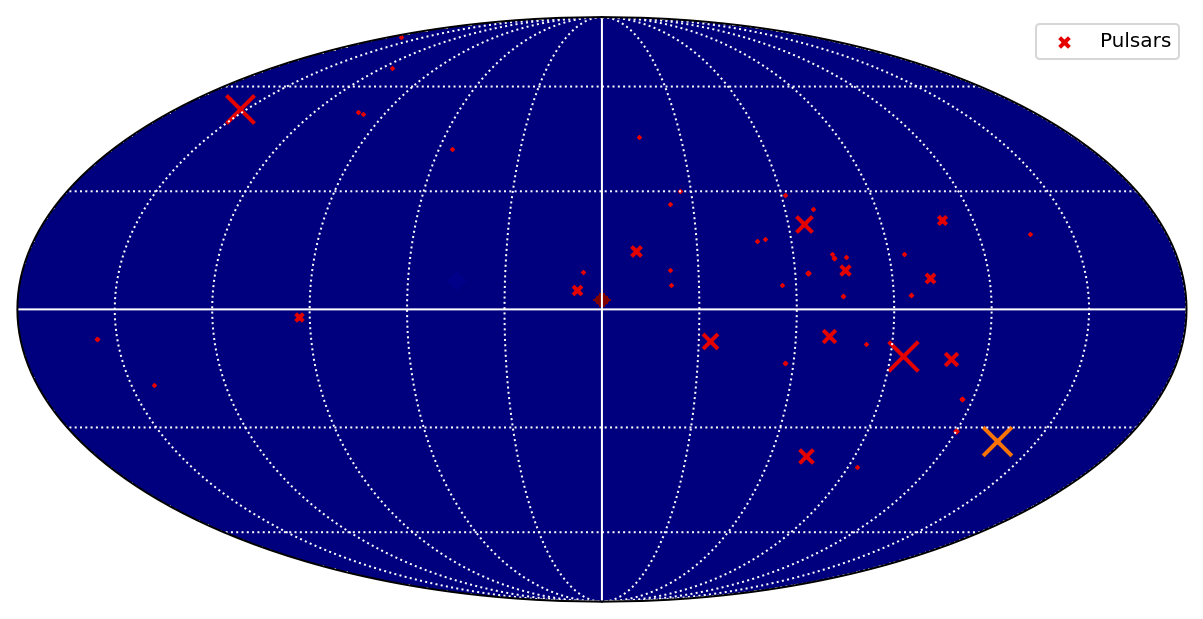

In [39]:
import healpy as hp

NSIDE=16
npix = hp.nside2npix(NSIDE)
print(npix)

#get hp indices for each sample
indices = hp.ang2pix(NSIDE, gw_theta, gw_phi)

#get counts for each pixel
idx, counts = np.unique(indices, return_counts=True)

#convert counts to PDF
sky_pdf = counts/np.sum(counts)/hp.nside2pixarea(NSIDE)

print(np.sum(counts))
print(sky_pdf)
print(np.max(sky_pdf))

# fill the array
skymap = np.zeros(npix)
skymap[idx] = sky_pdf

COORD = None
CMAP = 'jet'
#CMAP = 'jet_r'

hp.mollview(skymap, title='', cbar=False, coord=COORD, cmap=CMAP)
#hp.orthview(np.log(skymap+0.01), title='', half_sky=False, rot=(-30,-0,0), cbar=False)
#hp.orthview(skymap, title='', half_sky=False, rot=(90,-45,0), cbar=False, coord=COORD, cmap=CMAP)
#hp.mollview(skymap, title='', cbar=False)
hp.graticule(color='white')

#pulsar locations
tspan0 = enterprise_extensions.model_utils.get_tspan([psrs[0]]) / (365.25*24*3600)
hp.projscatter(psrs[0].theta, psrs[0].phi, marker='x', s=10/(12.5-tspan0), linewidth=2, color='xkcd:red',
               label='Pulsars', coord=COORD)
for p in psrs[1:]:
    tspan = enterprise_extensions.model_utils.get_tspan([p]) / (365.25*24*3600)
    print( tspan )
    #if p.name=='J0613-0200':
    #if p.name=='J1600-3053':
    if p.name=='J1455-3330':
    #if p.name=='J1747-4036':
    #if p.name=='J1909-3744':
    #if p.name==None:
        print('yeah')
        hp.projscatter(p.theta, p.phi, marker='x', s=10/(12.5-tspan), linewidth=2, color='xkcd:orange', coord=COORD)
    else:
        hp.projscatter(p.theta, p.phi, marker='x', s=10/(12.5-tspan), linewidth=2, color='xkcd:red', coord=COORD)

#injected location
#hp.projscatter(np.arccos(x0['0_cos_gwtheta']), x0['0_gwphi'], marker='x',
#               linewidth=2, color='xkcd:red', label='GW source', zorder=3)

plt.legend(loc=1)
#plt.savefig("Results/Plots/skymap_worst_case_scenario_psr0.png", dpi=300)
#plt.savefig("Results/Plots/skymap_worst_case_scenario_orth_psr0.png", dpi=300)